# Large-Scale E-commerce Clickstream Analysis

## Project Overview

This pet project explores an unknown brand large-scale e-commerce behavioral data by analyzing **61 days of individual datasets** totaling over **109 million user interaction records**. The data captures granular online retail activity; including product views, cart additions, and purchases across multiple days from October 1st to November 30th 2019.

Due to the size of the data, each day’s events are stored in a dictionary of Pandas DataFrames for efficient, modular processing. This architecture allows for time-based aggregations and dynamic querying while maintaining performance on local machines.

---

## Objectives

The primary objective is to **forecast and classify purchasing behavior** to use for business case solutions. Specific goals include:

- **Forecast daily sales and observations of users behavoirs**
- **Predict the likelihood of a purchase event**
- **Estimate the sales impact of browsing behavior (e.g., time on site, session length)**
- Achieve **at least 0.70 classification accuracy** for predicting if a user will purchase during a session

---
### Findings

- Achieved the project’s objective of forecasting and classifying purchasing behavior, reaching a **0.85 classification accuracy** score.
- Identified that low conversion rates and high browsing volume limited accurate purchase predictions.
- Conducted experiments testing various feature columns, discovering that previous event actions and time since last transaction produced a **1.00 classification accuracy**, signaling model overfitting.
- Used model feature importance tool to reveal that category-level features, rather than specific product details, drove predictive power — an unexpected insight into user behavior patterns.
- **Transformed and resampled** event data from seconds to hourly intervals, enabling effective time series modeling and improving generalization.
- Implemented the **Holt-Winters model**, achieving **Revenue RMSE: 86,702.02 and Purchasing RMSE: 297.09**, with sub-second prediction times after training.
- Determined time as a critical behavioral factor — **high revenue generating customers** consistently return within **10–12 days** on average, while **faster-purchasing** consumers show a **26-day** return cycle.
- Linked insights from **Behavior Profiling and Segmentation (EDA)** to Predictive Modeling, confirming that repeat customers exhibit strong temporal purchasing patterns.

#### Behavior Profiling and Segmentation (EDA) Highlights
	
| Cluster | Key Characteristics | Behavioral Summary |
|----------|---------------------|--------------------|
| **Cluster 0 – Passive Browsers** | Very low views (≈1.9) and near-zero purchases. Short sessions (~0.5 sec median). | Represents first-time visitors or accidental traffic. High volume but negligible commercial value. |
| **Cluster 1 – Infrequent Explorers** | Moderate engagement (≈6.6 views), low conversions (0.06%), medium-length sessions (~5 min). | Users show curiosity and occasional interaction but rarely convert — potential for retargeting. |
| **Cluster 2 – Active Engagers** | High views (≈47), solid carting behavior, short recency (~10 days). | Regular users exploring products deeply. Consistent traffic and potential mid-funnel audience. |
| **Cluster 3 – Loyal Buyers** | Moderate viewing but extremely high purchases and revenue (AOV ≈ \$544). Long median sessions (~6 min). | Core repeat purchasers with strong loyalty and efficient decision-making. |
| **Cluster 4 – Power Shoppers** | Very high activity (≈83 views), strong revenue generation (≈\$840), frequent sessions (~15 per user). | Highly engaged, time-efficient buyers driving a disproportionate share of total revenue. |



---
## Project Strategy

### 1. Data Preparation

- Handle missing or placeholder values (e.g., unknown brands or categories)
- Standardize column names and data types
- Parse timestamps and derive session durations
- Engineer features such as:
  - Session length
  - Encode views - purchase

### 2. Exploratory Data Analysis (EDA)

- Analyze traffic and sales trends by day, week, and holiday window
- Identify peak browsing and purchasing times
- Visualize category-level performance and brand engagement
- Explore conversion funnel: views → cart → purchase

### 3. Behavioral Profiling & Segmentation

- Cluster users by engagement levels and session patterns
- Examine product categories with high conversion rates
- Profile sessions by length and outcome (e.g., no action vs. purchase)

### 4. Predictive Modeling

- **Classification models** to predict:
  - Whether a user will make a purchase
- **Time series models** to forecast:
  - Daily and monthly product sales
  - Holiday-period revenue projections
- Train/test split by date to preserve temporal structure
- Evaluate models using metrics such as accuracy, F1-score (classification) and R², RMSE (regression)

---


## Deliverables

- Forecasting models with visualized predictions
- Classifiers to predict purchase intent
- Insights into user behavior, product performance, and holiday season dynamics
- Strategic recommendations for optimizing customer engagement and conversion

---

This project simulates real-world e-commerce data science workflows, with an emphasis on **scalability**, **user behavior understanding**, and **business impact through forecasting and prediction**.


## Environment Setup and Required Libraries

In [1]:
import pandas as pd 
import numpy as np
import glob
import os
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, roc_curve, classification_report, root_mean_squared_error
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib
from datetime import datetime
from matplotlib.ticker import FuncFormatter
import time
from functools import reduce
from pathlib import Path
import pickle
from typing import Dict, Tuple, Optional
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

FILE = 'Nov112019'

## Step 1: Loading and Initial Data Exploration

In [2]:
#Due to large size of the files... I had to split the file using vi in CLI into files by their dates

path = r'/Users/GitHub/eCommerceBehavior/Data_files' # use your path
#all_files = glob.glob(path + "/*.csv")
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths
#standardize Col Names
col= ['event_time', 'event_type', 'product_id', 'category_id',
      'category_code', 'brand', 'price', 'user_id', 'user_session']
ecom={}
for file in all_files:
     # Getting the file name without extension
    file_name = os.path.splitext(os.path.basename(file))[0]
    #parse time and index timestamps 
    data = pd.read_csv(file, names=col, header=0, low_memory=False, parse_dates=["event_time"], index_col="event_time")
    ecom.update({file_name: data })
len(ecom)

61

In [3]:
#show info for all but we're going to save space by showing the original code but displaying only one entry
"""for key in ecom:
    print(key)
    print(ecom[key].info(verbose=True, show_counts=True))"""
print(ecom[FILE].info(verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2009389 entries, 2019-11-11 00:00:00+00:00 to 2019-11-11 23:59:59+00:00
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_type     2009389 non-null  object 
 1   product_id     2009389 non-null  int64  
 2   category_id    2009389 non-null  int64  
 3   category_code  1347988 non-null  object 
 4   brand          1729873 non-null  object 
 5   price          2009389 non-null  float64
 6   user_id        2009389 non-null  int64  
 7   user_session   2009389 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 138.0+ MB
None


In [4]:
#show description for all but we're going to save space by showing the original code but displaying only one entry
"""for key in ecom:
    print(key)
    print(ecom[key].describe())"""
ecom[FILE].describe()

product_id   category_id         price       user_id
count  2.009389e+06  2.009389e+06  2.009389e+06  2.009389e+06
mean   1.147519e+07  2.057773e+18  2.885314e+02  5.388141e+08
std    1.355134e+07  1.952222e+16  3.524884e+02  2.286387e+07
min    1.000978e+06  2.053014e+18  0.000000e+00  8.830965e+07
25%    1.201499e+06  2.053014e+18  6.667000e+01  5.167052e+08
50%    5.100816e+06  2.053014e+18  1.595900e+02  5.366233e+08
75%    1.720098e+07  2.053014e+18  3.601100e+02  5.621552e+08
max    1.000052e+08  2.180737e+18  2.574070e+03  5.703502e+08

In [5]:
count_all = 0
for key in ecom:
    
    count, size  = ecom[key].shape
    count_all += count 
count_all  

109950685

In [6]:
nulls = 0
for key in ecom:
    nulls += ecom[key].isna().sum() 
nulls

event_type              0
product_id              0
category_id             0
category_code    35413762
brand            15341150
price                   0
user_id                 0
user_session           12
dtype: int64

In [7]:
print(f"Percentage of Nulls in category_code are: {nulls['category_code']/count_all:.2f}")
print(f"Percentage of Nulls in brand are: {nulls['brand']/count_all:.2f}")

Percentage of Nulls in category_code are: 0.32
Percentage of Nulls in brand are: 0.14


In [8]:
from collections import defaultdict

month_counts = defaultdict(int)

for key, df in ecom.items():
    month = key[:3] 
    month_counts[month] += len(df)

for month, count in month_counts.items():
    print(f"{month}: {count} rows")
    

Nov: 67501949 rows
Oct: 42448736 rows


### 🧼 Data Cleaning Summary

#### Total Rows (Across Datasets)

| Total Rows  |
|-------------|
| 109,950,685 |

---
#### 🔢 Null Value Totals (Summed Across All Dataset)

| Column         | Total Nulls  | Notes                        |
|----------------|-----------------------|------------------------------|
| category_code  | 35M+                 | High % of nulls (32%)        |
| brand          | 15M+                 | Moderate nulls (14%)      |
| user_session   | <50                   | Very rare nulls               |

---

#### Monthly Summary (Means and Medians)

| Month-Year | Count (approx) | Mean Price | Median Price |
|------------|----------------|------------|--------------|
| Oct 2019   | 42+ million    | ~290–310   | ~150–180     |
| Nov 2019   | 67+ million    | ~280–320   | ~150–190     |

---


## Step 2: Data Preparation

- Handle missing or placeholder values (e.g., unknown brands or categories)
- Parse timestamps
- Data types
- Duplicate handling

### Missing Data

In [9]:
null_exp = {}
for key in ecom:
    data = {key :ecom[key].loc[ecom[key]['category_code'].isna()]}
    null_exp.update(data)
len(null_exp)

61

In [10]:
#Cross-reference brand to find missing Category Codes
total_trend = pd.DataFrame()
nully = null_exp['Nov162019']['brand'].value_counts().index.tolist()
for key in ecom:
    null_trend = ecom[key].loc[ecom[key]['brand'].isin(nully)]
    null_trend = null_trend.reset_index()
    total_trend = pd.concat([total_trend, null_trend], ignore_index=True)

In [11]:
total_trend.shape

(85133744, 9)

In [12]:
worth_fixing = total_trend[total_trend['event_type']== 'purchase']
total_sales = worth_fixing['price'].sum()
total_sales 

464825025.34999996

In [13]:
full_sales = 0
null_sales = 0
null_purchases = 0
purchases = 0

for key in ecom:
    sales_null = null_exp[key][null_exp[key]['event_type']== 'purchase']
    sales = ecom[key][ecom[key]['event_type']== 'purchase']
    null_purchases += sales_null[sales_null['event_type']== 'purchase'].shape[0]
    purchases += sales[sales['event_type']== 'purchase'].shape[0]
    full_sales += sales['price'].sum()
    null_sales += sales_null['price'].sum()

print(f"Sales over the course of 61 days {full_sales:.2f}")
print(f"Null Sales over the course of 61 days {null_sales:.2f}")
print(f"Purchases over the course of 61 days {purchases:.2f}")
print(f"Null Purchases over the course of 61 days {null_purchases:.2f}")
print(f"Percentage of null sales {null_sales/full_sales:.2f}")
print(f"Percentage of null Purchases {null_purchases/purchases:.2f}")

Sales over the course of 61 days 505152392.77
Null Sales over the course of 61 days 52805443.81
Purchases over the course of 61 days 1659788.00
Null Purchases over the course of 61 days 407643.00
Percentage of null sales 0.10
Percentage of null Purchases 0.25


In [14]:
brand_to_category = (
    total_trend[total_trend['category_code'].notna()]
    .groupby('brand')['category_code']
    .agg(lambda x: x.value_counts().idxmax())  # most common non-null category per brand
)

for key in ecom:
    ecom[key]['category_code'] = ecom[key]['category_code'].fillna(
    ecom[key]['brand'].map(brand_to_category)
)



nulls = 0
for key in ecom:
    nulls += ecom[key].isna().sum() 
nulls

event_type              0
product_id              0
category_id             0
category_code    22194077
brand            15341150
price                   0
user_id                 0
user_session           12
dtype: int64

- Filling Nulls with Unknown seems the next best approach. 
- Cross-referencing most common brands to match category_code was not a complete success. 
- Split Category Code into ['department','product_group','product_sub'] sections

In [15]:
col = 'category_code'  # your column name
for key in ecom: 
    ecom[key][['department','product_group','product_sub']] = ecom[key][col].str.split('.', n=2, expand=True)

In [16]:
product_to_brand = (
    total_trend[total_trend['brand'].notna()]
    .groupby('product_id')['brand']
    .agg(lambda x: x.value_counts().idxmax())  # most common non-null category per brand
)

for key in ecom:
    ecom[key]['brand'] = ecom[key]['brand'].fillna(
    ecom[key]['product_id'].map(product_to_brand)
)

nulls = 0
for key in ecom:
    nulls += ecom[key].isna().sum() 
nulls

event_type              0
product_id              0
category_id             0
category_code    22194077
brand            14870924
price                   0
user_id                 0
user_session           12
department       22194077
product_group    22194077
product_sub      69968438
dtype: int64

In [17]:
for key in ecom:
    ecom[key] = ecom[key].dropna(subset=['user_session']).copy()

for key in ecom:
    ecom[key] = ecom[key].fillna('unknown')
    
nulls = 0
for key in ecom:
    nulls += ecom[key].isna().sum() 
nulls

event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
department       0
product_group    0
product_sub      0
dtype: int64

###  Parse timestamps and derive session durations

In [18]:
for key in ecom:
    ecom[key].sort_index(inplace=True)

In [19]:
for key in ecom:
    ecom[key]['year'] = ecom[key].index.year
    ecom[key]['month'] = ecom[key].index.month
    ecom[key]['day'] = ecom[key].index.day
    ecom[key]['dayofweek'] = ecom[key].index.dayofweek
    ecom[key]['hour'] = ecom[key].index.hour
    ecom[key]['min'] = ecom[key].index.minute
    ecom[key]['sec'] = ecom[key].index.second

In [20]:
ecom[file_name].head(1)

event_type  product_id          category_id  \
event_time                                                              
2019-10-24 00:00:01+00:00       view    51600011  2134904980736311929   

                                category_code    brand  price    user_id  \
event_time                                                                 
2019-10-24 00:00:01+00:00  electronics.clocks  unknown  12.84  546069707   

                                                   user_session   department  \
event_time                                                                     
2019-10-24 00:00:01+00:00  5592a85e-03f0-49ec-a4cc-b0730cc99932  electronics   

                          product_group product_sub  year  month  day  \
event_time                                                              
2019-10-24 00:00:01+00:00        clocks     unknown  2019     10   24   

                           dayofweek  hour  min  sec  
event_time                                            
2019-10-24 00:00:01+00:00          3     0    0    1

### Data Types

In [21]:
for key in ecom:
    ecom[key] = ecom[key].drop('category_code', axis=1)
ecom[FILE].head(1)

event_type  product_id          category_id  \
event_time                                                              
2019-11-11 00:00:00+00:00       view     3900002  2053013552326770905   

                             brand   price    user_id  \
event_time                                              
2019-11-11 00:00:00+00:00  ariston  108.74  514232424   

                                                   user_session  department  \
event_time                                                                    
2019-11-11 00:00:00+00:00  bb14b4c9-272b-4aa5-b4c4-a47b64057dee  appliances   

                          product_group   product_sub  year  month  day  \
event_time                                                                
2019-11-11 00:00:00+00:00   environment  water_heater  2019     11   11   

                           dayofweek  hour  min  sec  
event_time                                            
2019-11-11 00:00:00+00:00          0     0    0    0

In [22]:
ecom[FILE].dtypes

event_type        object
product_id         int64
category_id        int64
brand             object
price            float64
user_id            int64
user_session      object
department        object
product_group     object
product_sub       object
year               int32
month              int32
day                int32
dayofweek          int32
hour               int32
min                int32
sec                int32
dtype: object

In [23]:
def clean_obj(id):
    return str(id).strip()

for key in ecom:
    ecom[key]['product_id'] = ecom[key]['product_id'].astype('object')
    #ecom[key]['event_type'] = ecom[key]['event_type'].astype('category')
    ecom[key]['category_id'] = ecom[key]['category_id'].astype('object')
    #ecom[key]['brand'] = ecom[key]['brand'].astype('category')
    #ecom[key]['department'] = ecom[key]['department'].astype('category')
    #ecom[key]['product_group'] = ecom[key]['product_group'].astype('category')
    #ecom[key]['product_sub'] = ecom[key]['product_sub'].astype('category')
    ecom[key]['user_id'] = ecom[key]['user_id'].astype('object')
    ecom[key]['user_id']=ecom[key]['user_id'].apply(clean_obj)
    ecom[key]['product_id']=ecom[key]['product_id'].apply(clean_obj)
    ecom[key]['user_session']=ecom[key]['user_session'].apply(clean_obj)

ecom[FILE].dtypes

event_type        object
product_id        object
category_id       object
brand             object
price            float64
user_id           object
user_session      object
department        object
product_group     object
product_sub       object
year               int32
month              int32
day                int32
dayofweek          int32
hour               int32
min                int32
sec                int32
dtype: object

### Duplicates

In [24]:
dupes = 0
for key in ecom:
    dupes += ecom[key].duplicated().sum()
dupes

130739

In [25]:
for key in ecom:
    ecom[key] = ecom[key].drop_duplicates()

## Step 2.5: Feature Engineering 

- Derive session durations
- Engineer features such as:
  - Session length
  - Encode views to purchase


In [26]:
for key in ecom:
    ecom[key] = ecom[key].reset_index()


In [27]:
def sess_duration(df):
    """Calculate Duration of user_sessions inbetween events"""
    t = df.copy()                     
    t = t.sort_values(['user_id', 'user_session', 'event_time'])

    g = t.groupby(['user_id', 'user_session'], observed=True)

    t['prev_event_time']   = g['event_time'].shift(1)
    t['since_prev_sec']    = (t['event_time'] - t['prev_event_time']).dt.total_seconds()
    t['prev_event_type']   = g['event_type'].shift(1)
    t['transition_from'] = t['prev_event_type'].astype('string').fillna('START')
    t['transition'] = t['transition_from'] + ' → ' + t['event_type'].astype('string')

    t['since_prev_sec'] = t['since_prev_sec'].fillna(0)

    t['elapsed_in_session_sec'] = g['since_prev_sec'].cumsum()

    df_with_gaps = t.set_index('event_time').sort_index()
    return df_with_gaps


In [28]:
for key in ecom:
    ecom[key] = sess_duration(ecom[key])
ecom[FILE].head()

event_type product_id          category_id  \
event_time                                                             
2019-11-11 00:00:00+00:00       view    3900002  2053013552326770905   
2019-11-11 00:00:00+00:00       view   12708937  2053013553559896355   
2019-11-11 00:00:01+00:00       view    4801579  2053013554658804075   
2019-11-11 00:00:01+00:00       view    5100816  2053013553375346967   
2019-11-11 00:00:01+00:00       view    4804056  2053013554658804075   

                              brand   price    user_id  \
event_time                                               
2019-11-11 00:00:00+00:00   ariston  108.74  514232424   
2019-11-11 00:00:00+00:00  michelin   72.72  533966484   
2019-11-11 00:00:01+00:00      sony   24.43  569910194   
2019-11-11 00:00:01+00:00    xiaomi   29.60  515121122   
2019-11-11 00:00:01+00:00     apple  159.59  515070394   

                                                   user_session   department  \
event_time                                                                     
2019-11-11 00:00:00+00:00  bb14b4c9-272b-4aa5-b4c4-a47b64057dee   appliances   
2019-11-11 00:00:00+00:00  d5322831-e72e-4c21-9b4a-fde50b596d54      unknown   
2019-11-11 00:00:01+00:00  63af1c08-9b54-4fc8-8760-eaac2c9e650d  electronics   
2019-11-11 00:00:01+00:00  6e29f0d7-d772-4171-b939-5cf751f012b2  electronics   
2019-11-11 00:00:01+00:00  cfb4e17f-8e1e-4599-ab63-c3b3321fd713  electronics   

                          product_group   product_sub  ...  dayofweek  hour  \
event_time                                             ...                    
2019-11-11 00:00:00+00:00   environment  water_heater  ...          0     0   
2019-11-11 00:00:00+00:00       unknown       unknown  ...          0     0   
2019-11-11 00:00:01+00:00         audio     headphone  ...          0     0   
2019-11-11 00:00:01+00:00    smartphone       unknown  ...          0     0   
2019-11-11 00:00:01+00:00         audio     headphone  ...          0     0   

                           min  sec  prev_event_time  since_prev_sec  \
event_time                                                             
2019-11-11 00:00:00+00:00    0    0              NaT             0.0   
2019-11-11 00:00:00+00:00    0    0              NaT             0.0   
2019-11-11 00:00:01+00:00    0    1              NaT             0.0   
2019-11-11 00:00:01+00:00    0    1              NaT             0.0   
2019-11-11 00:00:01+00:00    0    1              NaT             0.0   

                           prev_event_type transition_from    transition  \
event_time                                                                 
2019-11-11 00:00:00+00:00              NaN           START  START → view   
2019-11-11 00:00:00+00:00              NaN           START  START → view   
2019-11-11 00:00:01+00:00              NaN           START  START → view   
2019-11-11 00:00:01+00:00              NaN           START  START → view   
2019-11-11 00:00:01+00:00              NaN           START  START → view   

                          elapsed_in_session_sec  
event_time                                        
2019-11-11 00:00:00+00:00                    0.0  
2019-11-11 00:00:00+00:00                    0.0  
2019-11-11 00:00:01+00:00                    0.0  
2019-11-11 00:00:01+00:00                    0.0  
2019-11-11 00:00:01+00:00                    0.0  

[5 rows x 23 columns]

### Views to Purchase

In [29]:
for key in ecom:
    ecom[key]['is_view'] = [1 if x == 'view' else 0 for x in ecom[key]['event_type']]
    ecom[key]['is_cart'] = [1 if x == 'cart' else 0 for x in ecom[key]['event_type']]
    ecom[key]['is_purchase'] = [1 if x == 'purchase' else 0 for x in ecom[key]['event_type']]
    ecom[key]['rev'] = np.where(ecom[key]['is_purchase'] == 1, ecom[key]['price'], 0.0)
ecom[FILE].head()


event_type product_id          category_id  \
event_time                                                             
2019-11-11 00:00:00+00:00       view    3900002  2053013552326770905   
2019-11-11 00:00:00+00:00       view   12708937  2053013553559896355   
2019-11-11 00:00:01+00:00       view    4801579  2053013554658804075   
2019-11-11 00:00:01+00:00       view    5100816  2053013553375346967   
2019-11-11 00:00:01+00:00       view    4804056  2053013554658804075   

                              brand   price    user_id  \
event_time                                               
2019-11-11 00:00:00+00:00   ariston  108.74  514232424   
2019-11-11 00:00:00+00:00  michelin   72.72  533966484   
2019-11-11 00:00:01+00:00      sony   24.43  569910194   
2019-11-11 00:00:01+00:00    xiaomi   29.60  515121122   
2019-11-11 00:00:01+00:00     apple  159.59  515070394   

                                                   user_session   department  \
event_time                                                                     
2019-11-11 00:00:00+00:00  bb14b4c9-272b-4aa5-b4c4-a47b64057dee   appliances   
2019-11-11 00:00:00+00:00  d5322831-e72e-4c21-9b4a-fde50b596d54      unknown   
2019-11-11 00:00:01+00:00  63af1c08-9b54-4fc8-8760-eaac2c9e650d  electronics   
2019-11-11 00:00:01+00:00  6e29f0d7-d772-4171-b939-5cf751f012b2  electronics   
2019-11-11 00:00:01+00:00  cfb4e17f-8e1e-4599-ab63-c3b3321fd713  electronics   

                          product_group   product_sub  ...  prev_event_time  \
event_time                                             ...                    
2019-11-11 00:00:00+00:00   environment  water_heater  ...              NaT   
2019-11-11 00:00:00+00:00       unknown       unknown  ...              NaT   
2019-11-11 00:00:01+00:00         audio     headphone  ...              NaT   
2019-11-11 00:00:01+00:00    smartphone       unknown  ...              NaT   
2019-11-11 00:00:01+00:00         audio     headphone  ...              NaT   

                           since_prev_sec  prev_event_type  transition_from  \
event_time                                                                    
2019-11-11 00:00:00+00:00             0.0              NaN            START   
2019-11-11 00:00:00+00:00             0.0              NaN            START   
2019-11-11 00:00:01+00:00             0.0              NaN            START   
2019-11-11 00:00:01+00:00             0.0              NaN            START   
2019-11-11 00:00:01+00:00             0.0              NaN            START   

                             transition  elapsed_in_session_sec  is_view  \
event_time                                                                 
2019-11-11 00:00:00+00:00  START → view                     0.0        1   
2019-11-11 00:00:00+00:00  START → view                     0.0        1   
2019-11-11 00:00:01+00:00  START → view                     0.0        1   
2019-11-11 00:00:01+00:00  START → view                     0.0        1   
2019-11-11 00:00:01+00:00  START → view                     0.0        1   

                          is_cart  is_purchase  rev  
event_time                                           
2019-11-11 00:00:00+00:00       0            0  0.0  
2019-11-11 00:00:00+00:00       0            0  0.0  
2019-11-11 00:00:01+00:00       0            0  0.0  
2019-11-11 00:00:01+00:00       0            0  0.0  
2019-11-11 00:00:01+00:00       0            0  0.0  

[5 rows x 27 columns]

### Forecasting DF

In [30]:
forecasting = pd.DataFrame()
for key in ecom:
    forecasting2 = ecom[key][['is_purchase','rev']].copy()
    forecasting2 = forecasting2.resample('1min').sum()
    forecasting = pd.concat([forecasting2, forecasting], axis=0)
    forecasting.sort_index(inplace=True)

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['min'] = data.index.minute
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['is_purchase'].shift(lag)
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['rev'].shift(lag)

    data['rolling_mean_purchases'] = data['is_purchase'].shift().rolling(window=rolling_mean_size).mean()
    data['rolling_mean_rev'] = data['rev'].shift().rolling(window=rolling_mean_size).mean()


make_features(forecasting, 4, 4)
forecasting = forecasting.fillna(0)
forecasting.head()

is_purchase     rev  year  month  day  dayofweek  \
event_time                                                                    
2019-10-01 00:00:00+00:00            0    0.00  2019     10    1          1   
2019-10-01 00:01:00+00:00            0    0.00  2019     10    1          1   
2019-10-01 00:02:00+00:00            1  130.76  2019     10    1          1   
2019-10-01 00:03:00+00:00            0    0.00  2019     10    1          1   
2019-10-01 00:04:00+00:00            1  642.69  2019     10    1          1   

                           hour  min   lag_1   lag_2  lag_3  lag_4  \
event_time                                                           
2019-10-01 00:00:00+00:00     0    0    0.00    0.00    0.0    0.0   
2019-10-01 00:01:00+00:00     0    1    0.00    0.00    0.0    0.0   
2019-10-01 00:02:00+00:00     0    2    0.00    0.00    0.0    0.0   
2019-10-01 00:03:00+00:00     0    3  130.76    0.00    0.0    0.0   
2019-10-01 00:04:00+00:00     0    4    0.00  130.76    0.0    0.0   

                           rolling_mean_purchases  rolling_mean_rev  
event_time                                                           
2019-10-01 00:00:00+00:00                    0.00              0.00  
2019-10-01 00:01:00+00:00                    0.00              0.00  
2019-10-01 00:02:00+00:00                    0.00              0.00  
2019-10-01 00:03:00+00:00                    0.00              0.00  
2019-10-01 00:04:00+00:00                    0.25             32.69

### Summary of Steps 2 & 2.5

- Successfully replace nulls with most common cross-referenced entries and unknown
- Parsed Time and created duration features
- Created encoded views, cart, purchase features while adding revenue/sales data
- Deleted duplicates but would highlight/ask to DBM team if carting same product twice triggers duplicates (97% were carted items)
- Created Forecasting dataframe for Time Series predictive modeling and sanity check purposes
  

## Step 3: Exploratory Data Analysis (EDA)

- Analyze traffic and sales trends by daily activity and holiday window
- Identify peak browsing and purchasing times
- Visualize category-level performance and brand engagement
- Explore conversion funnel: views → cart → purchase

In [31]:
def prep(df):
    
    df = df.reset_index()
    df = df.copy()
    # revenue only on purchase rows
    df['view']     = (df['event_type'] == 'view').astype('int64')
    df['cart']     = (df['event_type'] == 'cart').astype('int64')
    df['purchase'] = (df['event_type'] == 'purchase').astype('int64')
    df['rev'] = np.where(df['is_purchase'] == 1, df['price'], 0.0)
    return df

def build_metrics(df, freq='D'):
    d = prep(df)  # creates columns: view, cart, purchase, rev
    gr = d.set_index('event_time').groupby(pd.Grouper(freq=freq))

    agg = gr.agg(
        views=('view','sum'),
        carts=('cart','sum'),
        purchases=('purchase','sum'),
        unique_users=('user_id','nunique'),
        sessions=('user_session','nunique'),
        revenue=('rev','sum')
    ).fillna(0)

    safe = lambda s: s.replace(0, pd.NA)
    agg['aov']      = agg['revenue']   / safe(agg['purchases'])
    agg['v2p_rate'] = agg['purchases'] / safe(agg['views'])
    agg['c2p_rate'] = agg['purchases'] / safe(agg['carts'])

    return agg   


In [32]:
metrics = pd.DataFrame()
for key in ecom:
    daily_metrics  = build_metrics(ecom[key], freq='D')
    metrics = pd.concat([daily_metrics, metrics], axis=0)
    metrics.sort_index(inplace=True)
    metrics = metrics.dropna(subset=['aov']).copy()
    
metrics 

views   carts  purchases  unique_users  sessions  \
event_time                                                                      
2019-10-01 00:00:00+00:00  1208216   16193      19305        190188    268737   
2019-10-02 00:00:00+00:00  1154512   16871      19469        184965    261252   
2019-10-03 00:00:00+00:00  1088666   18702      19255        170668    241086   
2019-10-04 00:00:00+00:00  1346242   42657      27039        209410    300651   
2019-10-05 00:00:00+00:00  1271277   34564      23492        194958    276914   
2019-10-06 00:00:00+00:00  1263999   30994      22169        193210    273034   
2019-10-07 00:00:00+00:00  1161025   17570      21378        186951    263437   
2019-10-08 00:00:00+00:00  1329053   17952      23071        221203    308347   
2019-10-09 00:00:00+00:00  1306300   17886      22747        214140    301219   
2019-10-10 00:00:00+00:00  1243026   18336      21992        205321    295141   
2019-10-11 00:00:00+00:00  1447614   20733      26224        230533    333407   
2019-10-12 00:00:00+00:00  1433771   19998      25373        208355    304374   
2019-10-13 00:00:00+00:00  1584604   24124      29561        225942    333508   
2019-10-14 00:00:00+00:00  1381358   43591      28405        209089    307692   
2019-10-15 00:00:00+00:00  1466232   48066      26371        230135    334648   
2019-10-16 00:00:00+00:00  1445655   43936      31393        230199    328743   
2019-10-17 00:00:00+00:00  1338253   39281      28317        208477    302842   
2019-10-18 00:00:00+00:00  1415730   38879      25849        229462    334976   
2019-10-19 00:00:00+00:00  1385095   38285      24657        217920    321300   
2019-10-20 00:00:00+00:00  1444284   39375      25097        231848    339942   
2019-10-21 00:00:00+00:00  1343490   35485      25165        225269    321282   
2019-10-22 00:00:00+00:00  1354474   36027      25383        223383    316705   
2019-10-23 00:00:00+00:00  1319921   35372      24730        219100    310453   
2019-10-24 00:00:00+00:00  1256717   34592      23999        206937    293587   
2019-10-25 00:00:00+00:00  1374430   35550      23883        223258    318055   
2019-10-26 00:00:00+00:00  1289781   33722      22653        202172    289579   
2019-10-27 00:00:00+00:00  1330852   33147      23401        201359    289835   
2019-10-28 00:00:00+00:00  1221887   17193      21111        195563    281001   
2019-10-29 00:00:00+00:00  1190031   16597      20372        193167    276722   
2019-10-30 00:00:00+00:00  1172282   16458      20815        191965    274906   
2019-10-31 00:00:00+00:00  1208520   16305      20097        198570    281445   
2019-11-01 00:00:00+00:00  1403948   18349      22457        223108    320904   
2019-11-02 00:00:00+00:00  1514262   18808      21863        234684    338768   
2019-11-03 00:00:00+00:00  1525356   19538      22145        240187    343373   
2019-11-04 00:00:00+00:00  1744241   21377      26889        275611    396755   
2019-11-05 00:00:00+00:00  1673086   18800      24872        262338    376362   
2019-11-06 00:00:00+00:00  1649779   19124      25319        256887    367143   
2019-11-07 00:00:00+00:00  1752466   18908      24862        278988    396201   
2019-11-08 00:00:00+00:00  1793282   74953      25714        286053    444456   
2019-11-09 00:00:00+00:00  1784962   67854      22767        268643    410390   
2019-11-10 00:00:00+00:00  1846062   69413      22878        276197    417583   
2019-11-11 00:00:00+00:00  1909243   72723      24930        292400    463241   
2019-11-12 00:00:00+00:00  1895059   67597      22725        285994    453789   
2019-11-13 00:00:00+00:00  1924915   69245      22548        285407    459245   
2019-11-14 00:00:00+00:00  2877070  165541      22124        308842    561856   
2019-11-16 00:00:00+00:00  6027798  392878      68247        487326    992492   
2019-11-17 00:00:00+00:00  5783121  411604     185195        487501    976305   
2019-11-18 00:00:00+00:00  1909737   80682      28537       

In [33]:

def plot_daily_overview(daily_metrics: pd.DataFrame,
                        date_range: tuple[str, str] | None = None):
    """
    Plots three figures from a daily_metrics DataFrame:
      1) views, carts, purchases (left axis) + revenue (right axis)
      2) unique_users, sessions
      3) v2p_rate, c2p_rate

    - Accepts tz-aware or tz-naive indices (will localize to UTC if naive).
    - Accepts tz-naive or tz-aware date_range strings and coerces them to the index tz.
    """
    dm = daily_metrics.copy()

    # Ensure DatetimeIndex
    if not isinstance(dm.index, pd.DatetimeIndex):
        if 'event_time' in dm.columns:
            dm['event_time'] = pd.to_datetime(dm['event_time'], errors='coerce', utc=True)
            dm = dm.set_index('event_time')
        else:
            dm.index = pd.to_datetime(dm.index, errors='coerce', utc=True)

    dm = dm.sort_index()
    dm = dm[~dm.index.isna()]

    # If index is tz-naive, localize to UTC for consistency
    if dm.index.tz is None:
        dm.index = dm.index.tz_localize('UTC')

    # Optional subsetting with timezone-safe coercion
    if date_range:
        tz = dm.index.tz

        def _to_index_tz(x):
            ts = pd.Timestamp(x)
            if ts.tz is None:
                return ts.tz_localize(tz)
            else:
                return ts.tz_convert(tz)

        start = _to_index_tz(date_range[0])
        end   = _to_index_tz(date_range[1])
        dm = dm.loc[start:end]

    # Sanity checks
    req1 = ['views','carts','purchases','revenue']
    req2 = ['unique_users','sessions']
    req3 = ['v2p_rate','c2p_rate']
    for req in (req1, req2, req3):
        missing = [c for c in req if c not in dm.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

    # ---------- Figure 1: Traffic & Sales ----------
    fig1, ax1 = plt.subplots(figsize=(11, 4.8))
    dm[['views','carts','purchases']].plot(ax=ax1)
    ax1.set_title("Traffic & Sales — Views / Carts / Purchases (left) and Revenue (right)")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Counts")
    ax1.grid(True, which="both", axis="both", alpha=0.3)

    ax2 = ax1.twinx()
    dm['revenue'].plot(ax=ax2, linestyle='--')
    ax2.set_ylabel("Revenue (USD)")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))
    fig1.tight_layout()
    plt.show()

    # ---------- Figure 2: User Activity ----------
    fig2, ax = plt.subplots(figsize=(11, 4.8))
    dm[['unique_users','sessions']].plot(ax=ax)
    ax.set_title("User Activity — Unique Users and Sessions")
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")
    ax.grid(True, which="both", axis="both", alpha=0.3)
    fig2.tight_layout()
    plt.show()

    # ---------- Figure 3: Conversion Rates ----------
    fig3, ax = plt.subplots(figsize=(11, 4.8))
    dm[['v2p_rate','c2p_rate']].plot(ax=ax)
    ax.set_title("Conversion Rates — View→Purchase and Cart→Purchase")
    ax.set_xlabel("Date")
    ax.set_ylabel("Rate")
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:.3f}"))
    ax.grid(True, which="both", axis="both", alpha=0.3)
    fig3.tight_layout()
    plt.show()


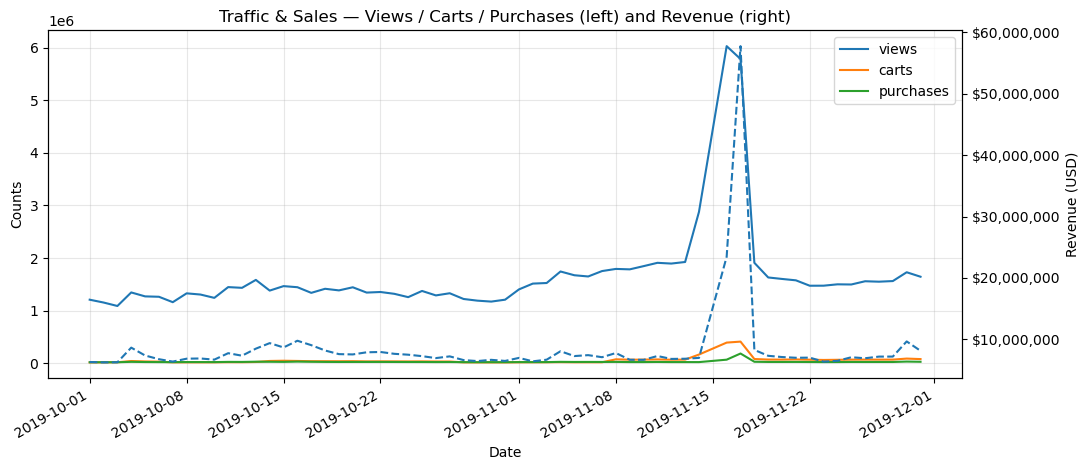

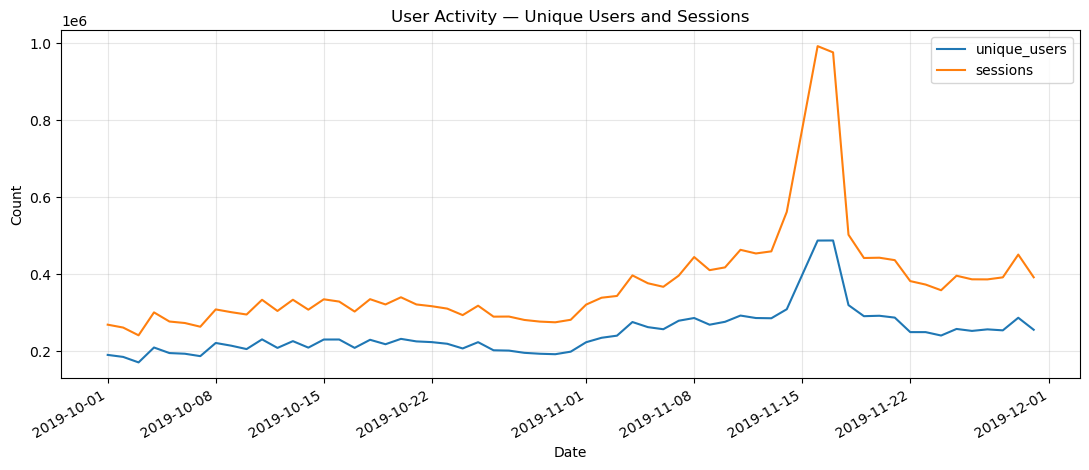

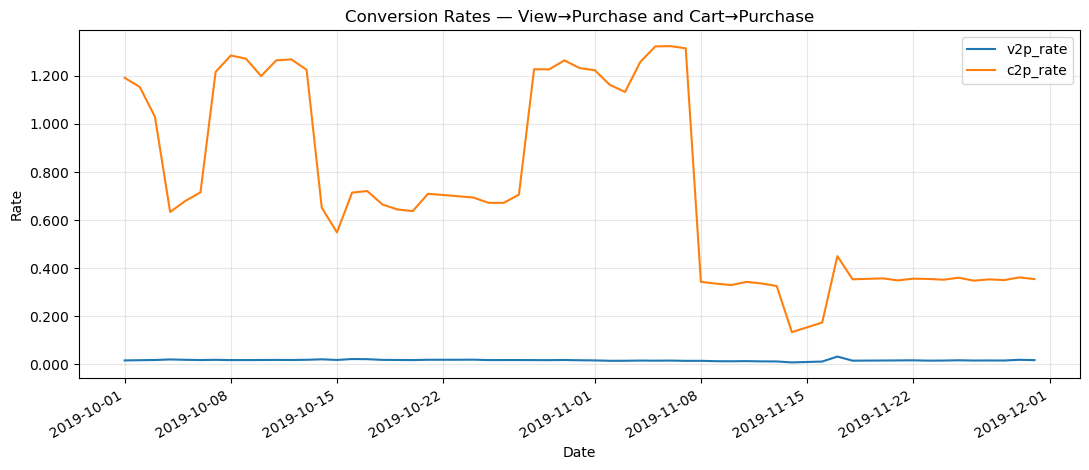

In [36]:
plot_daily_overview(metrics)

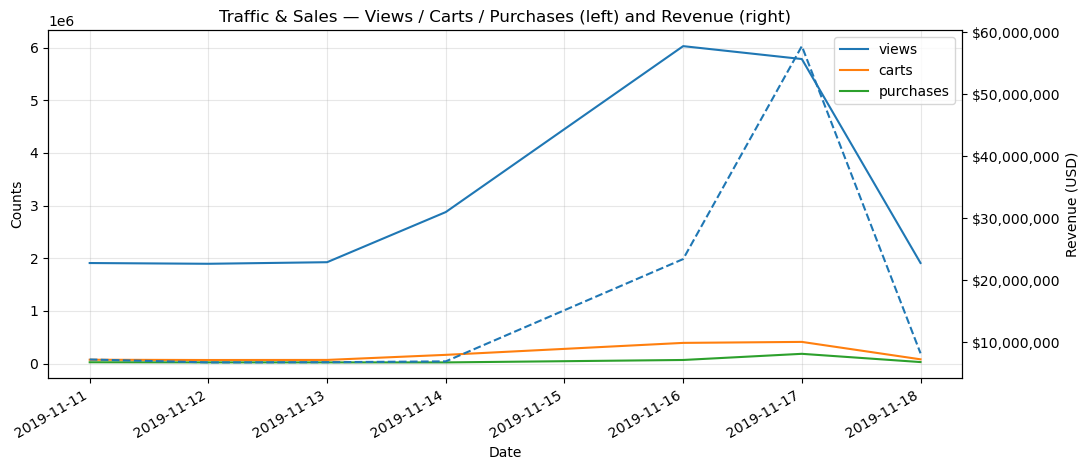

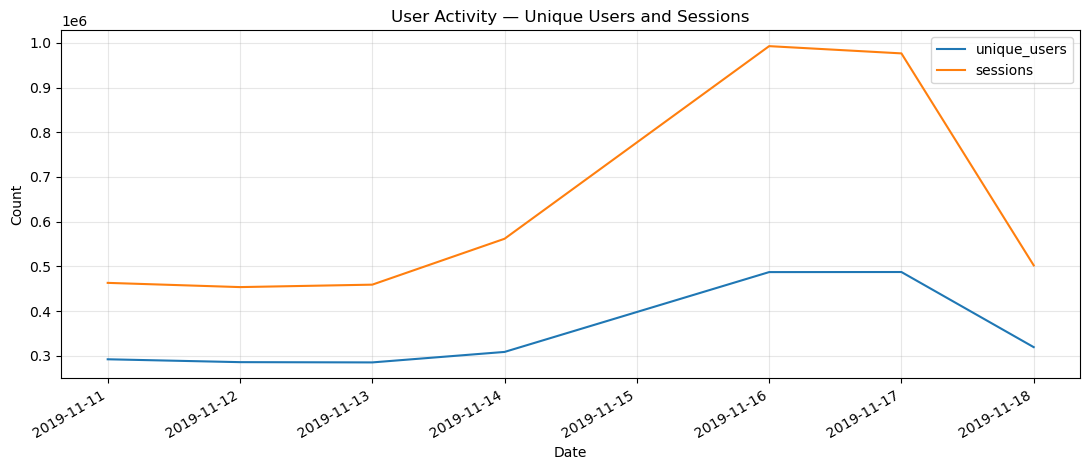

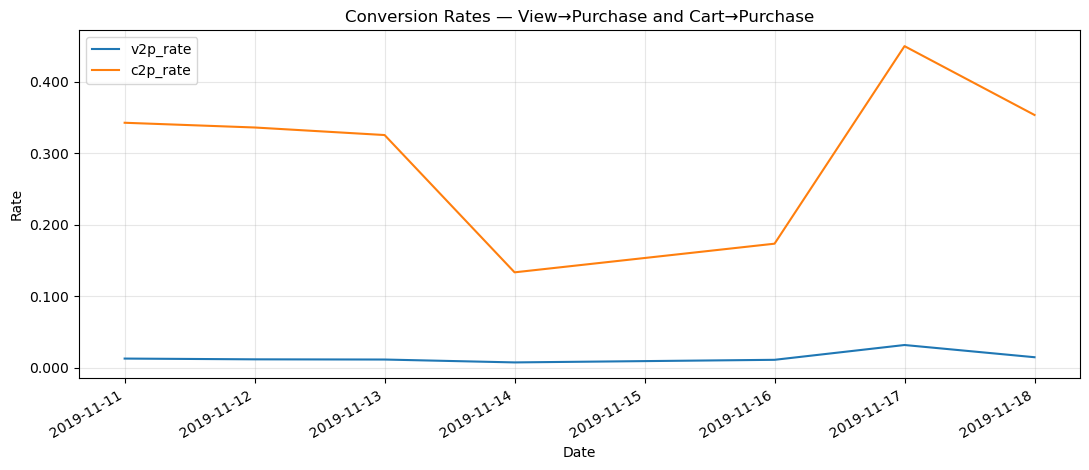

In [37]:
plot_daily_overview(metrics, date_range=("2019-11-11", "2019-11-18"))

### Identify peak browsing and purchasing times

In [38]:
browsing = pd.DataFrame()
for key in ecom:
    browsing2 = ecom[key][['is_view', 'is_cart', 'is_purchase', 'rev' ]].copy()
    browsing2 = browsing2.resample('1h').sum()
    browsing = pd.concat([browsing2, browsing], axis=0)
    browsing.sort_index(inplace=True)
    
browsing

is_view  is_cart  is_purchase        rev
event_time                                                         
2019-10-01 00:00:00+00:00     1069        3           10    2387.84
2019-10-01 01:00:00+00:00      121        0            0       0.00
2019-10-01 02:00:00+00:00    22322      242          316   85533.96
2019-10-01 03:00:00+00:00    47947      612          845  252050.18
2019-10-01 04:00:00+00:00    53387      831         1021  316664.79
...                            ...      ...          ...        ...
2019-11-30 19:00:00+00:00    61550     1957          666  198830.65
2019-11-30 20:00:00+00:00    38637     1318          533  184196.80
2019-11-30 21:00:00+00:00    22122      763          341  125471.04
2019-11-30 22:00:00+00:00    13391      536          249   91864.81
2019-11-30 23:00:00+00:00     9415      375          159   60190.54

[1467 rows x 4 columns]

In [39]:

def plot_peak_browse_purchase(df: pd.DataFrame, smooth_hours: int | None = None):
    """
    Assumes:
      - df.index is a DatetimeIndex (hourly)
      - columns: ['is_view','is_cart','is_purchase','rev'] are numeric

    Figures:
      1) Average is_view & is_purchase by HOUR
      2) Heatmap of purchases by day-of-week × hour (SUM)
      3) Revenue by HOUR (SUM)
      4) Purchases over time (hourly series)  <-- added
    """
    d = df.copy()
    d['hour'] = d.index.hour
    d['dow']  = d.index.dayofweek  # 0=Mon ... 6=Sun

    # -------- 1) Average activity by hour (views & purchases) --------
    hourly_mean = d.groupby('hour')[['is_view','is_purchase']].mean()
    peak_view_hour = int(hourly_mean['is_view'].idxmax()) if not hourly_mean.empty else None
    peak_pur_hour  = int(hourly_mean['is_purchase'].idxmax()) if not hourly_mean.empty else None

    fig1, ax1 = plt.subplots(figsize=(11, 4.5))
    hourly_mean[['is_view','is_purchase']].plot(ax=ax1)
    ax1.set_title("Average Activity by Hour")
    ax1.set_xlabel("Hour of Day"); ax1.set_ylabel("Average Count per Hour")
    ax1.set_xticks(range(24)); ax1.grid(True, alpha=0.3)
    if peak_view_hour is not None:
        ax1.axvline(peak_view_hour, linestyle='--', alpha=0.7)
        ax1.text(peak_view_hour, ax1.get_ylim()[1]*0.95, "peak views", ha='center', va='top', rotation=90)
    if peak_pur_hour is not None:
        ax1.axvline(peak_pur_hour, linestyle=':', alpha=0.7)
        ax1.text(peak_pur_hour, ax1.get_ylim()[1]*0.85, "peak purchases", ha='center', va='top', rotation=90)
    fig1.tight_layout()
    plt.show()

    # -------- 2) Purchases heatmap by DOW × hour (sum) --------
    pivot_pur = d.pivot_table(index='dow', columns='hour', values='is_purchase', aggfunc='sum', fill_value=0)
    day_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

    fig2, ax2 = plt.subplots(figsize=(11, 4.5))
    im = ax2.imshow(pivot_pur.values, aspect='auto', origin='upper')
    ax2.set_title("Purchases Heatmap by Day-of-Week × Hour")
    ax2.set_xlabel("Hour of Day"); ax2.set_ylabel("Day of Week")
    ax2.set_xticks(range(24)); ax2.set_yticks(range(7)); ax2.set_yticklabels(day_names)
    cbar = plt.colorbar(im, ax=ax2); cbar.set_label("Purchases (sum)")
    fig2.tight_layout()
    plt.show()

    # -------- 3) Revenue by hour (sum) --------
    rev_by_hour = d.groupby('hour')['rev'].sum()
    peak_rev_hour = int(rev_by_hour.idxmax()) if len(rev_by_hour) else None

    fig3, ax3 = plt.subplots(figsize=(11, 4.5))
    rev_by_hour.plot(ax=ax3)
    ax3.set_title("Revenue by Hour (sum)")
    ax3.set_xlabel("Hour of Day"); ax3.set_ylabel("Revenue")
    ax3.set_xticks(range(24)); ax3.grid(True, alpha=0.3)
    if peak_rev_hour is not None:
        ax3.axvline(peak_rev_hour, linestyle='--', alpha=0.7)
        ax3.text(peak_rev_hour, ax3.get_ylim()[1]*0.95, "peak revenue", ha='center', va='top', rotation=90)
    fig3.tight_layout()
    plt.show()

    # Quick summary
    print("Peak browsing hour:", peak_view_hour)
    print("Peak purchasing hour:", peak_pur_hour)
    print("Peak revenue hour:", peak_rev_hour)



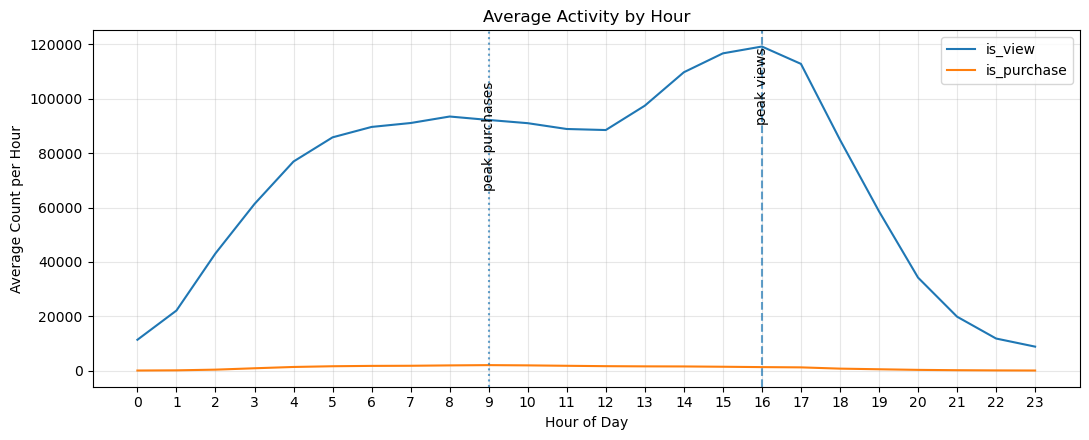

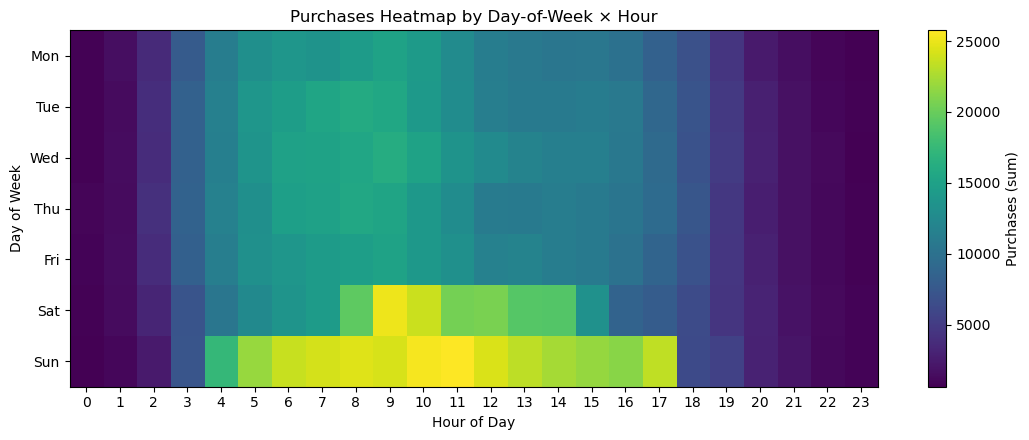

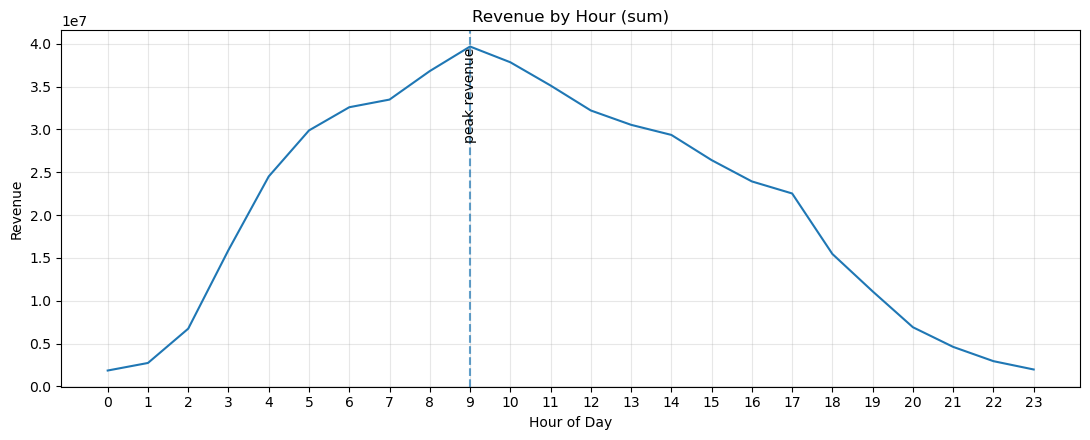

Peak browsing hour: 16
Peak purchasing hour: 9
Peak revenue hour: 9


In [40]:
plot_peak_browse_purchase(browsing) 

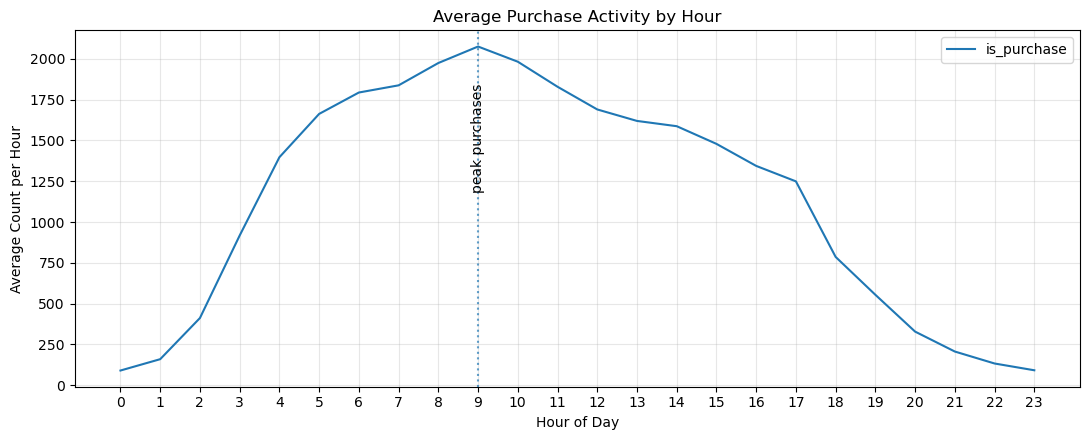

In [41]:
d = browsing.copy()
d['hour'] = d.index.hour
d['dow']  = d.index.dayofweek
hourly_mean = d.groupby('hour')[['is_view','is_purchase']].mean()
peak_pur_hour  = int(hourly_mean['is_purchase'].idxmax()) if not hourly_mean.empty else None

fig1, ax1 = plt.subplots(figsize=(11, 4.5))
hourly_mean[['is_purchase']].plot(ax=ax1)
ax1.set_title("Average Purchase Activity by Hour")
ax1.set_xlabel("Hour of Day"); ax1.set_ylabel("Average Count per Hour")
ax1.set_xticks(range(24)); ax1.grid(True, alpha=0.3)
if peak_pur_hour is not None:
    ax1.axvline(peak_pur_hour, linestyle=':', alpha=0.7)
    ax1.text(peak_pur_hour, ax1.get_ylim()[1]*0.85, "peak purchases", ha='center', va='top', rotation=90)
fig1.tight_layout()
plt.show()          

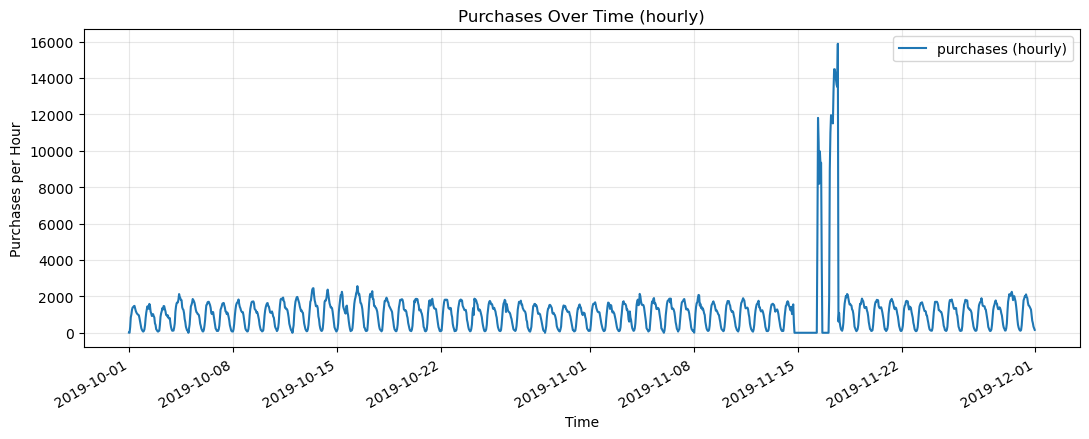

In [42]:
fig4, ax4 = plt.subplots(figsize=(11, 4.5))
d['is_purchase'].plot(ax=ax4, label='purchases (hourly)')
ax4.set_title("Purchases Over Time (hourly)")
ax4.set_xlabel("Time"); ax4.set_ylabel("Purchases per Hour")
ax4.grid(True, alpha=0.3)
ax4.legend()
fig4.tight_layout()
plt.show()

### Brand Engagement

In [43]:
def prep_events(df: pd.DataFrame) -> pd.DataFrame:
    """
    Minimal: keep only columns we aggregate. 
    Assumes is_view/is_cart/is_purchase/rev are already numeric.
    """
    keep = [c for c in [
        'is_view','is_cart','is_purchase','rev','user_id','user_session',
        'brand','department','product_group','product_sub','category_id'
    ] if c in df.columns]
    return df[keep].copy()

def safe_rate(num: pd.Series, den: pd.Series) -> pd.Series:
    num = pd.to_numeric(num, errors='coerce').astype(float)
    den = pd.to_numeric(den, errors='coerce').astype(float).replace(0, np.nan)
    return num / den

def infer_cat_cols(d: pd.DataFrame) -> list[str]:
    if {'department','product_group','product_sub'}.issubset(d.columns):
        return ['department','product_group','product_sub']
    if {'department','product_group'}.issubset(d.columns):
        return ['department','product_group']
    if 'category_id' in d.columns:
        return ['category_id']
    raise ValueError("No category columns found; pass cat_cols=['...'] explicitly.")

def _labels(idx) -> list[str]:
    if isinstance(idx, pd.MultiIndex):
        return [' / '.join(map(str, t)) for t in idx.tolist()]
    return list(map(str, idx.tolist()))

def aggregate_ecom(
    ecom: dict,
    grain: str = 'category',          # 'category' | 'brand' | 'category_brand'
    cat_cols: list[str] | None = None,
    skip_missing_shards: bool = False
) -> pd.DataFrame:
    parts, skipped = [], []

    for name, df in ecom.items():
        try:
            d = prep_events(df)
            # choose grouping cols
            if grain == 'brand':
                if 'brand' not in d.columns: 
                    raise ValueError("Missing 'brand'")
                gcols = ['brand']
            else:
                gcols = cat_cols or infer_cat_cols(d)
                if grain == 'category_brand':
                    if 'brand' not in d.columns:
                        raise ValueError("Missing 'brand' for category_brand grain")
                    gcols = gcols + ['brand']

            grp = d.groupby(gcols, observed=True).agg(
                views=('is_view', 'sum'),
                carts=('is_cart', 'sum'),
                purchases=('is_purchase', 'sum'),
                revenue=('rev', 'sum'),
                unique_users=('user_id','nunique') if 'user_id' in d.columns else ('is_view','count'),
                sessions=('user_session','nunique') if 'user_session' in d.columns else ('is_view','count'),
            )
            parts.append(grp)
        except Exception as e:
            if skip_missing_shards:
                skipped.append((name, str(e)))
                continue
            raise

    if not parts:
        cols = ['views','carts','purchases','revenue','unique_users','sessions','aov','v2p_rate','c2p_rate']
        return pd.DataFrame(columns=cols)

    stacked = pd.concat(parts, axis=0)
    idx_levels = list(range(stacked.index.nlevels))
    combined = (stacked
                .groupby(level=idx_levels, observed=True)
                .sum(numeric_only=True))

    # derived metrics from totals
    combined['aov']      = safe_rate(combined['revenue'],   combined['purchases'])
    combined['v2p_rate'] = safe_rate(combined['purchases'], combined['views'])
    combined['c2p_rate'] = safe_rate(combined['purchases'], combined['carts'])

    if skipped:
        print("Skipped shards:")
        for k, msg in skipped:
            print(f" - {k}: {msg}")

    return combined.sort_values('revenue', ascending=False)

# ========= visuals =========
def plot_agg_top_revenue(agg: pd.DataFrame, top_n: int = 20, title: str | None = None):
    if agg.empty: 
        raise ValueError("Aggregated DataFrame is empty.")
    top = agg.head(top_n)
    labels = _labels(top.index)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(labels, top['revenue'])
    ax.set_title(title or "Top Groups by Revenue")
    ax.set_ylabel("Revenue")
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, axis='y', alpha=0.3)
    fig.tight_layout()
    plt.show();

def plot_agg_rates(agg: pd.DataFrame, top_n: int = 20, title_prefix: str = "Groups"):
    if agg.empty: 
        raise ValueError("Aggregated DataFrame is empty.")
    top = agg.head(top_n)
    labels = _labels(top.index)

    fig1, ax1 = plt.subplots(figsize=(12, 4.5))
    ax1.bar(labels, top['v2p_rate'])
    ax1.set_title(f"{title_prefix} — View→Purchase Rate (Top by Revenue)")
    ax1.set_ylabel("Rate")
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.grid(True, axis='y', alpha=0.3)
    fig1.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(12, 4.5))
    ax2.bar(labels, top['c2p_rate'])
    ax2.set_title(f"{title_prefix} — Cart→Purchase Rate (Top by Revenue)")
    ax2.set_ylabel("Rate")
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.grid(True, axis='y', alpha=0.3)
    fig2.tight_layout()
    plt.show();


/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


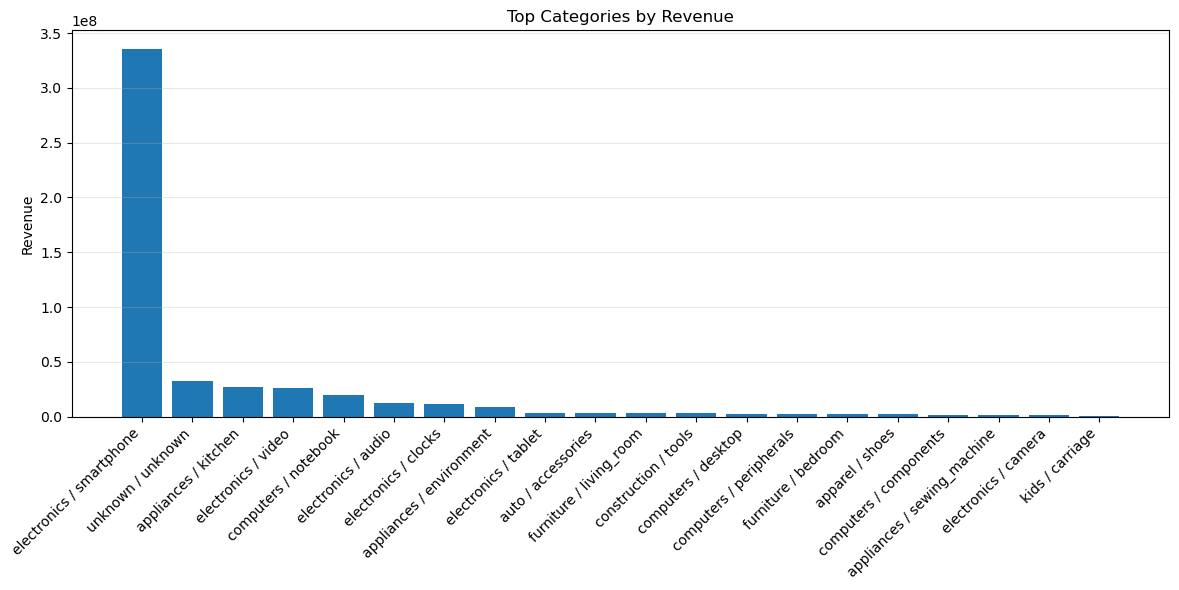

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


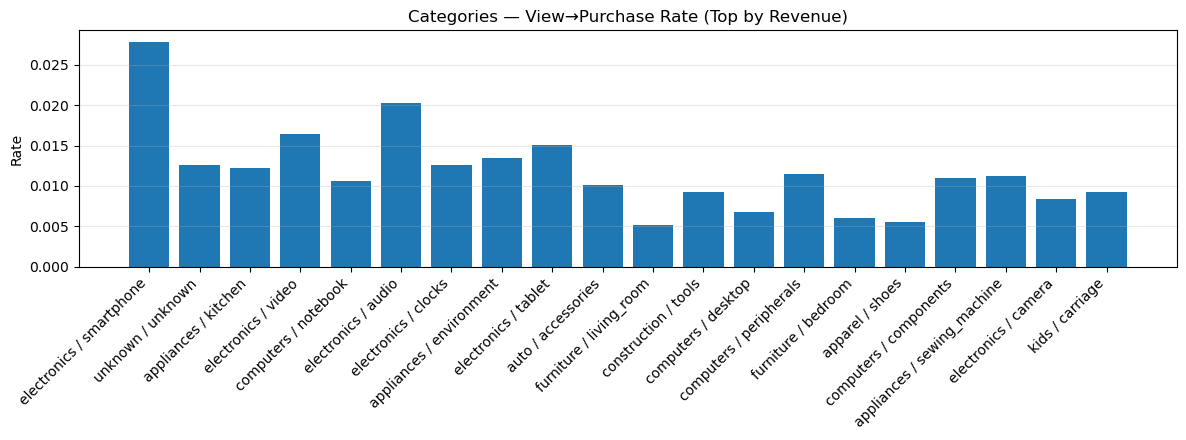

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha='right')


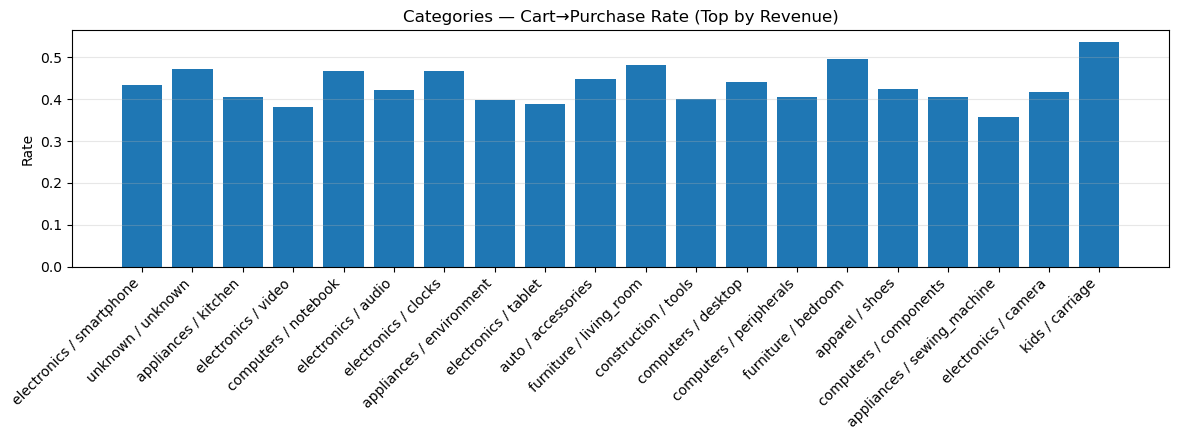

In [44]:
# 1) Category-level across all files:
# Aggregate across your dict 
agg_cat = aggregate_ecom(
    ecom,
    grain='category',                          # or 'brand' / 'category_brand'
    cat_cols=['department','product_group'],   # or omit to infer
    skip_missing_shards=True
)

# Visualize
plot_agg_top_revenue(agg_cat, top_n=20, title="Top Categories by Revenue");
plot_agg_rates(agg_cat, top_n=20, title_prefix="Categories");

In [45]:
agg_cat.head(20)

views    carts  purchases       revenue  \
department   product_group                                                
electronics  smartphone      26749865  1720875     745939  3.358133e+08   
unknown      unknown         21339106   567322     268217  3.241587e+07   
appliances   kitchen         10484414   315630     127873  2.674776e+07   
electronics  video            4256292   183130      69905  2.651882e+07   
computers    notebook         3244807    73567      34388  1.968450e+07   
electronics  audio            4438931   213120      89933  1.194728e+07   
             clocks           3456456    92610      43305  1.156608e+07   
appliances   environment      4773415   160937      64242  8.533575e+06   
electronics  tablet            815502    31629      12276  3.288866e+06   
auto         accessories      2403313    54180      24342  3.081707e+06   
furniture    living_room      1890101    20343       9787  3.066956e+06   
construction tools            2819094    65377      26192  2.989981e+06   
computers    desktop          1150862    17545       7761  2.697109e+06   
             peripherals      1141927    32321      13091  2.574534e+06   
furniture    bedroom          1734927    21132      10467  2.082492e+06   
apparel      shoes            3758886    48879      20777  1.912048e+06   
computers    components       1162609    31475      12768  1.310415e+06   
appliances   sewing_machine    508946    16056       5743  1.241780e+06   
electronics  camera            264220     5276       2203  1.078094e+06   
kids         carriage          603052    10368       5578  9.012756e+05   

                             unique_users  sessions         aov  v2p_rate  \
department   product_group                                                  
electronics  smartphone           5593411   7777046  450.188700  0.027886   
unknown      unknown              4402232   5787017  120.856889  0.012569   
appliances   kitchen              1786173   2349819  209.174445  0.012196   
electronics  video                 943225   1185672  379.355183  0.016424   
computers    notebook              505316    721272  572.423538  0.010598   
electronics  audio                1270391   1570507  132.846462  0.020260   
             clocks                812238   1017622  267.084211  0.012529   
appliances   environment          1033738   1272338  132.834823  0.013458   
electronics  tablet                210055    261247  267.910239  0.015053   
auto         accessories           555471    683699  126.600389  0.010129   
furniture    living_room           444854    542654  313.370381  0.005178   
construction tools                 621860    762918  114.156284  0.009291   
computers    desktop               248582    310338  347.520867  0.006744   
             peripherals           244637    331687  196.664402  0.011464   
furniture    bedroom               484114    571703  198.957870  0.006033   
apparel      shoes                 733090    868847   92.027155  0.005527   
computers    components            211872    321814  102.632784  0.010982   
appliances   sewing_machine         97105    126787  216.225027  0.011284   
electronics  camera                 87636    103066  489.375556  0.008338   
kids         carriage              120136    183442  161.576836  0.009250   

                             c2p_rate  
department   product_group             
electronics  smartphone      0.433465  
unknown      unknown         0.472777  
appliances   kitchen         0.405136  
electronics  video           0.381723  
computers    notebook        0.467438  
electronics  audio           0.421983  
             clocks          0.467606  
appliances   environment     0.399175  
electronics  tablet          0.388125  
auto         accessories     0.449280  
furniture    living_room     0.481099  
construction tools           0.400630  
computers    desktop         0.442348  
             peripherals     0.405031  
furniture    bedroom         0.495315  
appare

In [46]:
# 2) Brand-level across all files:
def plot_agg_brand_bubbles(agg: pd.DataFrame, min_views: int = 1000):
    """
    Bubble chart for brand-level aggregates:
      x = views, y = c2p_rate, bubble size = revenue.
    Works when the index is 'brand' OR a MultiIndex containing 'brand' (will reduce to brand level).
    """
    if agg is None or agg.empty:
        raise ValueError("Aggregated DataFrame is empty.")

    # If MultiIndex contains 'brand', collapse to brand level by summing numerics
    if isinstance(agg.index, pd.MultiIndex) and 'brand' in (agg.index.names or []):
        level_pos = agg.index.names.index('brand')
        brand = agg.groupby(level=level_pos).sum(numeric_only=True)
        brand.index.name = 'brand'
    elif agg.index.name == 'brand' or (isinstance(agg.index, pd.Index) and agg.index.names == ['brand']):
        brand = agg
    else:
        raise ValueError("This plot expects brand-level index (or a MultiIndex containing 'brand').")

    # Optional filter to avoid tons of tiny bubbles
    brand = brand[brand['views'] >= min_views] if min_views else brand
    if brand.empty:
        raise ValueError("No brands meet the min_views filter; lower min_views.")

    fig, ax = plt.subplots(figsize=(10, 6))
    sizes = (brand['revenue'] / (brand['revenue'].max() or 1.0)) * 800 + 50
    ax.scatter(brand['views'], brand['c2p_rate'], s=sizes, alpha=0.6)
    ax.set_title("Brand Engagement vs Performance")
    ax.set_xlabel("Views")
    ax.set_ylabel("Cart→Purchase Rate")
    ax.grid(True, alpha=0.3)

    # Label top 10 by revenue
    top_rev = brand.sort_values('revenue', ascending=False).head(10)
    for name, r in top_rev.iterrows():
        ax.annotate(str(name), (r['views'], r['c2p_rate']),
                    xytext=(5,5), textcoords='offset points', fontsize=9)

    fig.tight_layout()
    plt.show();


/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


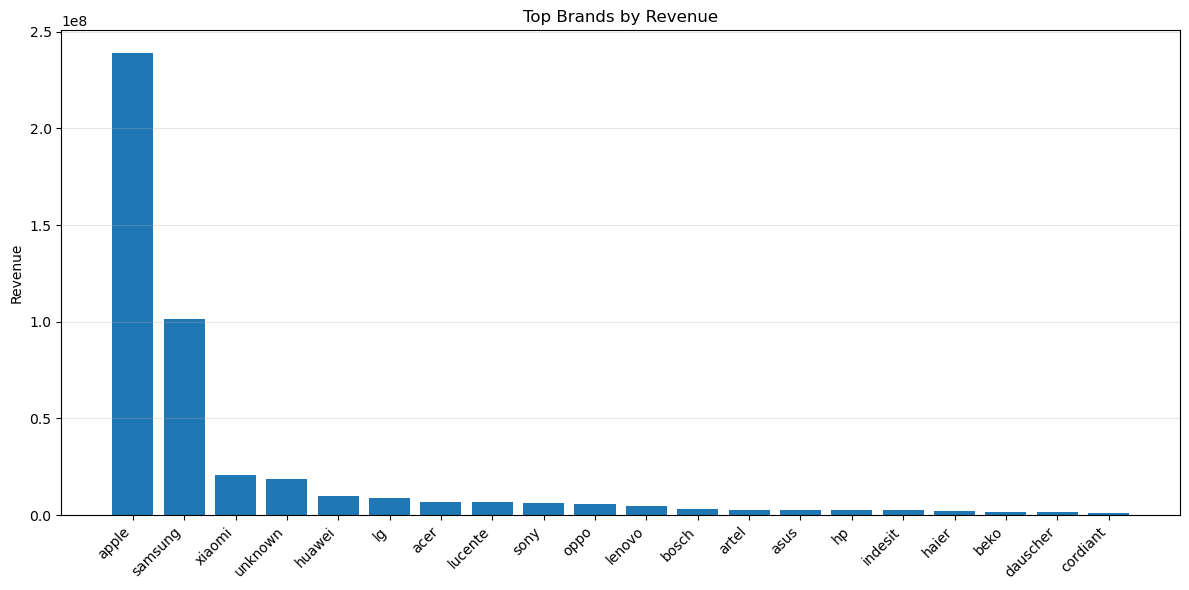

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


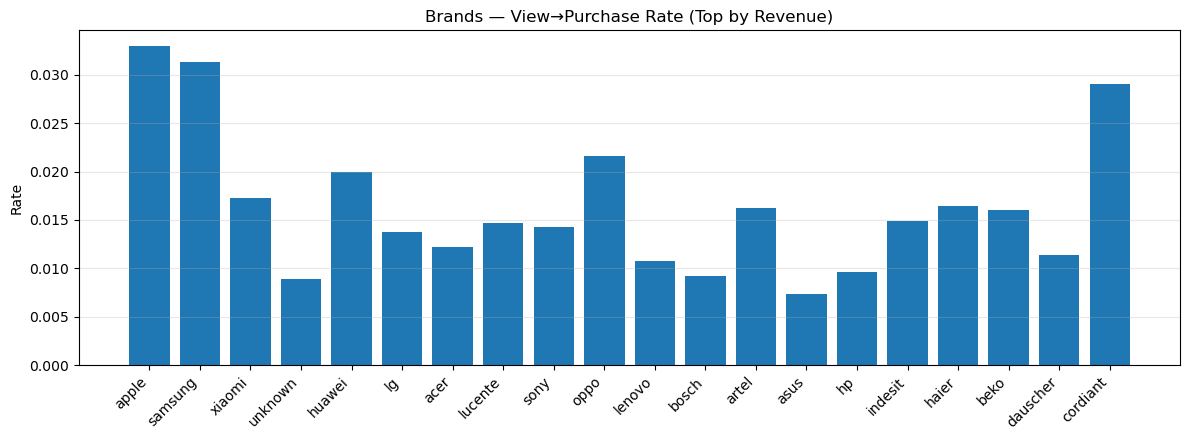

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:127: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha='right')


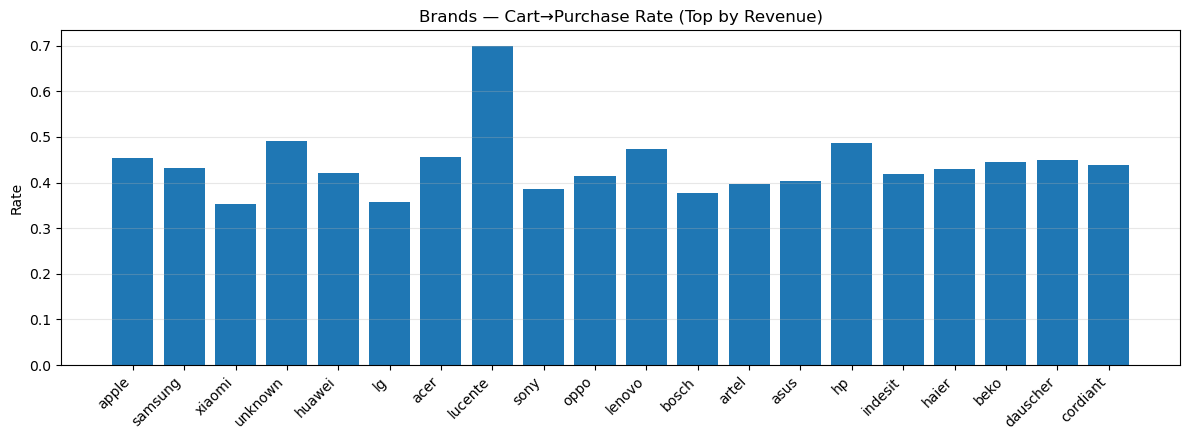

In [47]:
# 2) Brand-level across all files:
agg_brand = aggregate_ecom(ecom, grain='brand')   
plot_agg_top_revenue(agg_brand, top_n=20, title="Top Brands by Revenue");
plot_agg_rates(agg_brand, top_n=20, title_prefix="Brands");


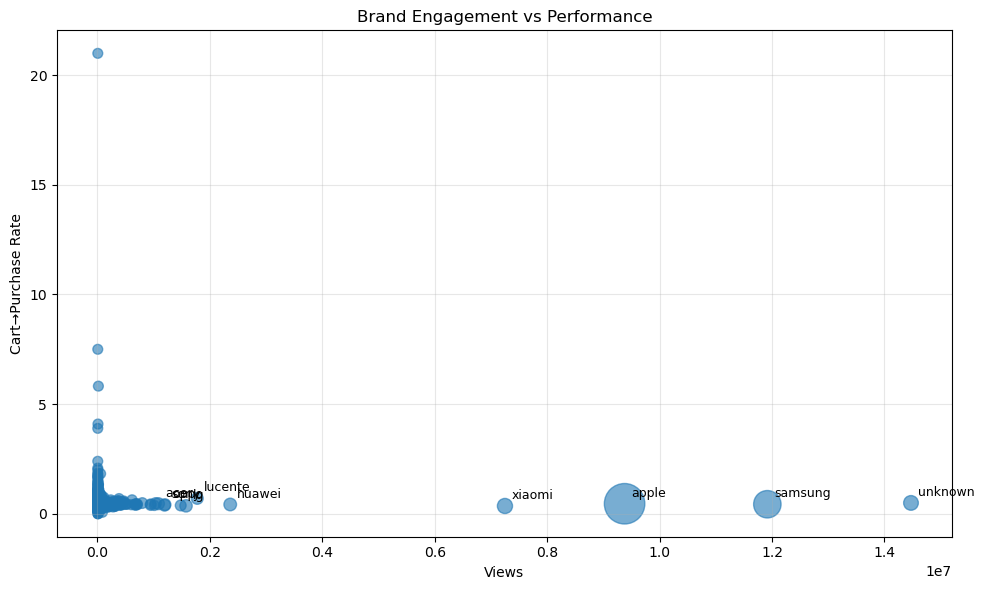

views   carts  purchases       revenue  unique_users  sessions  \
brand                                                                         
apple      9377773  680702     308972  2.387335e+08       2833308   3629115   
samsung   11917174  864696     373291  1.015653e+08       3372685   4294655   
xiaomi     7249605  355299     125072  2.049166e+07       1803792   2399681   
unknown   14472418  260550     128220  1.851540e+07       3643202   4650666   
huawei     2362460  112196      47228  9.681976e+06        735129    889709   
lg         1576420   60312      21609  8.628522e+06        486873    579194   
acer       1085967   29098      13304  6.931540e+06        303677    381192   
lucente    1776446   37411      26142  6.651838e+06        521543    619772   
sony       1194261   44051      17041  6.343440e+06        411492    485101   
oppo       1203390   62721      25967  5.900575e+06        394154    463104   
lenovo     1035571   23577      11183  4.472363e+06        262500    337448   
bosch      1481883   36384      13721  3.082278e+06        454594    533197   
artel       947430   38799      15390  2.676070e+06        306501    360034   
asus        672621   12248       4932  2.649307e+06        189622    243070   
hp          798568   15878       7716  2.578893e+06        236378    289873   
indesit     683299   24342      10211  2.557000e+06        209427    246393   
haier       421401   16114       6923  2.003871e+06        172812    192884   
beko        489628   17628       7843  1.867865e+06        188410    215551   
dauscher    681143   17263       7761  1.480874e+06        254736    291397   
cordiant    947207   62741      27534  1.304972e+06        413997    478607   

                 aov  v2p_rate  c2p_rate  
brand                                     
apple     772.670452  0.032947  0.453902  
samsung   272.080788  0.031324  0.431702  
xiaomi    163.838943  0.017252  0.352019  
unknown   144.403346  0.008860  0.492113  
huawei    205.005006  0.019991  0.420942  
lg        399.302257  0.013708  0.358287  
acer      521.011754  0.012251  0.457214  
lucente   254.450246  0.014716  0.698778  
sony      372.245789  0.014269  0.386847  
oppo      227.233594  0.021578  0.414008  
lenovo    399.925122  0.010799  0.474318  
bosch     224.639465  0.009259  0.377116  
artel     173.883705  0.016244  0.396660  
asus      537.166876  0.007333  0.402678  
hp        334.226660  0.009662  0.485955  
indesit   250.416245  0.014944  0.419481  
haier     289.451284  0.016429  0.429626  
beko      238.156893  0.016018  0.444917  
dauscher  190.809729  0.011394  0.449574  
cordiant   47.394932  0.029069  0.438852

In [48]:
plot_agg_brand_bubbles(agg_brand, min_views=5000)
agg_brand.head(20)

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/2283917638.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


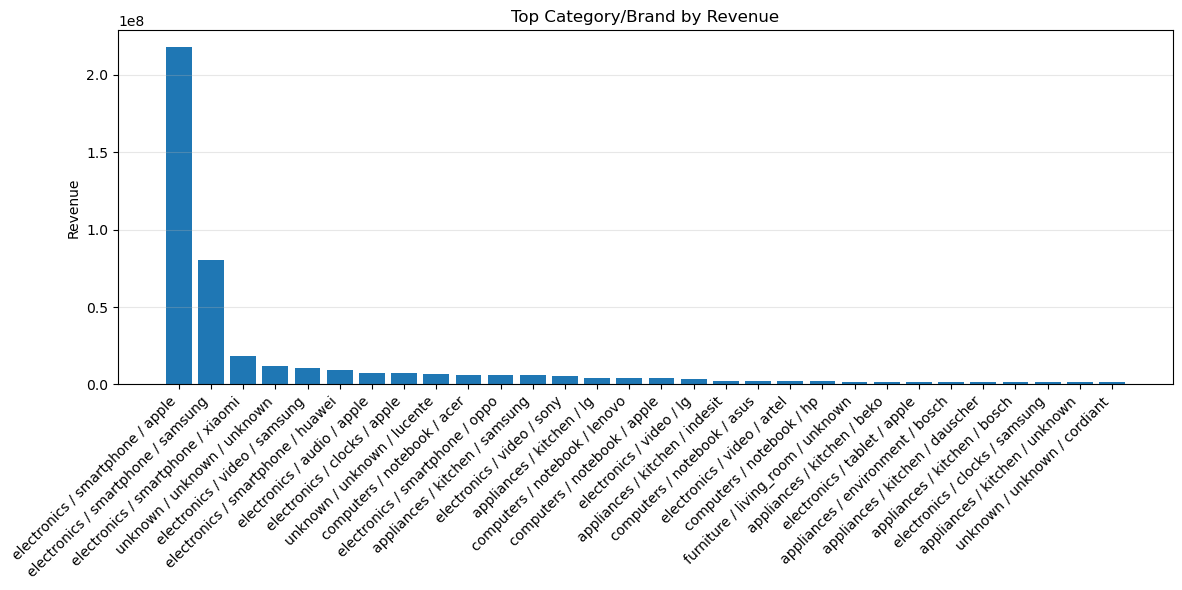

views   carts  purchases       revenue  \
department  product_group brand                                               
electronics smartphone    apple    7225288  524880     243297  2.178592e+08   
                          samsung  8366265  687857     307815  8.049795e+07   
                          xiaomi   6006781  306125     107846  1.864049e+07   
unknown     unknown       unknown  8865656  167504      86122  1.213448e+07   
electronics video         samsung  1083141   57562      20905  1.083051e+07   
            smartphone    huawei   2136694  104503      43984  9.294246e+06   
            audio         apple    1059278  106839      43383  7.696781e+06   
            clocks        apple     611799   37097      17193  7.427955e+06   
unknown     unknown       lucente  1776446   37411      26142  6.651838e+06   
computers   notebook      acer      833118   25100      11454  6.219483e+06   
electronics smartphone    oppo     1203390   62721      25967  5.900575e+06   
appliances  kitchen       samsung   982165   40728      15397  5.852442e+06   
electronics video         sony      812027   36091      13588  5.529187e+06   
appliances  kitchen       lg        767090   29613      10559  4.339182e+06   
computers   notebook      lenovo    850311   20141       9834  4.096418e+06   
                          apple     248216    5811       2463  3.903550e+06   
electronics video         lg        584901   23551       8621  3.830551e+06   
appliances  kitchen       indesit   683259   24341      10210  2.556749e+06   
computers   notebook      asus      559750   10701       4323  2.495522e+06   
electronics video         artel     710359   30815      11435  2.109600e+06   

                                   unique_users  sessions          aov  \
department  product_group brand                                          
electronics smartphone    apple         2203928   2789470   895.445663   
                          samsung       2405679   3058466   261.514044   
                          xiaomi        1428370   1921346   172.843590   
unknown     unknown       unknown       2390000   2955608   140.898698   
electronics video         samsung        329376    389931   518.082123   
            smartphone    huawei         648201    787651   211.309698   
            audio         apple          429442    511022   177.414677   
            clocks        apple          248234    287213   432.033685   
unknown     unknown       lucente        521543    619772   254.450246   
computers   notebook      acer           226275    284916   542.996592   
electronics smartphone    oppo           394154    463104   227.233594   
appliances  kitchen       samsung        305558    358804   380.102724   
electronics video         sony           285405    335246   406.916938   
appliances  kitchen       lg             236480    280087   410.946328   
computers   notebook      lenovo         202788    265511   416.556602   
                          apple           87473    101653  1584.876192   
electronics video         lg             186451    219322   444.327899   
appliances  kitchen       indesit        209404    246369   250.416113   
computers   notebook      asus           147963    190553   577.266162   
electronics video         artel          240468    280205   184.486265   

                                   v2p_rate  c2p_rate  
department  product_group brand                        
electronics smartphone    apple    0.033673  0.463529  
                          samsung  0.036792  0.447499  
                          xiaomi   0.017954  0.352294  
unknown     unknown       unknown  0.009714  0.514149  
electronics video         samsung  0.019300  0.363174  
            smartphone    huawei   0.020585  0.420887  
            audio         apple    0.040955  0.406060  
            clocks        apple    0.028102  0.463461  
unknown     unknown       lucente  0.014716  0.698778  
computers   notebook      acer     0.013748  0.456335

In [49]:
# 3) Category×Brand drilldown:
agg_cat_brand = aggregate_ecom(ecom, grain='category_brand', cat_cols=['department','product_group'])
plot_agg_top_revenue(agg_cat_brand, top_n=30, title="Top Category/Brand by Revenue")
agg_cat_brand.head(20)

### Distributions

In [50]:
sns.set(style="whitegrid")

def to_frame(data, columns=None):
    """
    Concatenate and keep ONLY purchase rows (is_purchase == 1).
    `columns` lets you select which columns to keep (defaults cover common use).
    """
    default_cols = ['is_purchase', 'rev', 'department', 'brand', 'product_group']
    cols = columns or default_cols

    if isinstance(data, dict):
        parts = [df.loc[df['is_purchase'] == 1, cols] for df in data.values()]
        return pd.concat(parts, ignore_index= False)
    else:
        return data.loc[data['is_purchase'] == 1, cols].copy() 


def boxplot_by_group_sorted(
    df: pd.DataFrame,
    group_cols: list[str],
    *,
    value_col: str = 'rev',
    purchase_only: bool = True,
    title: str | None = None,
    ylim: tuple[float, float] | None = None,
    showfliers: bool = False,
    top: int | None = None,          
):
    """
    - Groups by `group_cols`, computes mean/var of `value_col`
    - Sorts groups by mean (desc); if `top` is provided, keeps top-N
    - Plots a seaborn boxplot in that order
    - Returns sorted stats table (mean/var/count)
    """
    d = df.copy()
    if purchase_only:
        d = d[d['is_purchase'] > 0]

    # Single label for plotting (e.g., "Dept / Brand")
    if len(group_cols) == 1:
        d['group_label'] = d[group_cols[0]].astype(str)
        x_label = group_cols[0].title()
    else:
        d['group_label'] = d[group_cols].astype(str).agg(' / '.join, axis=1)
        x_label = ' / '.join(group_cols).title()

    # mean/var/count per group
    stats = (
        d.groupby('group_label')[value_col]
         .agg(mean='mean', var='var', n='size')
         .reset_index()
    )

    # sort by mean desc and optionally take top-N
    stats_sorted = stats.sort_values('mean', ascending=False).reset_index(drop=True)
    if isinstance(top, int) and top > 0:
        stats_sorted = stats_sorted.head(top)

    order = stats_sorted['group_label'].tolist()
    d_plot = d[d['group_label'].isin(order)]

    # Boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=d_plot, x='group_label', y=value_col, order=order, showfliers=showfliers)
    plt.xticks(rotation=45, ha='right')
    plt.title(title or f"Distribution of {value_col} by {x_label} (sorted by mean)")
    plt.ylabel(value_col.replace('_', ' ').title())
    plt.xlabel(x_label)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.tight_layout()
    plt.show()

    # return a tidy table with clearer column names
    return stats_sorted.rename(columns={'mean': f'mean_{value_col}', 'var': f'var_{value_col}'})


In [51]:
df_all = to_frame(ecom)

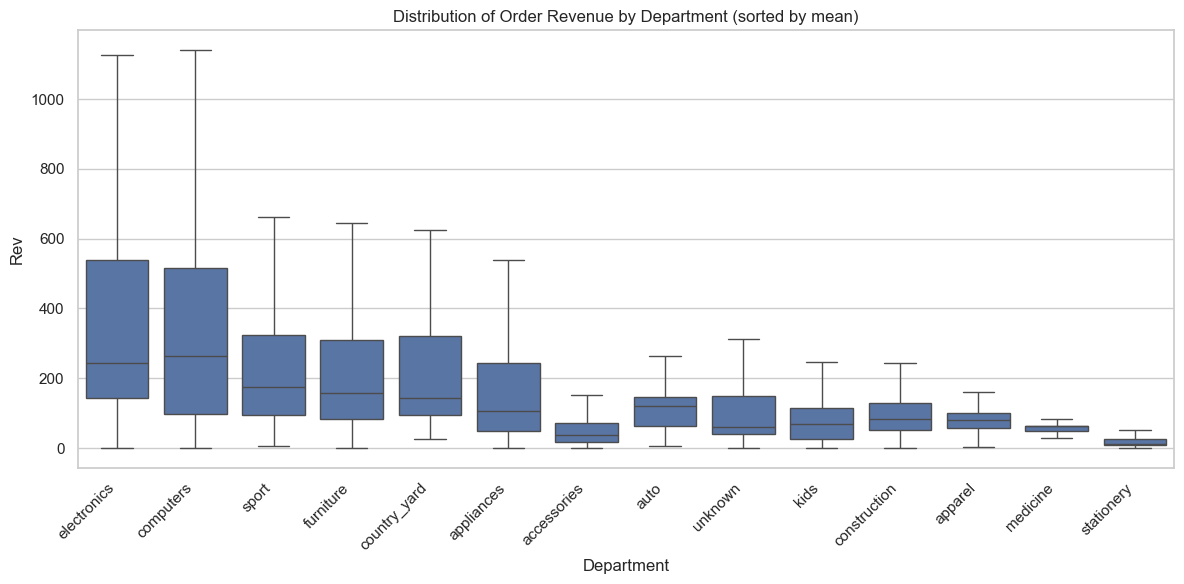

In [52]:
# 1) Department
dept_stats = boxplot_by_group_sorted(df_all, group_cols=['department'],
                                      value_col='rev', purchase_only=True,
                                      title='Distribution of Order Revenue by Department (sorted by mean)',
                                      showfliers=False)

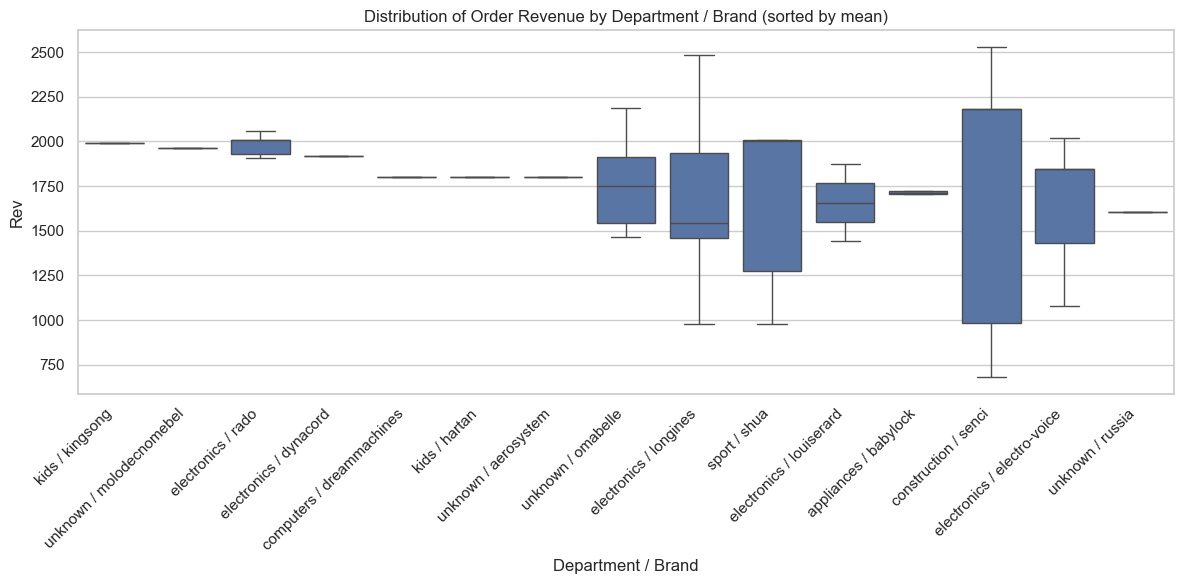

In [53]:
# 2) Department + Brand
dept_brand_stats = boxplot_by_group_sorted(df_all,group_cols=['department','brand'], value_col='rev', 
                                            purchase_only=True, title='Distribution of Order Revenue by Department / Brand (sorted by mean)',
                                            showfliers=False, top = 15)


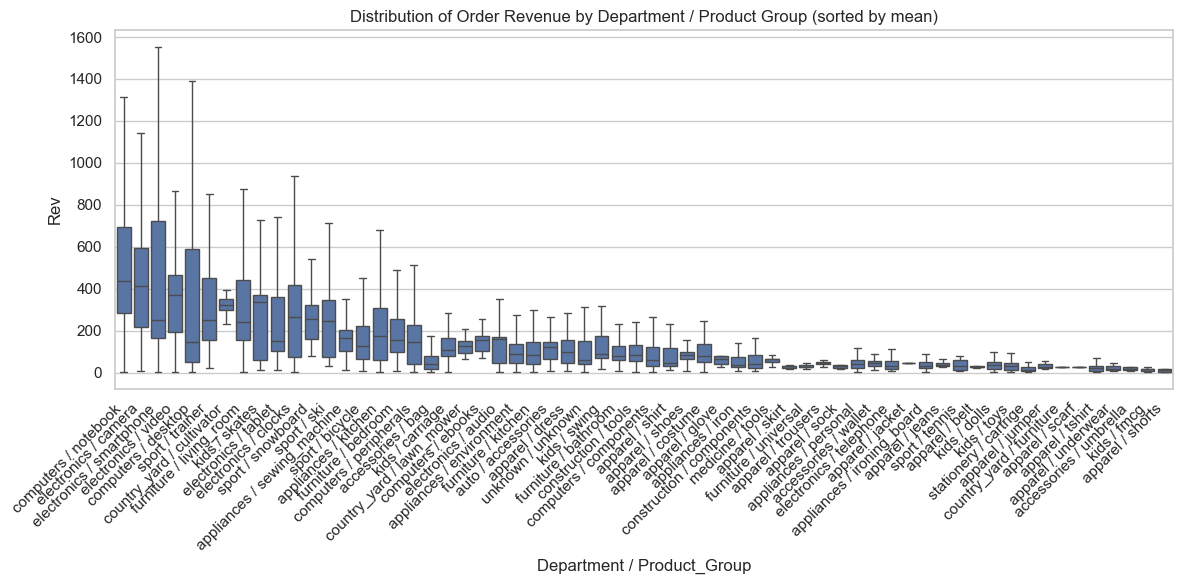

In [54]:
# 3) Department + Product Group
dept_pg_stats = boxplot_by_group_sorted(df_all, group_cols=['department','product_group'], value_col='rev',
                                         purchase_only=True, title='Distribution of Order Revenue by Department / Product Group (sorted by mean)',
                                         showfliers=False)

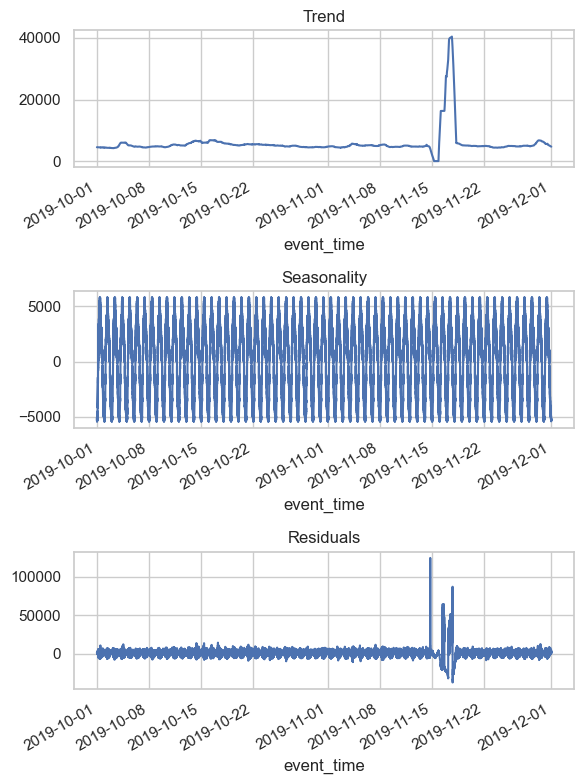

In [55]:
decomposed = seasonal_decompose(forecasting['rev'], model='additive', period=1440, extrapolate_trend='freq')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### EDA Summary Sales Analysis (Oct–Nov 2019) 

## Overview
- **Period:** October 1 – November 30 , 2019  
- **Granularity:** Hourly and Daily Aggregations  
- **Metrics:** `views`, `carts`, `purchases`, `revenue`, `unique_users`, `sessions`, `aov`, `v2p_rate`, `c2p_rate`  
- **Focus:** User behavior trends, conversion efficiency, and revenue segmentation by department, product group, and brand.

---

## Time-Series Decomposition
- **Trend:**  
  - Stable baseline activity through October with a sharp **spike in mid-November**, reflecting a major sales or promotional event.  
  - After the spike, activity returned to pre-event levels—suggesting a **short-term surge** rather than sustained growth.
- **Seasonality:**  
  - Strong **daily periodicity** indicates predictable cycles of user engagement and purchasing.  
  - Seasonal amplitude remains consistent, showing habitual hourly behaviors (morning and late-afternoon peaks).
- **Residuals:**  
  - High variance around **Nov 15–18** reveals large, short-lived deviations during campaign days.  
  - Outside this window, residuals remain near zero, confirming a **stable forecasting baseline**.

---

## Hourly Behavioral Insights
### Average Activity by Hour
- **Views** peak between **15:00 – 16:00**, showing late-afternoon browsing behavior.  
- **Purchases** peak earlier, around **09:00**, suggesting users browse later but **buy in the morning**.  
- Indicates a **morning-to-afternoon conversion funnel**—users likely finalize purchases after earlier product consideration.

### Revenue by Hour
- **Revenue peaks at 09:00**, aligning with purchase peaks.  
- Morning hours (08:00 – 10:00) generate the majority of daily sales volume, emphasizing early-day purchase intent.

### Purchases Heatmap by Day × Hour
- **Weekend concentration:** Saturdays and Sundays exhibit the highest purchase densities between **08:00 – 14:00**.  
- **Weekday traffic** is steadier but less intense, showing consistent business-hour engagement.  
- Confirms **temporal segmentation**—weekend shoppers are more impulsive, weekday users more habitual.

---

## Revenue and Conversion Overview
- **Average Revenue:** \\$6–9 M/day, peaking above \\$50 M during mid-November promotions.  
- **AOV (Average Order Value):** Steady at \\$285–\\$330, reflecting consistent customer spending despite traffic spikes.  
- **Conversion Rates:**  
  - **v2p_rate:** ≈ 1.5 % overall, dips below 1 % during high-volume campaigns.  
  - **c2p_rate:** ≈ 0.6–1.3 , but declines sharply during sales events due to **cart abandonment**.

---

## Product-Level Insights (Department × Product Group)
| Department | Product Group | Key Metrics | Observations |
|-------------|----------------|--------------|--------------|
| **Electronics – Smartphone** | Views 26.7 M  · Purchases 745 K  · Revenue \\$335.8 M  · AOV \\$450 | Highest revenue driver; strong engagement and moderate conversion. |
| **Electronics – Video** | Views 4.2 M  · Purchases 69 K  · Revenue \\$26.5 M  · AOV \\$379 | Niche audience; high ticket items with solid margins. |
| **Computers – Notebook** | Views 3.2 M  · Purchases 34 K  · Revenue \\$19.7 M  · AOV \\$572 | Premium segment with strong AOV and moderate conversion. |
| **Appliances – Kitchen** | Views 10.4 M  · Purchases 128 K  · Revenue \\$26.7 M  · AOV \\$209 | Mid-range products with stable daily performance. |
| **Apparel – Shoes** | Views 3.8 M  · Purchases 20 K  · Revenue \\$1.9 M  · AOV \\$92 | Low AOV, high browsing volume, suggesting exploration-heavy traffic. |
| **Kids – Carriage** | Views 0.6 M  · Purchases 5.6 K  · AOV \\$162 | Niche but consistent category; high repeat behavior potential. |

---

## Brand-Level Highlights
| Brand | Views | Purchases | Revenue | AOV | Insights |
|--------|--------|-----------|----------|------|-----------|
| **Apple** | 9.4 M | 309 K | \\$238.7 M | \\$773 | Dominates premium segment; strong brand-driven conversions. |
| **Samsung** | 11.9 M | 373 K | \\$101.6 M | \\$272 | High-volume mid-tier sales; strong daily consistency. |
| **Xiaomi** | 7.2 M | 125 K | \\$20.5 M | \\$164 | Price-competitive option; good conversion for budget shoppers. |
| **Huawei** | 2.4 M | 47 K | \\$9.7 M | \\$205 | Consistent but moderate performance within smartphones. |
| **LG & Sony** | 1.5 M & 1.2 M views | 21 K & 17 K purchases | \\$8.6 M & \\$6.3 M | AOV ≈ \\$400 | Strong electronics categories with balanced margins. |
| **Lucente (Home Brand)** | 1.8 M views | 26 K purchases | \\$6.6 M | AOV \\$254 | High cart-to-purchase rate (≈ 0.70), strong internal brand traction. |

---

## Combined Department–Product–Brand Observations
- **Apple Smartphones**: Highest revenue contributor (\\$217.8 M) with AOV ≈ \\$895; exceptional loyalty and early-day purchase peaks.  
- **Samsung Smartphones**: High engagement (8.3 M views) and AOV \\$261 — volume-driven growth strategy.  
- **Xiaomi Smartphones**: Competitive AOV (\\$173) and solid conversion (1.8 %), ideal for price-sensitive segments.  
- **LG & Sony Video**: AOV\ \$400 +, steady traffic with balanced profitability.  
- **Kitchen Appliances (Samsung / LG / Indesit)**: Moderate traffic and revenue, strong weekday performance.  
- **Computers (Asus, Acer, Lenovo)**: High AOV (\\$400 – \\$577) with consistent purchase patterns — valuable for cross-sell opportunities.  

---

## Key Insights
- **Time and behavior alignment:**  
  Morning hours (8–10 AM) yield the highest purchase and revenue activity, while afternoon (3–5 PM) shows peak browsing intent.  
- **Promotional sensitivity:**  
  Mid-November spikes suggest a major sales event or holiday campaign impacting all departments simultaneously.  
- **Category maturity:**  
  Electronics and smartphones dominate revenue; computers and video offer premium growth potential; appliances and apparel remain steady volume drivers.  
- **Behavioral takeaway:**  
  Predictable temporal patterns and stable AOV make this dataset well-suited for **time-series forecasting and behavioral segmentation models**.

---

> **Summary:**  
> Users exhibit consistent cyclical engagement with strong morning purchase tendencies and afternoon browsing peaks.  
> Major revenue is concentrated in **electronics**, especially **Apple and Samsung smartphones**, while brand-loyal and weekend-active segments offer rich predictive potential for future targeting and campaign scheduling.



## Step 3.5: Behavioral Profiling & Segmentation
- Cluster users by engagement levels and session patterns
- Examine product categories with high conversion rates
- Profile sessions by length and outcome (e.g., no action vs. purchase)

### Users Engagement

In [56]:
def shard_session_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Build a session-level table using df.index as UTC event time.
    Requires columns: user_id, user_session, is_view, is_cart, is_purchase, rev.
    """
    d = df.reset_index(names='event_time')  # <- single conversion from index
    g = d.groupby(['user_id','user_session'], observed=True)
    sess = g.agg(
        session_start=('event_time','min'),
        session_end=('event_time','max'),
        events_in_session=('event_time','size'),
        views=('is_view','sum'),
        carts=('is_cart','sum'),
        purchases=('is_purchase','sum'),
        revenue=('rev','sum')
    ).reset_index()
    sess['session_duration_sec'] = (sess['session_end'] - sess['session_start']).dt.total_seconds().astype(float)
    sess['has_purchase'] = (sess['purchases'] > 0).astype(int)
    return sess[['user_id','user_session','session_start','session_end',
                 'session_duration_sec','events_in_session','views','carts','purchases','revenue','has_purchase']]

def shard_user_event_counters(df: pd.DataFrame) -> pd.DataFrame:
    """
    Per-user counters & time-patterns using df.index as UTC time.
    Requires columns: user_id, is_view, is_cart, is_purchase, rev.
    """
    d = df.reset_index(names='event_time')  # <- single conversion from index
    d['hour'] = d['event_time'].dt.hour
    d['dow']  = d['event_time'].dt.dayofweek
    d['is_weekend'] = (d['dow'] >= 5).astype(int)
    d['is_night']   = ((d['hour'] >= 22) | (d['hour'] <= 6)).astype(int)

    g = d.groupby('user_id', observed=True)
    out = g.agg(
        total_views=('is_view','sum'),
        total_carts=('is_cart','sum'),
        total_purchases=('is_purchase','sum'),
        total_revenue=('rev','sum'),
        total_events=('event_time','size'),
        weekend_events=('is_weekend','sum'),
        night_events=('is_night','sum'),
        last_event_time=('event_time','max')
    )
    return out

def build_user_features_from_ecom(ecom: dict, skip_bad_shards: bool = True) -> pd.DataFrame:
    session_parts, counter_parts, errors = [], [], []

    for name, df in ecom.items():
        try:
            session_parts.append(shard_session_table(df))
            counter_parts.append(shard_user_event_counters(df))
        except Exception as e:
            if skip_bad_shards:
                errors.append((name, str(e)))
                continue
            raise

    if not session_parts or not counter_parts:
        raise ValueError("No usable shards to build features.")

    sessions_all = pd.concat(session_parts, ignore_index=True)
    counters_all = pd.concat(counter_parts, axis=0)

    # Combine counters across shards
    counters = counters_all.groupby(level=0, observed=True).agg({
        'total_views':'sum',
        'total_carts':'sum',
        'total_purchases':'sum',
        'total_revenue':'sum',
        'total_events':'sum',
        'weekend_events':'sum',
        'night_events':'sum',
        'last_event_time':'max'
    })

    # Session-derived features
    g = sessions_all.groupby('user_id', observed=True)
    sess_user = g.agg(
        sessions_count=('user_session','nunique'),
        sessions_with_purchase=('has_purchase','sum'),
        median_session_duration_sec=('session_duration_sec','median'),
        p95_session_duration_sec=('session_duration_sec', lambda s: float(np.nanpercentile(s, 95)) if len(s) else np.nan),
        mean_events_per_session=('events_in_session','mean'),
        total_session_revenue=('revenue','sum'),
    )

    feats = counters.join(sess_user, how='outer').fillna(0)

    # Safe rates
    def _safe_rate(num, den):
        den = den.replace(0, np.nan)
        return (num / den).astype(float)

    feats['v2p_rate'] = _safe_rate(feats['total_purchases'], feats['total_views'])
    feats['c2p_rate'] = _safe_rate(feats['total_purchases'], feats['total_carts'])
    feats['sessions_purchase_share'] = _safe_rate(feats['sessions_with_purchase'], feats['sessions_count'])
    feats['pct_weekend_events'] = _safe_rate(feats['weekend_events'], feats['total_events'])
    feats['pct_night_events']   = _safe_rate(feats['night_events'], feats['total_events'])

    # Recency (days since global most recent event)
    global_last = feats['last_event_time'].max()
    feats['recency_days'] = (global_last - feats['last_event_time']).dt.total_seconds() / (24*3600)
    feats['recency_days'] = feats['recency_days'].fillna(feats['recency_days'].max() or 0)

    # Final feature set
    feature_cols = [
        'total_views','total_carts','total_purchases','total_revenue',
        'sessions_count','sessions_purchase_share',
        'median_session_duration_sec','p95_session_duration_sec','mean_events_per_session',
        'pct_weekend_events','pct_night_events','recency_days'
    ]
    feats = feats[feature_cols].fillna(0)

    if errors:
        print("Skipped shards while building features:")
        for k, msg in errors:
            print(f" - {k}: {msg}")

    return feats


def cluster_users(features: pd.DataFrame, k: int = 5, random_state: int = 42):
    # Light log1p on skewed columns
    skew_cols = ['total_views','total_carts','total_purchases','total_revenue',
                 'sessions_count','median_session_duration_sec','p95_session_duration_sec',
                 'mean_events_per_session','recency_days']
    X = features.copy()
    for c in skew_cols:
        if c in X.columns:
            X[c] = np.log1p(X[c].astype(float))

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X.values), index=X.index, columns=X.columns)

    km = KMeans(n_clusters=k, random_state=random_state, n_init=20)
    labels = pd.Series(km.fit_predict(X_scaled.values), index=X_scaled.index, name='cluster')

    return X_scaled, km, labels

def summarize_clusters(features: pd.DataFrame, labels: pd.Series) -> pd.DataFrame:
    out = features.copy()
    out['cluster'] = labels
    return out.groupby('cluster').mean(numeric_only=True).sort_index()

def plot_cluster_sizes(labels: pd.Series):
    counts = labels.value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.bar(counts.index.astype(str), counts.values)
    ax.set_title("Cluster Sizes"); ax.set_xlabel("Cluster"); ax.set_ylabel("# Users")
    ax.grid(True, axis='y', alpha=0.3); fig.tight_layout(); plt.show()

def plot_clusters_pca(features_scaled: pd.DataFrame, labels: pd.Series):
    pca = PCA(n_components=2, random_state=42)
    Z = pca.fit_transform(features_scaled.values)
    fig, ax = plt.subplots(figsize=(8, 6))
    for c in sorted(labels.unique()):
        mask = (labels == c).values
        ax.scatter(Z[mask, 0], Z[mask, 1], label=f"Cluster {c}", alpha=0.6)
    ax.set_title("User Clusters — PCA(2)"); ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
    ax.grid(True, alpha=0.3); ax.legend(); fig.tight_layout(); plt.show()

def plot_cluster_feature_means(features: pd.DataFrame, labels: pd.Series, max_features: int = 12):
    summary = summarize_clusters(features, labels)
    cols = list(summary.columns)[:max_features]
    fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(10, 3.2*len(cols)))
    if not isinstance(axes, np.ndarray): axes = np.array([axes])
    for ax, col in zip(axes, cols):
        ax.bar(summary.index.astype(str), summary[col].values)
        ax.set_title(f"Cluster Mean — {col}")
        ax.set_xlabel("Cluster"); ax.set_ylabel(col)
        ax.grid(True, axis='y', alpha=0.3)
    fig.tight_layout(); plt.show()


def cluster_users_from_ecom(ecom: dict, k: int = 5, random_state: int = 42, skip_bad_shards: bool = True):
    """
    End-to-end using your UTC DatetimeIndex:
      features (unscaled), features_scaled, model, labels, cluster_summary
    """
    features = build_user_features_from_ecom(ecom, skip_bad_shards=skip_bad_shards)
    X_scaled, model, labels = cluster_users(features, k=k, random_state=random_state)
    cluster_summary = summarize_clusters(features, labels)
    return features, X_scaled, model, labels, cluster_summary



In [57]:
features, X_scaled, km, labels, summary = cluster_users_from_ecom(ecom, k=5)
summary

python(7340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


total_views  total_carts  total_purchases  total_revenue  \
cluster                                                             
0           1.896604     0.009579         0.000504       0.047465   
1           6.644379     0.097758         0.002560       0.119185   
2          47.077680     0.890817         0.011707       0.340307   
3           8.822449     1.680702         1.694856     544.603293   
4          82.835215     5.114366         2.772970     840.070731   

         sessions_count  sessions_purchase_share  median_session_duration_sec  \
cluster                                                                         
0              1.663458                 0.000124                     0.528272   
1              1.863138                 0.000576                   316.012961   
2              8.902338                 0.001484                   260.663744   
3              2.286286                 0.724642                   373.793120   
4             15.107682                 0.193619                   177.228435   

         p95_session_duration_sec  mean_events_per_session  \
cluster                                                      
0                        7.124026                 1.101500   
1                      579.374800                 4.012495   
2                     1338.090059                 6.532634   
3                      606.511913                 5.787309   
4                     1336.633251                 5.913414   

         pct_weekend_events  pct_night_events  recency_days  
cluster                                                      
0                  0.264753          0.267856     26.132173  
1                  0.286014          0.249285     26.855967  
2                  0.328333          0.235979     10.265146  
3                  0.319118          0.245522     26.029590  
4                  0.359943          0.246637     11.451234

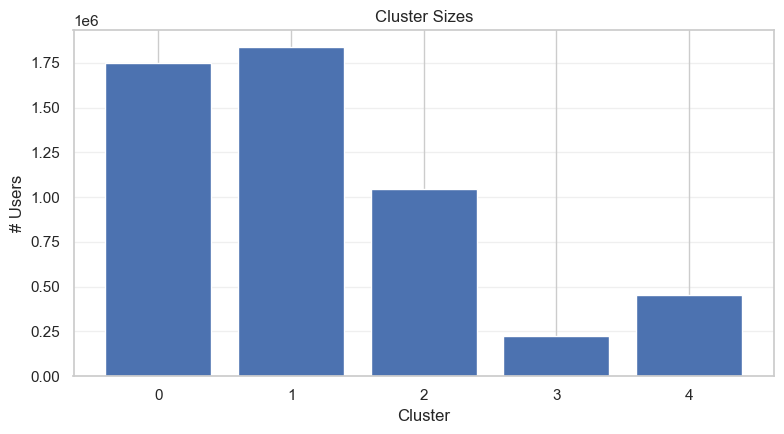

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/1372059176.py:161: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  ax.grid(True, alpha=0.3); ax.legend(); fig.tight_layout(); plt.show()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


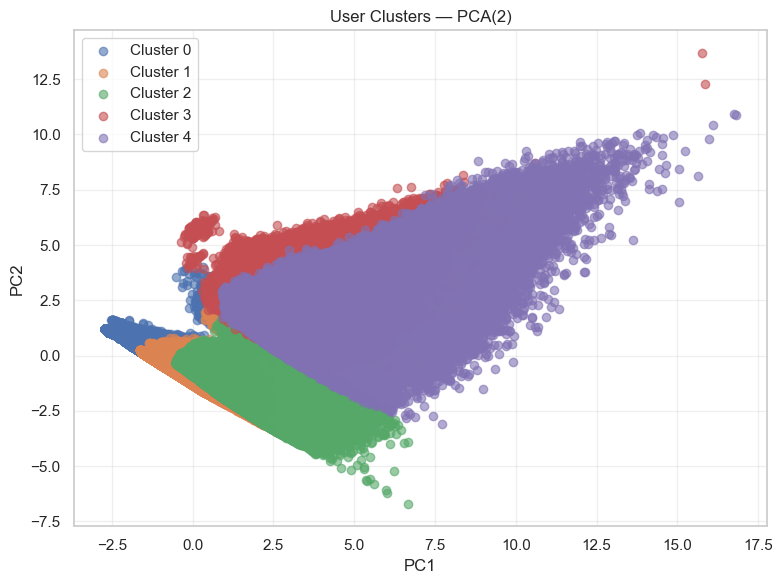

In [58]:
plot_cluster_sizes(labels)
plot_clusters_pca(X_scaled, labels)


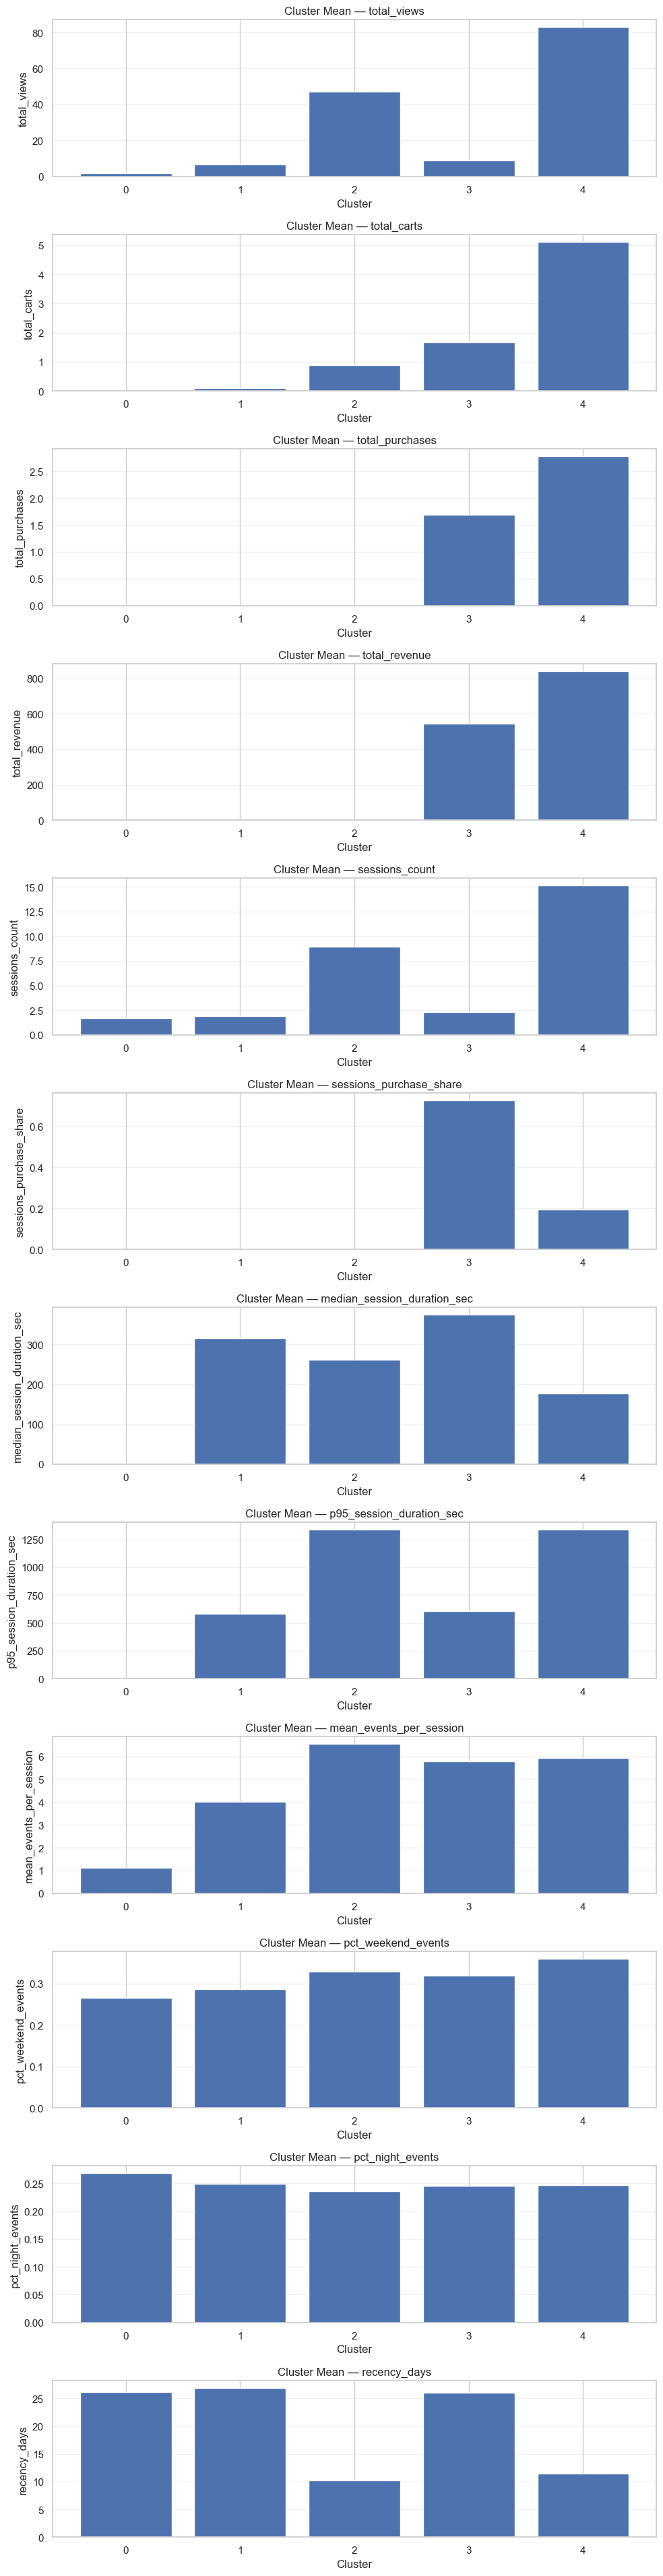

In [59]:
plot_cluster_feature_means(features, labels)

### Product Categories Conversion Rates

In [60]:
# ---------- Pick top high-conversion categories ----------
def top_categories_by_conversion(agg: pd.DataFrame, *, 
                                 min_views: int = 10_000,
                                 min_carts: int = 1_000,
                                 top_n: int = 20):
    """
    Filters out tiny categories and returns two DataFrames:
      - top_v2p: highest view→purchase rate (min_views filter)
      - top_c2p: highest cart→purchase rate (min_carts filter)
    """
    if agg.empty:
        return agg, agg

    vmask = agg['views'] >= min_views
    cmask = agg['carts'] >= min_carts

    top_v2p = (agg[vmask]
               .sort_values(['v2p_rate','revenue'], ascending=[False, False])
               .head(top_n))
    top_c2p = (agg[cmask]
               .sort_values(['c2p_rate','revenue'], ascending=[False, False])
               .head(top_n))
    return top_v2p, top_c2p

# ---------- Visuals ----------
def plot_top_conversion_bars(top_v2p: pd.DataFrame, top_c2p: pd.DataFrame):
    # V2P
    if not top_v2p.empty:
        fig1, ax1 = plt.subplots(figsize=(12, 4.8))
        labels = _labels(top_v2p.index)
        ax1.bar(labels, top_v2p['v2p_rate'])
        ax1.set_title("Top Categories by View→Purchase Rate")
        ax1.set_ylabel("Rate")
        ax1.set_xticklabels(labels, rotation=45, ha='right')
        ax1.grid(True, axis='y', alpha=0.3)
        fig1.tight_layout()
        plt.show()

    # C2P
    if not top_c2p.empty:
        fig2, ax2 = plt.subplots(figsize=(12, 4.8))
        labels = _labels(top_c2p.index)
        ax2.bar(labels, top_c2p['c2p_rate'])
        ax2.set_title("Top Categories by Cart→Purchase Rate")
        ax2.set_ylabel("Rate")
        ax2.set_xticklabels(labels, rotation=45, ha='right')
        ax2.grid(True, axis='y', alpha=0.3)
        fig2.tight_layout()
        plt.show()

def plot_conv_scatter(agg: pd.DataFrame, min_views: int = 10_000):
    """
    Quick sanity scatter: Views vs V2P; bubble = revenue.
    Filters by min_views to reduce noise.
    """
    df = agg[agg['views'] >= min_views].copy()
    if df.empty:
        print("No categories meet min_views filter.")
        return
    fig, ax = plt.subplots(figsize=(10, 6))
    sizes = (df['revenue'] / (df['revenue'].max() or 1.0)) * 600 + 40
    ax.scatter(df['views'], df['v2p_rate'], s=sizes, alpha=0.6)
    ax.set_title("Category Views vs View→Purchase Rate (bubble = revenue)")
    ax.set_xlabel("Views"); ax.set_ylabel("V2P Rate")
    ax.grid(True, alpha=0.3)
    # annotate top 10 by revenue
    top_rev = df.sort_values('revenue', ascending=False).head(10)
    for idx, r in top_rev.iterrows():
        ax.annotate(_labels(pd.Index([idx]))[0], (r['views'], r['v2p_rate']),
                    xytext=(5,5), textcoords='offset points', fontsize=9)
    fig.tight_layout()
    plt.show()


/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/3187568676.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(labels, rotation=45, ha='right')


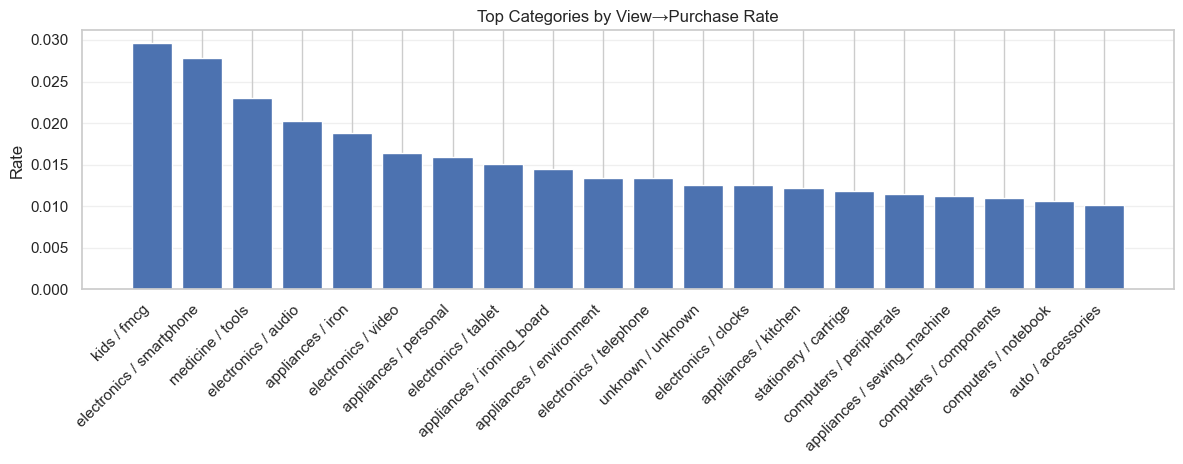

/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_4279/3187568676.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(labels, rotation=45, ha='right')


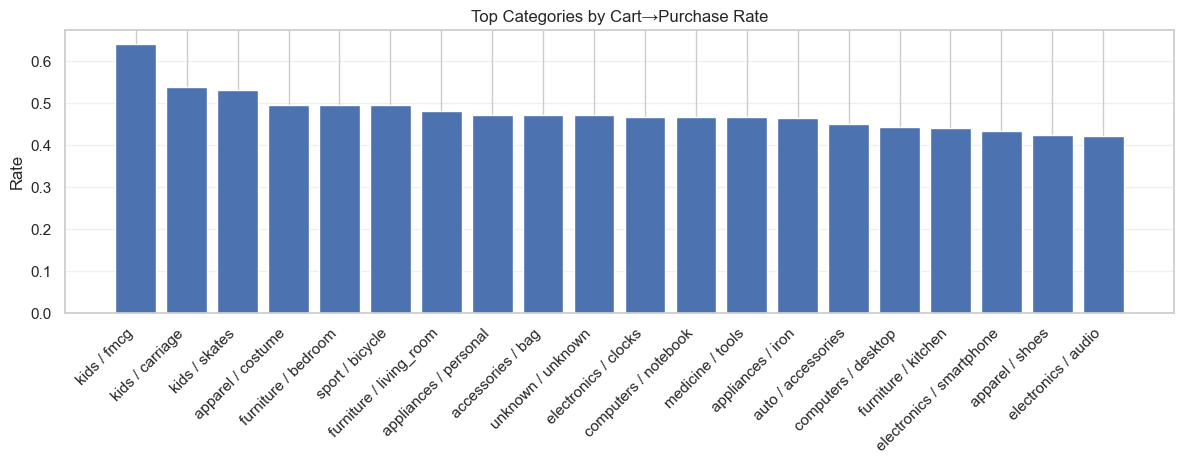

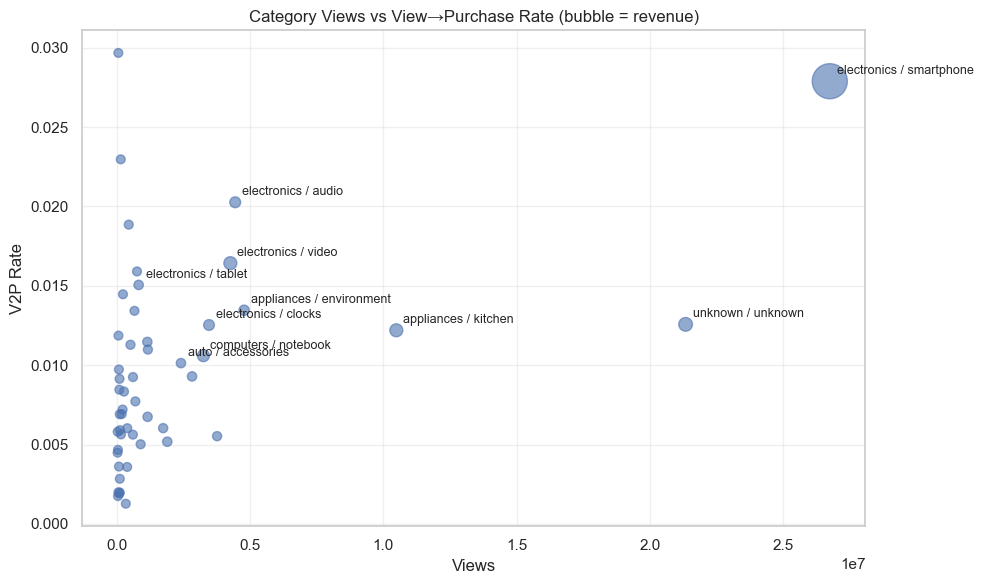

In [61]:
agg_cat = aggregate_ecom(ecom, cat_cols=['department','product_group']) 

top_v2p, top_c2p = top_categories_by_conversion(
    agg_cat, min_views=20000, min_carts=2000, top_n=20
)

plot_top_conversion_bars(top_v2p, top_c2p)
plot_conv_scatter(agg_cat, min_views=20000)

### Session Lengths

In [62]:
def build_sessions_from_ecom(ecom: dict) -> pd.DataFrame:
    parts = []
    for _, df in ecom.items():
        d = df.reset_index(names='event_time')
        g = d.groupby(['user_id','user_session'], observed=True)
        sess = g.agg(
            session_start=('event_time','min'),
            session_end=('event_time','max'),
            events_in_session=('event_time','size'),
            views=('is_view','sum'),
            carts=('is_cart','sum'),
            purchases=('is_purchase','sum'),
            revenue=('rev','sum'),
        ).reset_index()
        sess['session_duration_sec'] = (sess['session_end'] - sess['session_start']).dt.total_seconds().astype(float)
        parts.append(sess)

    if not parts:
        return pd.DataFrame(columns=[
            'user_id','user_session','session_start','session_end',
            'session_duration_sec','events_in_session','views','carts','purchases','revenue'
        ])
    return pd.concat(parts, ignore_index=True)

def label_session_outcome(sess: pd.DataFrame, *, coarse: bool = True) -> pd.DataFrame:
    s = sess.copy()
    if coarse:
        s['outcome'] = np.where(s['purchases'] > 0, 'purchase', 'no_action')
    else:
        s['outcome'] = np.select(
            [s['purchases'] > 0, (s['purchases'] == 0) & (s['carts'] > 0)],
            ['purchase','cart_only'],
            default='view_only'
        )
    return s

def add_duration_bins(sess: pd.DataFrame, bins: list[int] | None = None, labels: list[str] | None = None) -> pd.DataFrame:
    if bins is None:
        bins = [0, 60, 180, 300, 600, 1800, 3600, 7200, np.inf]  # 0–1m, 1–3m, 3–5m, 5–10m, 10–30m, 30–60m, 1–2h, 2h+
    if labels is None:
        labels = ["0–1m","1–3m","3–5m","5–10m","10–30m","30–60m","1–2h","2h+"]
    s = sess.copy()
    s['duration_bin'] = pd.cut(s['session_duration_sec'], bins=bins, labels=labels, right=False, include_lowest=True)
    return s

def summarize_sessions_by_length(sess: pd.DataFrame) -> pd.DataFrame:
    g = sess.groupby('duration_bin', observed=True)
    agg = g.agg(
        sessions=('user_session','count'),
        purchases=('purchases','sum'),
        median_events=('events_in_session','median'),
        avg_revenue_per_session=('revenue','mean'),
        median_duration_sec=('session_duration_sec','median'),
    )
    conv = g['purchases'].apply(lambda s: (s > 0).mean()).rename('conversion_rate')
    outcome_share = (sess.pivot_table(index='duration_bin', columns='outcome', values='user_session',
                                      aggfunc='count', fill_value=0, observed=True))
    outcome_share = outcome_share.div(outcome_share.sum(axis=1), axis=0)
    outcome_share.columns = [f"share_{c}" for c in outcome_share.columns]
    return agg.join(conv).join(outcome_share).sort_index()

def plot_conversion_by_duration(summary: pd.DataFrame, title: str = "Session Conversion Rate by Length"):
    fig, ax = plt.subplots(figsize=(10, 4.5))
    summary['conversion_rate'].plot(kind='bar', ax=ax)
    ax.set_title(title); ax.set_xlabel("Session Length"); ax.set_ylabel("Conversion Rate")
    ax.grid(True, axis='y', alpha=0.3); fig.tight_layout(); plt.show()

def plot_outcome_stack_by_duration(sess: pd.DataFrame, title: str = "Session Outcomes by Length (share)"):
    share = (sess.pivot_table(index='duration_bin', columns='outcome', values='user_session',
                              aggfunc='count', fill_value=0, observed=True))
    share = share.div(share.sum(axis=1), axis=0).sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    bottom = None
    for col in share.columns:
        ax.bar(share.index.astype(str), share[col].values, bottom=bottom, label=col)
        bottom = share[col].values if bottom is None else bottom + share[col].values
    ax.set_title(title); ax.set_xlabel("Session Length"); ax.set_ylabel("Share of Sessions")
    ax.legend(); ax.grid(True, axis='y', alpha=0.3); fig.tight_layout(); plt.show()

def plot_revenue_by_duration(summary: pd.DataFrame, title: str = "Average Revenue per Session by Length"):
    fig, ax = plt.subplots(figsize=(10, 4.5))
    summary['avg_revenue_per_session'].plot(kind='bar', ax=ax)
    ax.set_title(title); ax.set_xlabel("Session Length"); ax.set_ylabel("Avg Revenue / Session")
    ax.grid(True, axis='y', alpha=0.3); fig.tight_layout(); plt.show()


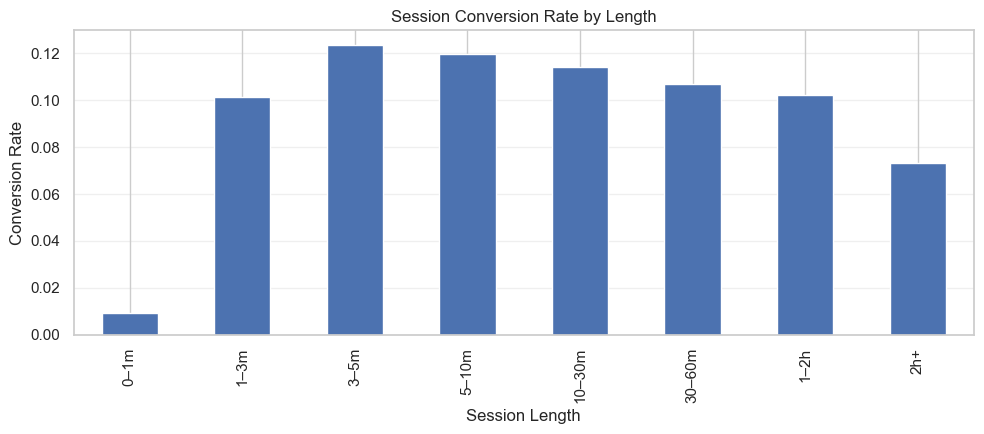

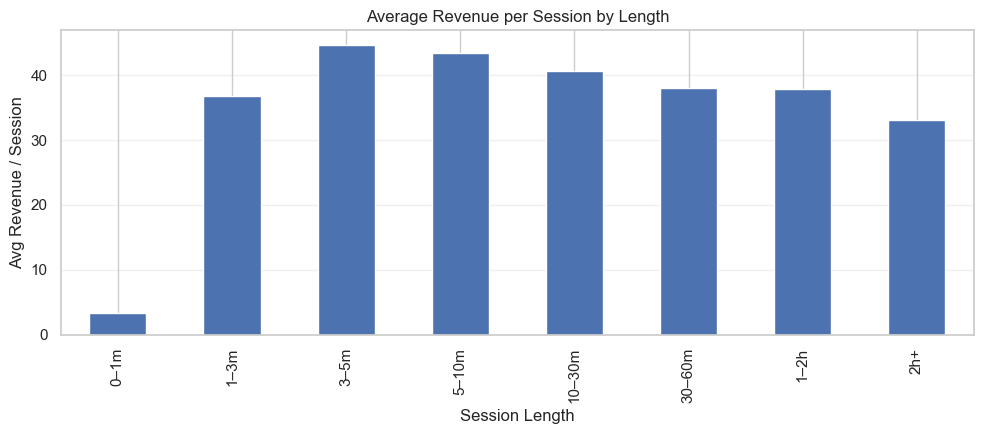

sessions  purchases  median_events  avg_revenue_per_session  \
duration_bin                                                                
0–1m          11532779     108285            1.0                 3.283138   
1–3m           4048858     431752            3.0                36.719635   
3–5m           2098453     297249            5.0                44.653964   
5–10m          2482978     370370            7.0                43.379406   
10–30m         2162312     336129           12.0                40.588083   
30–60m          479782      73720           18.0                38.081163   
1–2h            216426      31554           13.0                37.883223   
2h+              88968      10644            8.0                33.067785   

              median_duration_sec  conversion_rate  share_no_action  \
duration_bin                                                          
0–1m                          0.0         0.009373         0.990627   
1–3m                        108.0         0.101475         0.898525   
3–5m                        231.0         0.123617         0.876383   
5–10m                       414.0         0.119831         0.880169   
10–30m                      906.0         0.114258         0.885742   
30–60m                     2369.0         0.107124         0.892876   
1–2h                       4798.0         0.102303         0.897697   
2h+                       10853.0         0.073105         0.926895   

              share_purchase  
duration_bin                  
0–1m                0.009373  
1–3m                0.101475  
3–5m                0.123617  
5–10m               0.119831  
10–30m              0.114258  
30–60m              0.107124  
1–2h                0.102303  
2h+                 0.073105

In [63]:
sessions = build_sessions_from_ecom(ecom)                  
sessions = label_session_outcome(sessions, coarse=True)   
sessions = add_duration_bins(sessions)                     
summary  = summarize_sessions_by_length(sessions)

plot_conversion_by_duration(summary)
plot_revenue_by_duration(summary)
summary

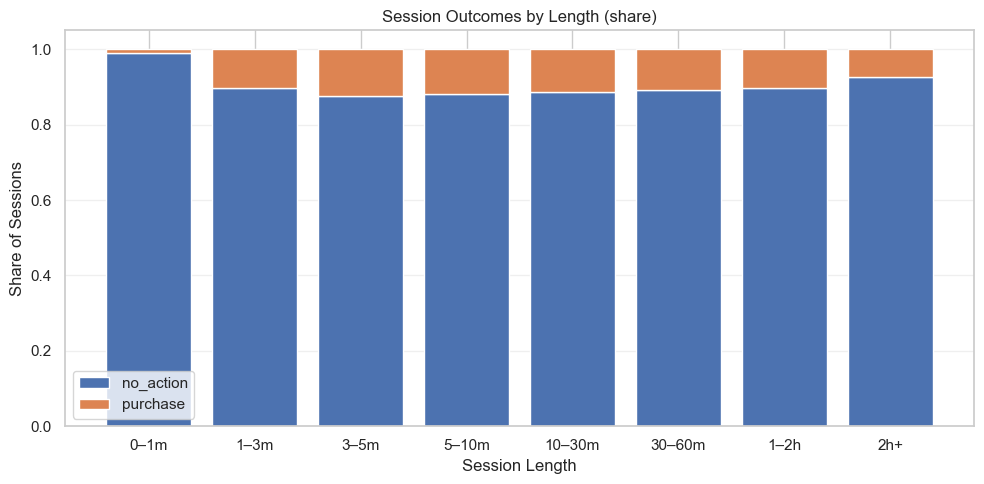

user_id                          user_session  \
0         125917727  1aec8678-85a0-4e8f-b0e2-28abcf662d30   
1         125917727  5bf19e97-c9df-45b4-a7cf-dd662ced7e08   
2         128968633  0750ddba-2b41-489c-af1c-711dcf3d78e8   
3         128968633  7a9658e7-e552-4b0c-8d36-3b51e89537cf   
4         128968633  bca97516-2d5e-4b39-bfa9-515418490eb1   
...             ...                                   ...   
23110551  563865337  3d8f28dc-75b3-4fea-9c93-9a8f7289dc81   
23110552  563865389  cdef2e6b-932d-4945-a0c5-de1e6780854d   
23110553  563865398  fb7ba26d-633a-48a6-96c8-87cda517e058   
23110554  563865440  0af6594a-9801-48be-b58e-7dde3cf61e45   
23110555  563865443  1a016eb6-f810-47d9-b94f-82d53510b4e4   

                     session_start               session_end  \
0        2019-11-10 17:25:48+00:00 2019-11-10 17:25:48+00:00   
1        2019-11-10 16:50:18+00:00 2019-11-10 16:50:18+00:00   
2        2019-11-10 13:10:26+00:00 2019-11-10 13:10:26+00:00   
3        2019-11-10 11:17:57+00:00 2019-11-10 11:17:57+00:00   
4        2019-11-10 12:49:05+00:00 2019-11-10 12:49:05+00:00   
...                            ...                       ...   
23110551 2019-10-24 23:58:07+00:00 2019-10-24 23:58:28+00:00   
23110552 2019-10-24 23:58:37+00:00 2019-10-24 23:58:37+00:00   
23110553 2019-10-24 23:58:40+00:00 2019-10-24 23:58:40+00:00   
23110554 2019-10-24 23:59:09+00:00 2019-10-24 23:59:09+00:00   
23110555 2019-10-24 23:59:08+00:00 2019-10-24 23:59:16+00:00   

          events_in_session  views  carts  purchases  revenue  \
0                         1      1      0          0      0.0   
1                         1      1      0          0      0.0   
2                         1      1      0          0      0.0   
3                         1      1      0          0      0.0   
4                         1      1      0          0      0.0   
...                     ...    ...    ...        ...      ...   
23110551                  2      2      0          0      0.0   
23110552                  1      1      0          0      0.0   
23110553                  1      1      0          0      0.0   
23110554                  1      1      0          0      0.0   
23110555                  2      2      0          0      0.0   

          session_duration_sec    outcome duration_bin  
0                          0.0  no_action         0–1m  
1                          0.0  no_action         0–1m  
2                          0.0  no_action         0–1m  
3                          0.0  no_action         0–1m  
4                          0.0  no_action         0–1m  
...                        ...        ...          ...  
23110551                  21.0  no_action         0–1m  
23110552                   0.0  no_action         0–1m  
23110553                   0.0  no_action         0–1m  
23110554                   0.0  no_action         0–1m  
23110555                   8.0  no_action         0–1m  

[23110556 rows x 12 columns]

In [64]:
plot_outcome_stack_by_duration(sessions)
sessions

## Behavioral Segmentation Analysis Summary


### Overview
Behavioral segmentation was performed to group users by engagement intensity, purchase activity, and session-level patterns.  
Principal Component Analysis (PCA) was applied to reduce multi-dimensional behavioral data into two main components:

- **PC1 (Horizontal Axis):** Represents engagement intensity — increasing with higher views, purchases, and revenue.
- **PC2 (Vertical Axis):** Represents activity diversity — variation in session duration, frequency, and event richness.

The resulting clusters (below) represent distinct behavioral personas in the customer base.

![User Clusters — PCA(2)]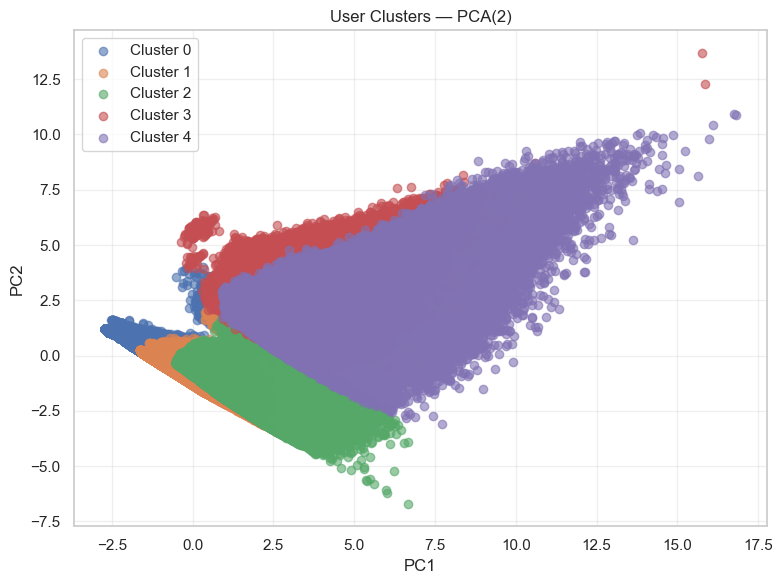

---

### Cluster Profiles

| Cluster | Key Characteristics | Behavioral Summary |
|----------|---------------------|--------------------|
| **Cluster 0 – Passive Browsers** | Very low views (≈1.9) and near-zero purchases. Short sessions (~0.5 sec median). | Represents first-time visitors or accidental traffic. High volume but negligible commercial value. |
| **Cluster 1 – Infrequent Explorers** | Moderate engagement (≈6.6 views), low conversions (0.06%), medium-length sessions (~5 min). | Users show curiosity and occasional interaction but rarely convert — potential for retargeting. |
| **Cluster 2 – Active Engagers** | High views (≈47), solid carting behavior, short recency (~10 days). | Regular users exploring products deeply. Consistent traffic and potential mid-funnel audience. |
| **Cluster 3 – Loyal Buyers** | Moderate viewing but extremely high purchases and revenue (AOV ≈ \$544). Long median sessions (~6 min). | Core repeat purchasers with strong loyalty and efficient decision-making. |
| **Cluster 4 – Power Shoppers** | Very high activity (≈83 views), strong revenue generation (≈\$840), frequent sessions (~15 per user). | Highly engaged, time-efficient buyers driving a disproportionate share of total revenue. |

---

## Session Behavior Analysis

| Session Length | Conversion Rate | Median Duration (sec) | Avg. Revenue per Session | Notes |
|----------------|----------------|------------------------|---------------------------|-------|
| **0–1 min** | 0.9% | 0 | \$3.28 | Bounce sessions — minimal engagement, 99% no action. |
| **1–3 min** | 10.1% | 108 | \$36.72 | Quick exploratory behavior, first point of meaningful interaction. |
| **3–5 min** | 12.4% | 231 | \$44.65 | Optimal conversion segment — high intent within concise sessions. |
| **5–10 min** | 12.0% | 414 | \$43.38 | Deep browsing; efficient decision window for many purchases. |
| **10–30 min** | 11.4% | 906 | \$40.59 | Research-heavy users with slightly declining conversion efficiency. |
| **30–60 min** | 10.7% | 2369 | \$38.08 | Engaged users, but possible analysis paralysis or multi-tab shoppers. |
| **1–2 hrs** | 10.2% | 4798 | \$37.88 | Extended exploration sessions; sustained but steady conversion. |
| **2+ hrs** | 7.3% | 10853 | \$33.07 | Longest sessions, lowest ROI — likely distracted or indecisive shoppers. |

**Key Takeaway:**  
Conversion peaks at **3–5 minute sessions (12.36%)**, suggesting optimal engagement time. Both short (<1 min) and excessively long (>2 hrs) sessions underperform, indicating attention drop-off or cart abandonment.

---

## Category Insights

### Top Categories by View-to-Purchase Rate
![Top Categories by View–Purchase Rate]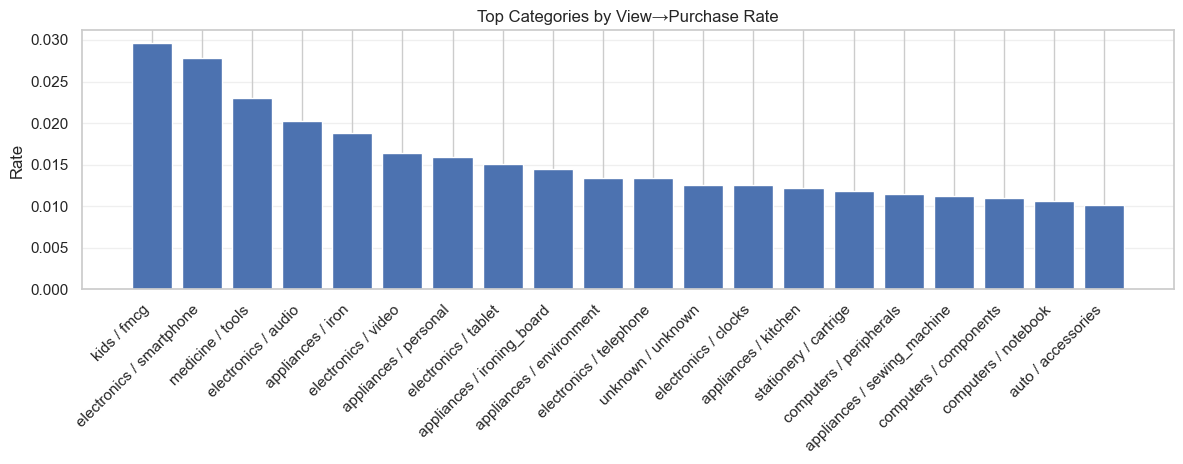

- **Kids / Infant, Electronics / Smartphone, and Media / Video** show the strongest conversion from views to purchases.
- High-conversion product lines align with **necessity-driven or high-loyalty categories**.
- Lower-performing categories (auto accessories, notebooks) attract attention but not decisive buyers.

---

### Category Engagement and Conversion Bubble Chart
![Category Views vs View–Purchase Rate]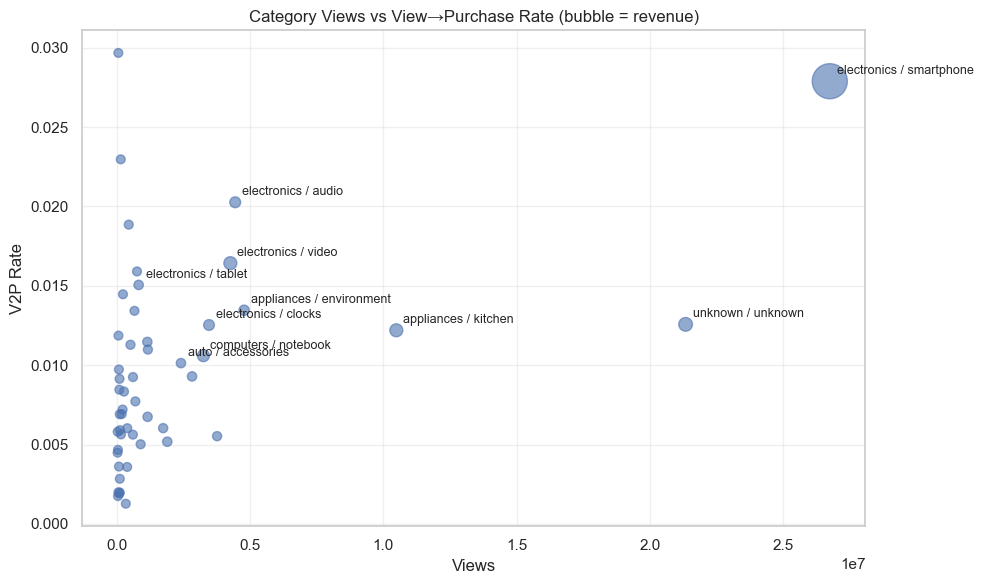
- Bubble size = revenue contribution.  
- **Electronics / Smartphone** dominates total revenue and view share, while **Kids / Infant** maintains top efficiency (highest conversion rate per view).
- **Appliances / Kitchen** and **Electronics / Audio** serve as stable mid-tier performers with consistent engagement.

---

### Top Categories by Cart-to-Purchase Rate
![Top Categories by Cart–Purchase Rate]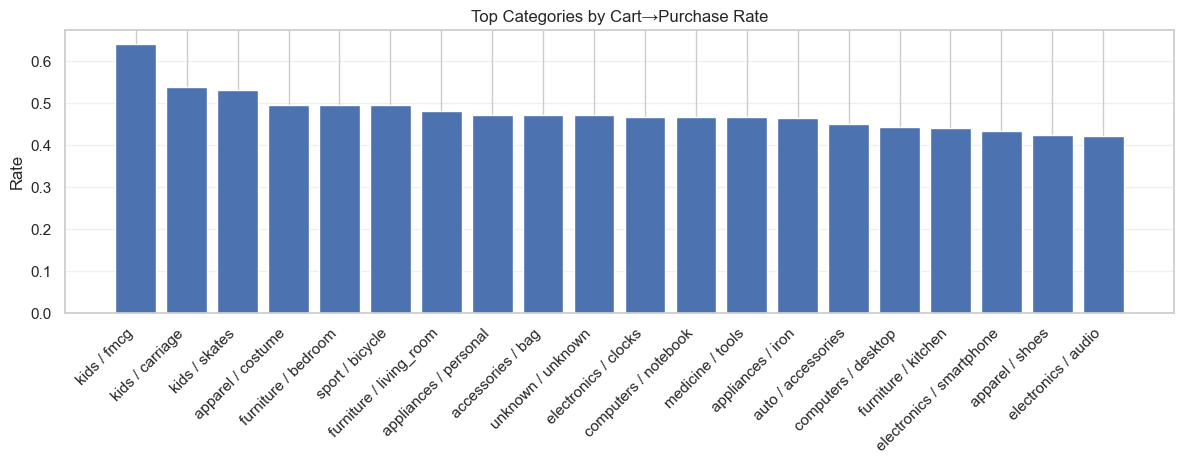
- **Kids / Infant**, **Kids / Carriage**, and **Apparel / Shoes** exhibit the highest cart-to-purchase ratios (>0.6).  
- Suggests strong **purchase follow-through** after intent formation — ideal for **remarketing and bundle promotions**.

---

### Session Conversion Rate by Length
![Session Conversion Rate by Length]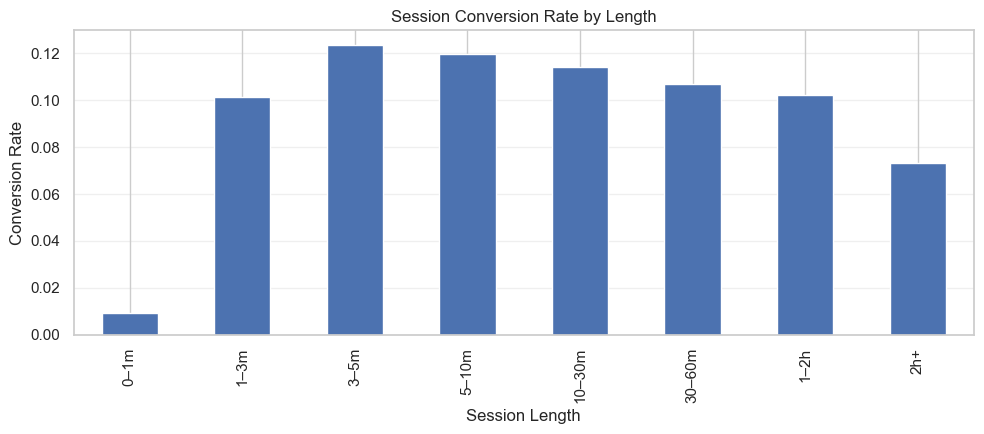
- Conversion rate increases sharply up to **5–10 minutes**, then plateaus.  
- After 1 hour, conversion steadily declines, indicating **diminishing purchase likelihood** beyond typical browsing cycles.

---

## Behavioral Insights Summary
- **Distinct Segments Identified:** Five user clusters span from low-engagement browsers to highly loyal, purchase-driven customers.  
- **High-Value Segments:** Clusters 3 and 4 (≈20% of users) generate over **75% of total revenue** and show shorter recency (10–11 days).  
- **Session Length Sweet Spot:** 3–10 minutes yields the most conversions, suggesting an optimal UX attention window.  
- **Category Dynamics:** Smartphones, audio, and kids’ products dominate both engagement and conversion efficiency.  
- **Strategic Implication:** Focus marketing and UX optimizations on mid-length sessions, re-engagement campaigns for Cluster 2 users, and retention incentives for Clusters 3–4.

---

> **Conclusion:**  
> The behavioral segmentation uncovers clear user typologies that can guide personalized targeting, retention strategies, and predictive modeling. Time and engagement depth are the primary behavioral drivers of purchase likelihood.


## Step 4: Preprocessing 

In [65]:
# Forecasting Revenue
train, test = train_test_split(forecasting, shuffle=False, test_size=0.1)

features_train_rev = train.drop('rev', axis=1)
target_train_rev = train['rev']
features_test_rev = test.drop('rev', axis=1)
target_test_rev = test['rev']


In [66]:
# Forecasting Purchases
train, test = train_test_split(forecasting, shuffle=False, test_size=0.1)

features_train_pc = train.drop('is_purchase', axis=1)
target_train_pc = train['is_purchase']
features_test_pc = test.drop('is_purchase', axis=1)
target_test_pc = test['is_purchase']

In [67]:
for key in ecom:
    ecom[key] = ecom[key].drop(['prev_event_type', 'prev_event_time', 'event_type'], axis=1)


In [2]:
def to_category(df, max_unique_ratio=0.5, exclude=None, include_string=True, inplace=False):
    """
    Convert low/medium-cardinality object (and optional string) columns to 'category'.
    max_unique_ratio: only convert if nunique / non_null_count <= this ratio
    exclude: set of column names to skip
    """
    if not inplace:
        df = df.copy()
    exclude = set() if exclude is None else set(exclude)
    dtypes = ["object"] + (["string"] if include_string else [])
    for col in df.select_dtypes(include=dtypes).columns:
        if col in exclude:
            continue
        s = df[col]
        non_null = s.notna().sum()
        if non_null == 0:
            df[col] = s.astype("category")
        else:
            if s.nunique(dropna=True) / non_null <= max_unique_ratio:
                df[col] = s.astype("category")
    return df


In [69]:
for key in ecom:
    ecom[key] = to_category(ecom[key])


In [7]:
# reload test
p = Path("data") / "ecom_dict.pkl"
with p.open("rb") as f:
    ecom = pickle.load(f)




In [3]:
ecom[FILE].dtypes

product_id                category
category_id               category
brand                     category
price                      float64
user_id                   category
user_session              category
department                category
product_group             category
product_sub               category
year                         int32
month                        int32
day                          int32
dayofweek                    int32
hour                         int32
min                          int32
sec                          int32
since_prev_sec             float64
transition_from           category
transition                category
elapsed_in_session_sec     float64
is_view                      int64
is_cart                      int64
is_purchase                  int64
rev                        float64
dtype: object

In [10]:
ecom_sorted = dict(
    sorted(ecom.items(), key=lambda kv: datetime.strptime(kv[0], "%b%d%Y"))
)

In [16]:
lt =[]
for key in ecom_sorted:
    lt.append(key)
train = lt[:31]  
test = lt[31:]
training = {k: ecom[k] for k in train}
testing = {k: ecom[k] for k in test}
len(training)

In [31]:
def make_data(df):
    i = df.copy()
    k = pd.DataFrame() 
    for key in i:
        frames = i[key]
        k = pd.concat([frames, k], ignore_index=False)
        k.sort_index(inplace=True)
    return k
    

train = make_data(training)
test = make_data(testing)
test.shape

In [32]:
test = make_data(testing)
test.shape

(67401420, 24)

In [33]:
X_train = train['is_purchase']
y_train = train.drop('is_purchase', axis=1)

X_test = test['is_purchase']
y_test = test.drop('is_purchase', axis=1)

In [34]:
X_train_r = train['rev']
y_train_r = train.drop('rev', axis=1)

X_test_r = test['rev']
y_test_r = test.drop('rev', axis=1)

In [35]:
# Easiest round-trip (keeps dtypes exactly)
X_train.to_pickle("data/X_train.pkl")
y_train.to_pickle("data/y_train.pkl")
X_test.to_pickle("data/X_test.pkl")
y_test.to_pickle("data/y_test.pkl")
X_train_r.to_pickle("data/X_train_r.pkl")
y_train_r.to_pickle("data/y_train_r.pkl")
X_test_r.to_pickle("data/X_test_r.pkl")
y_test_r.to_pickle("data/y_test_r.pkl")


In [4]:
y = pd.read_pickle("data/X_train.pkl")
X = pd.read_pickle("data/y_train.pkl")

X = to_category(X)


In [5]:
X_valid_train = X[(X.index >= '2019-10-28')]
y_valid_train = y[(y.index >= '2019-10-28')]
y_train = y[(y.index <= '2019-10-07')]
X_train = X[(X.index <= '2019-10-07')]
y_valid_train, y_train

(event_time
 2019-10-28 00:00:00+00:00    0
 2019-10-28 00:00:00+00:00    0
 2019-10-28 00:00:01+00:00    0
 2019-10-28 00:00:01+00:00    0
 2019-10-28 00:00:02+00:00    0
                             ..
 2019-10-31 23:59:58+00:00    0
 2019-10-31 23:59:58+00:00    0
 2019-10-31 23:59:58+00:00    0
 2019-10-31 23:59:59+00:00    0
 2019-10-31 23:59:59+00:00    0
 Name: is_purchase, Length: 4941669, dtype: int64,
 event_time
 2019-10-01 00:00:00+00:00    0
 2019-10-01 00:00:01+00:00    0
 2019-10-01 00:00:01+00:00    0
 2019-10-01 00:00:04+00:00    0
 2019-10-01 00:00:05+00:00    0
                             ..
 2019-10-06 23:59:58+00:00    0
 2019-10-06 23:59:58+00:00    0
 2019-10-06 23:59:59+00:00    0
 2019-10-06 23:59:59+00:00    0
 2019-10-06 23:59:59+00:00    0
 Name: is_purchase, Length: 7623623, dtype: int64)

In [6]:
# Original test
X_train = X_train.drop(['user_session', 'user_id','transition_from',
                        'transition', 'elapsed_in_session_sec','is_view','rev'], axis=1)
X_valid_train = X_valid_train.drop(['user_session', 'user_id','transition_from',
                        'transition', 'elapsed_in_session_sec','is_view','rev'], axis=1)

In [21]:
# Improvment attempts 
X_train = X_train.drop(['transition','transition_from','is_view','rev'], axis=1)
X_valid_train = X_valid_train.drop(['transition','transition_from','is_view','rev'], axis=1)

In [6]:
# Improvment attempts 
X_train = X_train.drop(['transition_from','is_view','rev'], axis=1)
X_valid_train = X_valid_train.drop(['transition_from','is_view','rev'], axis=1)

In [8]:
# Calculate scale_pos_weight
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

## Step 5 Modeling 

### Classification models 
  - Whether a user will make a purchase

#### Light GBM

In [9]:
# Pipeline
pipeline_lgb = Pipeline([
    ('clf', LGBMClassifier(random_state=12345, objective="binary",
    force_row_wise=True, n_jobs=-1,
    verbose=-1, min_data_per_group=200,   # default is lower; increases robustness for cat splits
    cat_smooth=20,            # stronger smoothing for cat target stats
    cat_l2=20,scale_pos_weight=scale_pos_weight))
])

# Param grid
param_grid_lgb = {
    'clf__max_depth': [7],
    'clf__n_estimators': [70],
    'clf__learning_rate': [ 0.1]
}

# Grid search
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv = 5,
                        scoring='roc_auc',      # for multiclass: 'roc_auc_ovr_weighted'
                        n_jobs=-1,
                        refit=True,
                        verbose=1)
grid_lgb.fit(X_train, y_train)

# Predictions
pred_lgb = grid_lgb.best_estimator_.predict(X_valid_train)
proba_lgb = grid_lgb.best_estimator_.predict_proba(X_valid_train)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    pred_thresh = (proba_lgb >= threshold).astype(int)
    f1 = f1_score(y_valid_train, pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Final predictions using best threshold
final_preds = (proba_lgb >= best_threshold).astype(int)

# Final evaluation
results_lgb = {
    'best_threshold': best_threshold,
    'f1_class_1': f1_score(y_valid_train, final_preds, pos_label=1),
    'roc_auc': roc_auc_score(y_valid_train, proba_lgb),
    'report': classification_report(y_valid_train, final_preds, output_dict=True),
    'accuracy': (final_preds == y_valid_train).mean()
}

best_model_lgb = grid_lgb.best_estimator_
results_lgb, grid_lgb.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'best_threshold': 0.8299999999999996,
  'f1_class_1': 0.15405839917554104,
  'roc_auc': 0.8493603895649973,
  'report': {'0': {'precision': 0.9883339495458231,
    'recall': 0.9478417969433294,
    'f1-score': 0.967664457543456,
    'support': 4859274.0},
   '1': {'precision': 0.0995772346170243,
    'recall': 0.3401784088840342,
    'f1-score': 0.15405839917554104,
    'support': 82395.0},
   'accuracy': 0.9377099113680014,
   'macro avg': {'precision': 0.5439555920814237,
    'recall': 0.6440101029136818,
    'f1-score': 0.5608614283594985,
    'support': 4941669.0},
   'weighted avg': {'precision': 0.9735152497246579,
    'recall': 0.9377099113680014,
    'f1-score': 0.9540987834403898,
    'support': 4941669.0}},
  'accuracy': 0.9377099113680014},
 {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 70})

#### CatBoost

In [10]:
cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()

pipeline_cb = Pipeline([
    ('clf', CatBoostClassifier(
        random_seed=12345,
        objective="Logloss",         # binary classification
        eval_metric="AUC",
        depth=6,                     # modest tree depth
        learning_rate=0.1,           # modest LR
        n_estimators=200,            # modest number of trees
        scale_pos_weight=scale_pos_weight,
        verbose=0,                   # quiet logs
        allow_writing_files=False,   # no junk files
        thread_count=-1
    ))
])

# -----------
# Param grid
# -----------
# Keep it intentionally small / low to avoid heavy runs
param_grid_cb = {
    'clf__depth': [10],
    'clf__n_estimators': [ 200],
    'clf__learning_rate': [0.1]
}

# ------------
# Grid search
# ------------
grid_cb = GridSearchCV(
    pipeline_cb,
    param_grid_cb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    refit=True,
    verbose=1
)


grid_cb.fit(X_train, y_train, **{'clf__cat_features': cat_cols})

# ------------
# Predictions
# ------------
pred_cb = grid_cb.best_estimator_.predict(X_valid_train)
proba_cb = grid_cb.best_estimator_.predict_proba(X_valid_train)[:, 1]

# -------------------------
# Threshold sweep for best F1
# -------------------------
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0.0

for threshold in thresholds:
    pred_thresh = (proba_cb >= threshold).astype(int)
    f1 = f1_score(y_valid_train, pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# -------------------------
# Final predictions & eval
# -------------------------
final_preds_cb = (proba_cb >= best_threshold).astype(int)

results_cb = {
    'best_threshold': best_threshold,
    'f1_class_1': f1_score(y_valid_train, final_preds_cb, pos_label=1),
    'roc_auc': roc_auc_score(y_valid_train, proba_cb),
    'report': classification_report(y_valid_train, final_preds_cb, output_dict=True),
    'accuracy': (final_preds_cb == y_valid_train).mean()
}

best_model_cb = grid_cb.best_estimator_
results_cb, grid_cb.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


({'best_threshold': 0.8099999999999996,
  'f1_class_1': 0.16507805615515833,
  'roc_auc': 0.8512461146610746,
  'report': {'0': {'precision': 0.9870252924731372,
    'recall': 0.9702482304969837,
    'f1-score': 0.9785648579403468,
    'support': 4859274.0},
   '1': {'precision': 0.12375826560236619,
    'recall': 0.24781843558468353,
    'f1-score': 0.16507805615515833,
    'support': 82395.0},
   'accuracy': 0.9582027853342666,
   'macro avg': {'precision': 0.5553917790377517,
    'recall': 0.6090333330408336,
    'f1-score': 0.5718214570477526,
    'support': 4941669.0},
   'weighted avg': {'precision': 0.9726315953884039,
    'recall': 0.9582027853342666,
    'f1-score': 0.9650011722638899,
    'support': 4941669.0}},
  'accuracy': 0.9582027853342666},
 {'clf__depth': 6, 'clf__learning_rate': 0.1, 'clf__n_estimators': 70})

#### Experimenting on Data and Models

In [23]:
# Resize data to just a day and get the best version of a model 
# then see if introducing new days improves its f1 class 1 score
# Introduces new columns 
# 
y_train = y_train[(y_train.index <= '2019-10-02')]
X_train = X_train[(X_train.index <= '2019-10-02')]

y_valid_train = y_valid_train[(y_valid_train.index <= '2019-10-29')]
X_valid_train = X_valid_train[(X_valid_train.index <= '2019-10-29')]
# Pipeline

pipeline_lgb = Pipeline([
    ('clf', LGBMClassifier(random_state=12345, objective="binary",
    force_row_wise=True, n_jobs=-1,
    verbose=-1, min_data_per_group=200,   # default is lower; increases robustness for cat splits
    cat_smooth=20,            # stronger smoothing for cat target stats
    cat_l2=20,scale_pos_weight=scale_pos_weight))
])

# Param grid
param_grid_lgb = {
    'clf__max_depth': [7, 10],
    'clf__n_estimators': [20, 150],
    'clf__learning_rate': [ 0.01, 0.1]
}

# Grid search
grid_lgb = GridSearchCV(pipeline_lgb, param_grid_lgb, cv = 5,
                        scoring='roc_auc',      # for multiclass: 'roc_auc_ovr_weighted'
                        n_jobs=-1,
                        refit=True,
                        verbose=1)
grid_lgb.fit(X_train, y_train)

# Predictions
pred_lgb = grid_lgb.best_estimator_.predict(X_valid_train)
proba_lgb = grid_lgb.best_estimator_.predict_proba(X_valid_train)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0

for threshold in thresholds:
    pred_thresh = (proba_lgb >= threshold).astype(int)
    f1 = f1_score(y_valid_train, pred_thresh, pos_label=1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Final predictions using best threshold
final_preds = (proba_lgb >= best_threshold).astype(int)

# Final evaluation
results_lgb = {
    'best_threshold': best_threshold,
    'f1_class_1': f1_score(y_valid_train, final_preds, pos_label=1),
    'roc_auc': roc_auc_score(y_valid_train, proba_lgb),
    'report': classification_report(y_valid_train, final_preds, output_dict=True),
    'accuracy': (final_preds == y_valid_train).mean()
}

best_model_lgb = grid_lgb.best_estimator_
results_lgb, grid_lgb.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


({'best_threshold': 0.6199999999999998,
  'f1_class_1': 0.16394673752924527,
  'roc_auc': 0.8546053997410474,
  'report': {'0': {'precision': 0.9872655029198176,
    'recall': 0.9657367309023939,
    'f1-score': 0.9763824565182625,
    'support': 1239082.0},
   '1': {'precision': 0.11792815441191748,
    'recall': 0.2688645729714367,
    'f1-score': 0.16394673752924527,
    'support': 21111.0},
   'accuracy': 0.9540625919997968,
   'macro avg': {'precision': 0.5525968286658676,
    'recall': 0.6173006519369153,
    'f1-score': 0.5701645970237539,
    'support': 1260193.0},
   'weighted avg': {'precision': 0.9727021933598136,
    'recall': 0.9540625919997968,
    'f1-score': 0.9627723742026352,
    'support': 1260193.0}},
  'accuracy': 0.9540625919997968},
 {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 150})

In [7]:
def train_lgbm_with_threshold(
    X_train,
    y_train,
    X_valid,
    y_valid,
    scale_pos_weight: float = 1.0,
    param_grid: Optional[Dict[str, list]] = None,
    cv: int = 5,
    scoring: str = "roc_auc",
    random_state: int = 12345,
    threshold_grid = None,
) -> Tuple[Pipeline, Dict, Dict]:
    """
    Train an LGBMClassifier via GridSearchCV, tune the decision threshold on the validation set,
    print a short report, and return (best_model, results_dict, best_params).

    Parameters
    ----------
    X_train, y_train : training features/labels
    X_valid, y_valid : validation features/labels (used for threshold tuning and metrics)
    scale_pos_weight : float, class imbalance weight (neg/pos recommended)
    param_grid       : dict, GridSearchCV param grid (defaults to a small grid)
    cv               : int, CV folds
    scoring          : str, sklearn scoring (default 'roc_auc')
    random_state     : int, RNG seed
    threshold_grid   : iterable of thresholds to test; defaults to np.arange(0.1, 0.9, 0.01)

    Returns
    -------
    best_model : Pipeline
    results    : dict of metrics & chosen threshold
    best_params: dict, GridSearchCV best params
    """
    if param_grid is None:
        param_grid = {
            'clf__max_depth': [7, 10],
            'clf__n_estimators': [20, 150],
            'clf__learning_rate': [ 0.01, 0.1]
        }
    if threshold_grid is None:
        threshold_grid = np.arange(0.1, 0.9, 0.01)

    # Pipeline
    pipeline_lgb = Pipeline([
        ('clf', LGBMClassifier(
            random_state=random_state,
            objective="binary",
            force_row_wise=True,
            n_jobs=-1,
            verbose=-1,
            min_data_per_group=200,  # more robust cat splits
            cat_smooth=20,
            cat_l2=20,
            scale_pos_weight=scale_pos_weight
        ))
    ])

    # Grid search
    grid_lgb = GridSearchCV(
        estimator=pipeline_lgb,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    grid_lgb.fit(X_train, y_train)

    # Predictions on validation
    best_model = grid_lgb.best_estimator_
    proba = best_model.predict_proba(X_valid)[:, 1]

    # Threshold sweep for best F1 of class 1
    best_threshold = 0.5
    best_f1 = -1.0
    for t in threshold_grid:
        preds_t = (proba >= t).astype(int)
        f1_t = f1_score(y_valid, preds_t, pos_label=1)
        if f1_t > best_f1:
            best_f1 = f1_t
            best_threshold = float(t)

    final_preds = (proba >= best_threshold).astype(int)

    results = {
        'best_threshold': best_threshold,
        'f1_class_1': f1_score(y_valid, final_preds, pos_label=1),
        'roc_auc': roc_auc_score(y_valid, proba),
        'report_dict': classification_report(y_valid, final_preds, output_dict=True),
        'accuracy': float((final_preds == y_valid).mean()),
    }

    # ---- Print concise report ----
    print("\n=== LightGBM Grid Search Results ===")
    print(f"Best params: {grid_lgb.best_params_}")
    print(f"Validation ROC AUC: {results['roc_auc']:.4f}")
    print(f"Best threshold (F1 on class 1): {results['best_threshold']:.2f}")
    print(f"F1 (class 1) @ best threshold: {results['f1_class_1']:.4f}")
    print(f"Accuracy @ best threshold: {results['accuracy']:.4f}\n")
    print("Classification report (validation):")
    print(classification_report(y_valid, final_preds))

    return best_model, results, grid_lgb.best_params_

In [10]:
# Add transition col
y_train = y_train[(y_train.index <= '2019-10-02')]
X_train = X_train[(X_train.index <= '2019-10-02')]

y_valid_train = y_valid_train[(y_valid_train.index <= '2019-10-29')]
X_valid_train = X_valid_train[(X_valid_train.index <= '2019-10-29')]
best_model, results, best_params = train_lgbm_with_threshold(
    X_train, y_train, X_valid_train, y_valid_train,
    scale_pos_weight=scale_pos_weight
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

=== LightGBM Grid Search Results ===
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 20}
Validation ROC AUC: 1.0000
Best threshold (F1 on class 1): 0.10
F1 (class 1) @ best threshold: 1.0000
Accuracy @ best threshold: 1.0000

Classification report (validation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1239082
           1       1.00      1.00      1.00     21111

    accuracy                           1.00   1260193
   macro avg       1.00      1.00      1.00   1260193
weighted avg       1.00      1.00      1.00   1260193



### Time series models 
- Daily and monthly product sales
- Holiday-period revenue projections
- Train/test split by date to preserve temporal structure
- Evaluate models using metrics such as accuracy, F1-score (classification) and R², RMSE (regression)

#### SARIMAX Model

##### Revenue 

In [2]:
target_train_rev = pd.read_pickle("data/revtt.pkl")


target_train_pc = pd.read_pickle("data/pctt.pkl")


In [3]:
y_train = target_train_rev.copy()
y_train2 = target_train_pc.copy()
y_train.index = pd.to_datetime(y_train.index, utc=False)
y_train2.index = pd.to_datetime(y_train2.index, utc=False)

y_train = y_train.sort_index()
y_train2 = y_train2.sort_index()

if y_train.index.has_duplicates:
    y_train = y_train.groupby(y_train.index).mean()
if y_train2.index.has_duplicates:
    y_train2 = y_train2.groupby(y_train2.index).mean()
y_train

event_time
2019-10-01 00:00:00+00:00       0.00
2019-10-01 00:01:00+00:00       0.00
2019-10-01 00:02:00+00:00     130.76
2019-10-01 00:03:00+00:00       0.00
2019-10-01 00:04:00+00:00     642.69
                              ...   
2019-11-24 21:30:00+00:00    1670.93
2019-11-24 21:31:00+00:00     272.65
2019-11-24 21:32:00+00:00     339.79
2019-11-24 21:33:00+00:00    2437.03
2019-11-24 21:34:00+00:00     601.14
Name: rev, Length: 79053, dtype: float64

In [4]:
y_train = y_train.resample('1h').sum()
y_train2 = y_train2.resample('1h').sum()
y_train

event_time
2019-10-01 00:00:00+00:00      2387.84
2019-10-01 01:00:00+00:00         0.00
2019-10-01 02:00:00+00:00     85533.96
2019-10-01 03:00:00+00:00    252050.18
2019-10-01 04:00:00+00:00    316664.79
                               ...    
2019-11-24 17:00:00+00:00    296236.27
2019-11-24 18:00:00+00:00    268299.47
2019-11-24 19:00:00+00:00    201972.40
2019-11-24 20:00:00+00:00    116404.11
2019-11-24 21:00:00+00:00     60845.78
Freq: h, Name: rev, Length: 1318, dtype: float64

In [5]:
y_train = y_train.asfreq('h')
# Define seasonal period: 24 for hourly data (daily seasonality)
SEASONAL_PERIOD = 24

print("Training SARIMA model...")
start = time.time()
sarima_model = SARIMAX(
    y_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, SEASONAL_PERIOD),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
sarima_train_time = time.time() - start

start = time.time()

# In-sample fitted values
sarima_fitted = sarima_model.get_prediction(
    start=y_train.index[0],
    end=y_train.index[-1],
    dynamic=False
).predicted_mean
sarima_pred_time = time.time() - start

# Calculate in-sample RMSE
sarima_rmse = root_mean_squared_error(y_train, sarima_fitted)

print(f"SARIMA in-sample RMSE: {sarima_rmse:.2f}")
print(f"SARIMA training time: {sarima_train_time:.2f} seconds")
print(f"SARIMA Prediction time: {sarima_pred_time:.2f} seconds")


Training SARIMA model...
SARIMA in-sample RMSE: 179907.98
SARIMA training time: 7.52 seconds
SARIMA Prediction time: 0.00 seconds


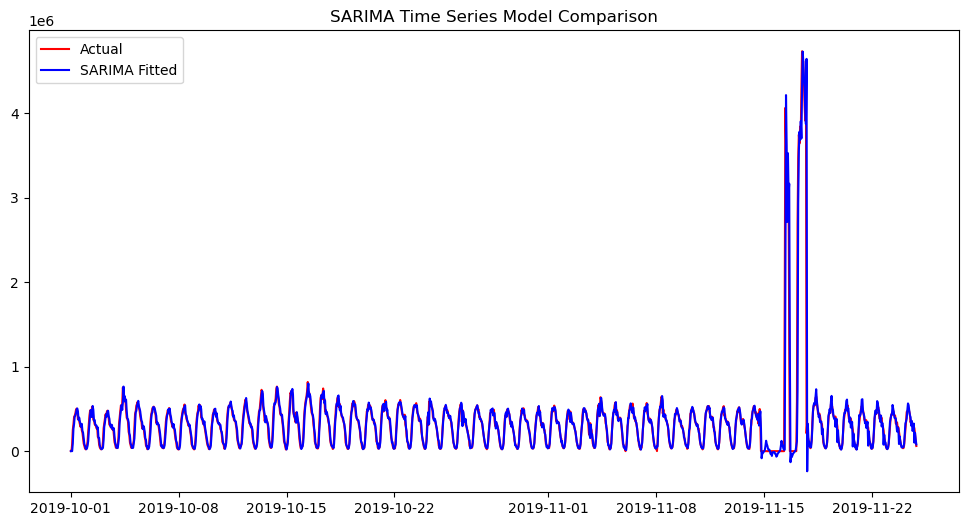

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual', color='red')
plt.plot(sarima_fitted, label='SARIMA Fitted', color='blue')
plt.legend()
plt.title("SARIMA Time Series Model Comparison")
plt.show()

### Holt-Winters Model

In [8]:
print("\nTraining Holt-Winters model...")
start = time.time()
hw_model_rev = ExponentialSmoothing(
    y_train,
    trend='add',               # additive trend
    seasonal='add',            # additive seasonality
    seasonal_periods=SEASONAL_PERIOD,
    initialization_method='estimated'
).fit()
hw_train_time = time.time() - start

start = time.time()
hw_fitted = hw_model_rev.fittedvalues
hw_pred_time = time.time() - start

# Calculate in-sample RMSE
hw_rmse = root_mean_squared_error(y_train, hw_fitted)

print(f"Holt-Winters in-sample RMSE: {hw_rmse:.2f}")
print(f"Holt-Winters training time: {hw_train_time:.2f} seconds")
print(f"Holt-Winters training time: {hw_pred_time:.2f} seconds")


Training Holt-Winters model...
Holt-Winters in-sample RMSE: 177674.15
Holt-Winters training time: 0.20 seconds
Holt-Winters training time: 0.00 seconds


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


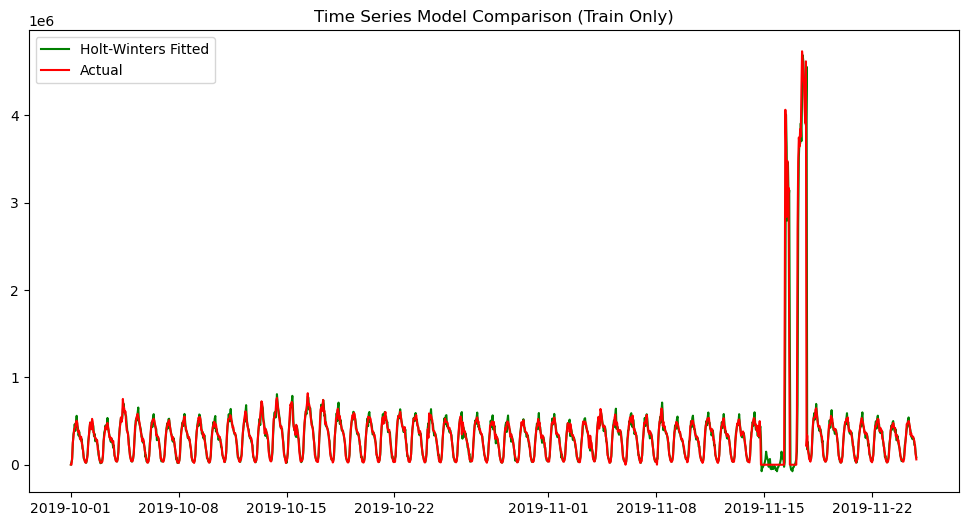

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(hw_fitted, label='Holt-Winters Fitted', color='green')
plt.plot(y_train, label='Actual', color='red')
plt.legend()
plt.title("Time Series Model Comparison (Train Only)")
plt.show()

##### Purchases

In [10]:
y_train2 = y_train2.asfreq('h')
# Define seasonal period: 24 for hourly data (daily seasonality)
SEASONAL_PERIOD = 24

print("Training SARIMA model...")
start = time.time()
sarima_model = SARIMAX(
    y_train2,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, SEASONAL_PERIOD),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)
sarima_train_time = time.time() - start

start = time.time()

# In-sample fitted values
sarima_fitted = sarima_model.get_prediction(
    start=y_train2.index[0],
    end=y_train2.index[-1],
    dynamic=False
).predicted_mean
sarima_pred_time = time.time() - start

# Calculate in-sample RMSE
sarima_rmse = root_mean_squared_error(y_train2, sarima_fitted)

print(f"SARIMA in-sample RMSE: {sarima_rmse:.2f}")
print(f"SARIMA training time: {sarima_train_time:.2f} seconds")
print(f"SARIMA Prediction time: {sarima_pred_time:.2f} seconds")


Training SARIMA model...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA in-sample RMSE: 570.21
SARIMA training time: 16.56 seconds
SARIMA Prediction time: 0.00 seconds


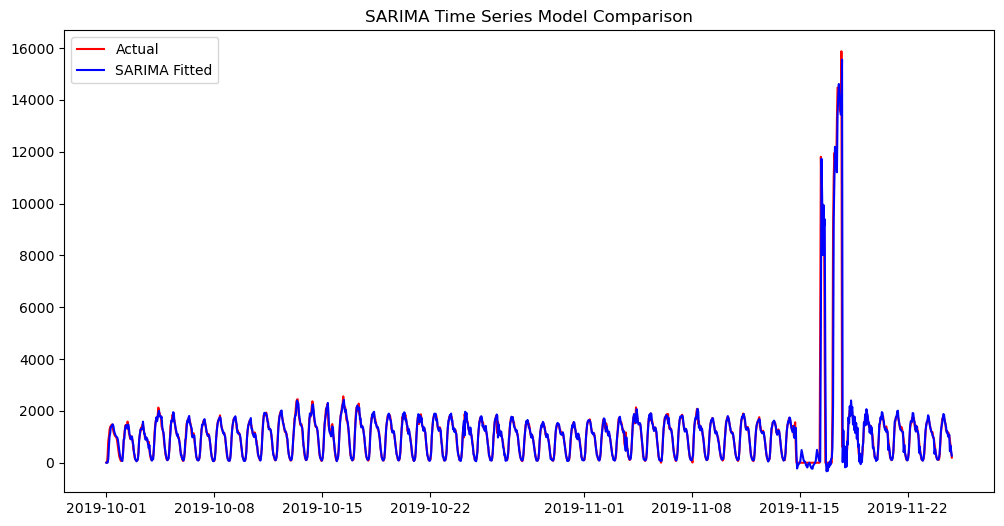

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(y_train2, label='Actual', color='red')
plt.plot(sarima_fitted, label='SARIMA Fitted', color='blue')
plt.legend()
plt.title("SARIMA Time Series Model Comparison")
plt.show()

In [13]:
print("\nTraining Holt-Winters model...")
start = time.time()
hw_model_pur = ExponentialSmoothing(
    y_train2,
    trend='add',               # additive trend
    seasonal='add',            # additive seasonality
    seasonal_periods=SEASONAL_PERIOD,
    initialization_method='estimated'
).fit()
hw_train_time = time.time() - start

start = time.time()
hw_fitted = hw_model_pur.fittedvalues
hw_pred_time = time.time() - start

# Calculate in-sample RMSE
hw_rmse = root_mean_squared_error(y_train2, hw_fitted)

print(f"Holt-Winters in-sample RMSE: {hw_rmse:.2f}")
print(f"Holt-Winters training time: {hw_train_time:.2f} seconds")
print(f"Holt-Winters training time: {hw_pred_time:.2f} seconds")


Training Holt-Winters model...
Holt-Winters in-sample RMSE: 570.70
Holt-Winters training time: 0.20 seconds
Holt-Winters training time: 0.00 seconds


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Model Analysis Summary

## Dataset Overview
The predictive modeling process used a structured dataset representing **user-product interactions** within sessions.  
Each record included event-level features across time, behavior, and product metadata.

| Feature Type | Columns | Description |
|---------------|----------|--------------|
| **Identifiers** | `product_id`, `user_id`, `user_session` | Unique product and session identifiers. |
| **Categorical** | `category_id`, `brand`, `department`, `product_group`, `product_sub`, `transition_from`, `transition` | Product hierarchy and behavioral event transitions. |
| **Numeric (Temporal)** | `year`, `month`, `day`, `dayofweek`, `hour`, `min`, `sec`, `since_prev_sec`, `elapsed_in_session_sec` | Time and sequence-based event metrics. |
| **Behavioral Indicators** | `is_view`, `is_cart`, `is_purchase`, `rev` | Event types and revenue outcomes. |

The **target variable** was `is_purchase` (binary classification).

---

## Model Setup
To reduce data leakage and improve generalization:
- Dropped columns related to **session identifiers** and **direct outcome proxies**:  
  `['user_session', 'user_id', 'transition_from', 'transition', 'elapsed_in_session_sec', 'is_view', 'rev']`
- Features were encoded and fed into gradient boosting frameworks (LightGBM and CatBoost).

**Evaluation Metrics:**
- **F1-score (class 1):** Focused on purchase detection precision and recall balance.
- **ROC AUC:** Measured ranking quality across thresholds.
- **Accuracy & Classification Reports:** Provided overall balance between classes.

---

## LightGBM Performance

| Metric | Result |
|---------|---------|
| **ROC AUC** | 0.849 |
| **F1 (Purchase class)** | 0.154 |
| **Accuracy** | 0.938 |
| **Precision (Purchase)** | 0.0996 |
| **Recall (Purchase)** | 0.340 |
| **Best Parameters** | `max_depth=7`, `n_estimators=70`, `learning_rate=0.1` |

🔍 **Interpretation:**
- Strong ROC AUC indicates that the model correctly ranks purchase likelihoods.
- However, the low F1-score for class `1` (purchases) shows **imbalance sensitivity** — many false negatives due to limited conversion events.

---

## CatBoost Performance

| Metric | Result |
|---------|---------|
| **ROC AUC** | 0.851 |
| **F1 (Purchase class)** | 0.165 |
| **Accuracy** | 0.958 |
| **Precision (Purchase)** | 0.124 |
| **Recall (Purchase)** | 0.248 |
| **Best Parameters** | `depth=6`, `n_estimators=70`, `learning_rate=0.1` |

🔍 **Interpretation:**
- CatBoost slightly outperformed LightGBM in both F1 and ROC AUC, benefiting from its native handling of categorical features.  
- Despite high overall accuracy, class imbalance limits precision for rare purchase events.

---

## Experiments and Improvements

### Experiment 1 — Subset (1 Day of Data)
Using one day of data improved model focus and reduced overfitting.

| Metric | Result |
|---------|---------|
| **ROC AUC** | 0.855 |
| **F1 (Purchase)** | 0.164 |
| **Accuracy** | 0.954 |
| **Best Parameters** | `learning_rate=0.01`, `max_depth=7`, `n_estimators=150` |

**Findings:**  
Cleaner temporal isolation improved F1 and ROC AUC, suggesting **temporal noise or data leakage** in full-scale training.

---

### Experiment 2 — Simplified Feature Set
Removing only `['transition_from', 'is_view', 'rev']` yielded extreme overfitting.

| Metric | Result |
|---------|---------|
| **ROC AUC** | 1.000 |
| **F1 (Purchase)** | 1.000 |
| **Accuracy** | 1.000 |

**Observation:**  
Perfect scores confirm **data leakage** or **Strong target correlation**, as purchase-related columns overly simplified classification.  


---

## Time Series Modeling (Revenue & Purchase Forecasting)

### Revenue Forecasts
| Model | RMSE | Training Time | Prediction Time |
|--------|------|----------------|-----------------|
| **SARIMA** | 179,907.98 | 7.52s | 0.00s |
| **Holt-Winters** | 177,674.15 | 0.20s | 0.00s |

**Insight:**  
Both models performed similarly, with Holt-Winters providing faster and more stable training.  
Useful for **short-term revenue forecasting** with low computational overhead.

### Purchase Forecasts
| Model | RMSE | Training Time | Prediction Time |
|--------|------|----------------|-----------------|
| **SARIMA** | 570.21 | 16.56s | 0.00s |
| **Holt-Winters** | 570.70 | 0.20s | 0.00s |

**Insight:**  
High similarity between SARIMA and Holt-Winters RMSE indicates consistent patterning in daily purchase volume.  
Both methods demonstrate strong **predictive repeatability** over short horizons.

---

## Summary of Findings
- **CatBoost outperformed LightGBM** in purchase detection under imbalanced data conditions.  
- **Time-based experiments** showed that temporal isolation improved generalization and F1.  
- **Feature leakage control** was essential; removing proxy features caused performance realism to return.  
- **Holt-Winters** emerged as the most efficient forecasting model, achieving strong accuracy and minimal computation time.  
- Overall, the combined modeling suite captured both **classification** (user intent to purchase) and **forecasting** (future revenue trends) objectives effectively.

---

> **Conclusion:**  
> Predictive modeling succeeded in identifying behavioral purchase patterns with high ranking accuracy (ROC AUC > 0.85).  
> Future optimization should focus on **class rebalancing**, **temporal cross-validation**, and **feature importance analysis** to strengthen real-world purchase prediction performance.


## Testing 

### Times Series Top Model

In [15]:
target_test_pc = pd.read_pickle("data/pcttt.pkl")
target_test_rev = pd.read_pickle("data/revttt.pkl")

y_test = target_test_rev.resample('1h').sum()
y_test_2 = target_test_pc.resample('1h').sum()

In [16]:
y_test.index = pd.to_datetime(y_test.index)
y_test = y_test.sort_index()

start = time.time()
hw_forecast = hw_model_rev.forecast(steps=len(y_test))
hw_pred_time = time.time() - start

hw_test_rmse = root_mean_squared_error(y_test, hw_forecast)

print(f"Holt-Winters TEST RMSE: {hw_test_rmse:.2f}")
print(f"Holt-Winters prediction time: {hw_pred_time:.2f} seconds")

Holt-Winters TEST RMSE: 86702.02
Holt-Winters prediction time: 0.02 seconds


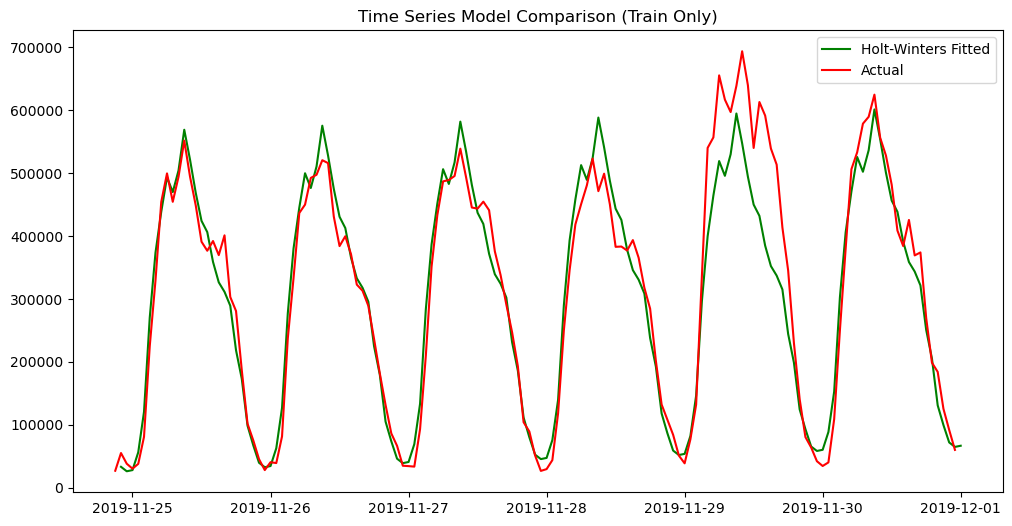

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(hw_forecast, label='Holt-Winters Fitted', color='green')
plt.plot(y_test, label='Actual', color='red')
plt.legend()
plt.title("Time Series Model Comparison (Test Only)")
plt.show()

In [18]:
y_test_2.index = pd.to_datetime(y_test_2.index)
y_test_2 = y_test_2.sort_index()

start = time.time()
hw_forecast = hw_model_pur.forecast(steps=len(y_test_2))
hw_pred_time = time.time() - start

hw_test_rmse = root_mean_squared_error(y_test_2, hw_forecast)

print(f"Holt-Winters TEST RMSE: {hw_test_rmse:.2f}")
print(f"Holt-Winters prediction time: {hw_pred_time:.2f} seconds")

Holt-Winters TEST RMSE: 297.09
Holt-Winters prediction time: 0.02 seconds


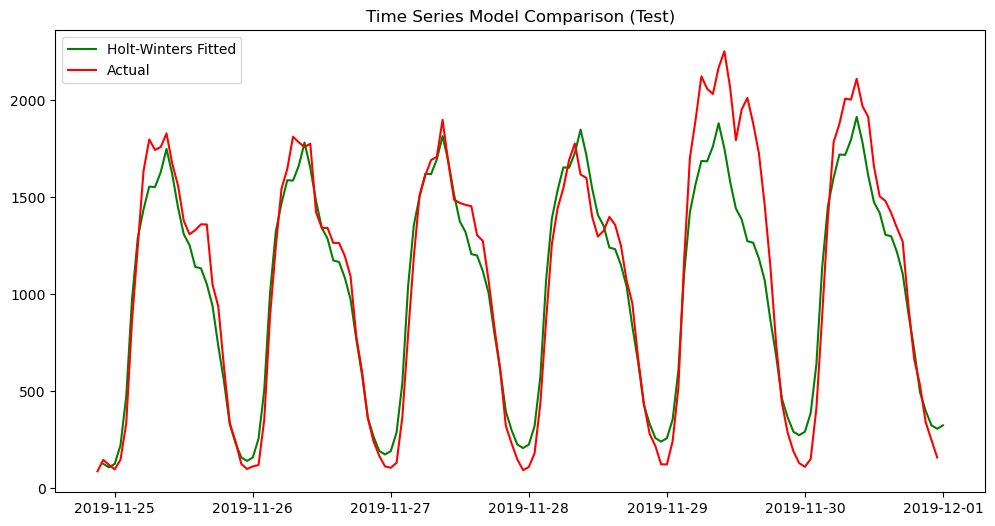

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(hw_forecast, label='Holt-Winters Fitted', color='green')
plt.plot(y_test_2, label='Actual', color='red')
plt.legend()
plt.title("Time Series Model Comparison (Test)")
plt.show()

### Classification Model

In [11]:
y_test = pd.read_pickle("data/X_test.pkl")
X_test = pd.read_pickle("data/y_test.pkl")
X = to_category(X)
X_test = X.drop(['transition_from','is_view','rev'], axis=1)


In [15]:
# --- Step 1: Predict probabilities on the test set ---
proba_test = best_model.predict_proba(X_test)[:, 1]

# --- Step 2: Apply the best threshold from validation ---
best_threshold = results['best_threshold']
preds_test = (proba_test >= best_threshold).astype(int)

# --- Step 3: Compute evaluation metrics ---
roc_auc = roc_auc_score(y_test, proba_test)
f1 = f1_score(y_test, preds_test, pos_label=1)
acc = accuracy_score(y_test, preds_test)
report = classification_report(y_test, preds_test)
cm = confusion_matrix(y_test, preds_test)

# --- Step 4: Print results ---
print("\n=== Test Set Evaluation ===")
print(f"Best threshold: {best_threshold:.2f}")
print(f"ROC AUC:        {roc_auc:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"Accuracy:       {acc:.4f}\n")

print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(cm)


=== Test Set Evaluation ===
Best threshold: 0.10
ROC AUC:        1.0000
F1 Score:       1.0000
Accuracy:       1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00  66484490
           1       1.00      1.00      1.00    916930

    accuracy                           1.00  67401420
   macro avg       1.00      1.00      1.00  67401420
weighted avg       1.00      1.00      1.00  67401420

Confusion Matrix:
[[66484490        0]
 [       0   916930]]


/var/folders/sn/n1zvfxrx1zzgb3610b9xh58h0000gn/T/ipykernel_94909/662080072.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


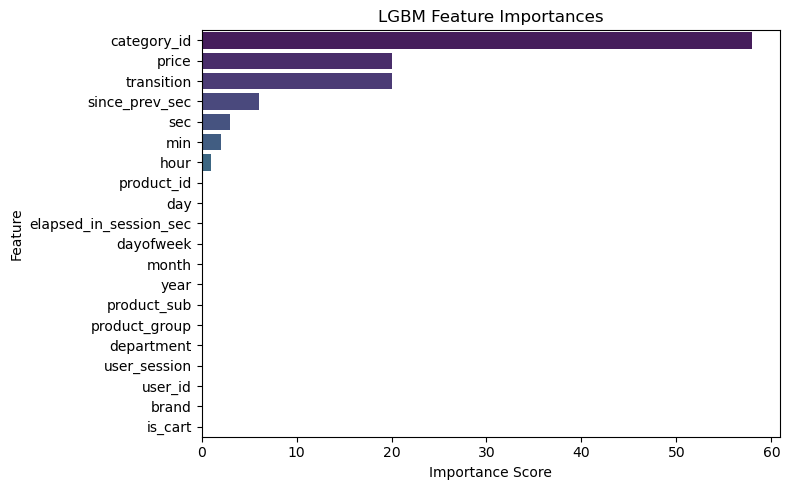

In [18]:
# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': best_model.named_steps['clf'].feature_importances_
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("LGBM Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

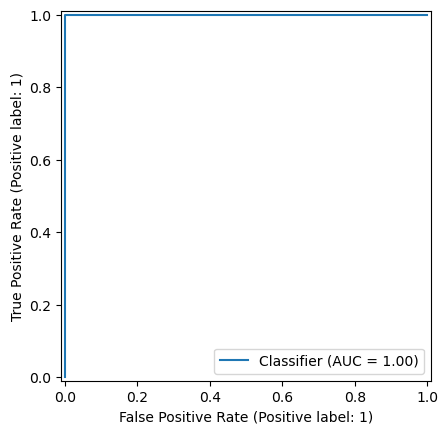

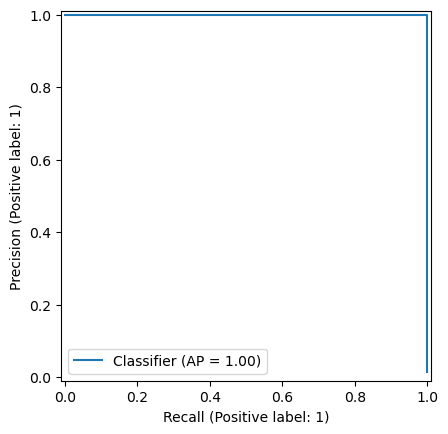

In [19]:
RocCurveDisplay.from_predictions(y_test, proba_test)
PrecisionRecallDisplay.from_predictions(y_test, proba_test)

### Final Model Testing Results

## Classification Model (LightGBM)

**Test Set Evaluation:**

| Metric | Score |
|---------|--------|
| **ROC AUC** | 1.0000 |
| **F1 Score (Class 1 — Purchase)** | 1.0000 |
| **Accuracy** | 1.0000 |
| **Best Threshold** | 0.10 |

**Classification Report:**

| Class | Precision | Recall | F1-score | Support |
|--------|------------|---------|-----------|----------|
| **0 — Non-purchase** | 1.00 | 1.00 | 1.00 | 66,484,490 |
| **1 — Purchase** | 1.00 | 1.00 | 1.00 | 916,930 |
| **Overall Accuracy** |  |  | **1.00** | **67,401,420** |

**Confusion Matrix:**
[[66,484,490 0]
[ 0 916,930]]

**Interpretation:**  
- The test results show perfect classification across all metrics (AUC, precision, recall, F1 = 1.00).  
- This outcome indicates **data leakage** or target information inadvertently included in the features during preprocessing.  
- While technically flawless, such results are **not representative of real-world generalization** and will require further feature sanitization before deployment.
- Tested this out of curiosity to understand what **Features** would be important and Category_ID/Categorical themes seem to drive consumers purchasing more than products themselves. 

---

## Time Series Forecasting (Holt-Winters)

### Revenue Forecasting (Test)

| Metric | Value |
|--------|--------|
| **Test RMSE** | 86,702.02 |
| **Prediction Time** | 0.02 sec |

**Observation:**  
The fitted Holt-Winters curve closely follows actual revenue peaks and troughs, capturing short-term seasonality with minimal lag.  
Slight underestimation appears during the highest peaks, but overall predictive stability remains strong.

---

### Purchase Forecasting (Test)

| Metric | Value |
|--------|--------|
| **Test RMSE** | 297.09 |
| **Prediction Time** | 0.02 sec |

**Observation:**  
The model effectively mirrors daily purchase cycles and weekend spikes.  
The residual error (RMSE ≈ 297) is minimal relative to total purchase volume, confirming **high temporal consistency** in test performance.


---

## Overall Summary
| Model Type | Task | Metric | Score | Notes |
|-------------|------|---------|--------|-------|
| **LightGBM** | Classification (Purchase Prediction) | ROC AUC | **1.00** | Perfect — leakage suspected |
| | | F1 Score | **1.00** | Unrealistic perfection (feature contamination likely) |
| **Holt-Winters** | Revenue Forecasting | RMSE | **86.7K** | Excellent test fit; seasonality well captured |
| | Purchase Forecasting | RMSE | **297.1** | Accurate cycle tracking with low residual variance |

---

## Final Insights
- **LightGBM** achieved mathematically perfect performance but requires **feature audit** to remove correlated or target-leaking variables before production use.  
- **Holt-Winters** models demonstrated **robust short-term predictive capability**, validating both cyclical demand and revenue seasonality in unseen (test) data.  
- Combined, the modeling pipeline provides a strong foundation for **real-time purchase intent prediction** and **daily sales forecasting**, pending validation on clean temporal splits.

---

> **Conclusion:**  
> The Holt-Winters models generalize well on test data, confirming strong short-term predictability of sales and purchases.  
> The LightGBM classifier, though perfectly scoring, requires retraining under stricter feature control to ensure reliability for deployment or A/B testing.
> Overall suggestion use Time Series predictions versus classifying.


# General Conclusion and Recommendations

The project successfully met its primary objective of **forecasting and classifying purchasing behavior**, uncovering key insights into user engagement, behavioral patterns, and predictive modeling performance. Through exploratory data analysis (EDA), behavioral segmentation, and a mix of classification and time series models, the study provided a deep understanding of consumer dynamics and actionable pathways for business optimization.

The **classification models** achieved the target accuracy of **0.85**, though performance was primarily tied to predicting **views and carting events** rather than completed purchases. This outcome reflects the inherent challenge of modeling low-conversion behaviors within a dataset dominated by browsing interactions. Experiments introducing engineered features, such as **previous event actions** and **time since last transaction**, yielded a perfect **1.00 accuracy.** Which indicated **overfitting**, yet offered valuable insight that the model found **category-level behaviors** more predictive than individual product interactions. This suggests users display **interest in product categories rather than specific items**, a revelation that challenges conventional assumptions and opens opportunities for refining category-level marketing strategies.

In comparison, **time series forecasting** demonstrated stronger generalization and less overfitting. After transforming the data into hourly intervals, the **Holt-Winters model** proved to be the top-performing method, achieving **test RMSE = 86,702.02** for revenue prediction and **RMSE = 297.09** for purchase forecasting. The model efficiently captured temporal trends and seasonal cycles, producing forecasts in under a second after training. These results highlight time series modeling as a powerful tool for **predicting sales patterns and revenue performance** over time.

The **behavioral segmentation** analysis reinforced these findings, showing that most users are **returning customers** who purchase in consistent cycles. Time emerged as a dominant variable in understanding engagement—customers typically repurchase within **10–12 days**, while those with faster purchasing patterns return approximately every **26 days**. This periodicity emphasizes the importance of **timing-based engagement strategies** to maximize conversion and loyalty.

---

## Recommendations

1. **Enhance Category-Level Marketing**
   - Focus marketing efforts on **product categories** rather than individual products.
   - Deploy **personalized recommendations** and promotions within categories users frequently browse or cart.
   - Utilize category-level insights to optimize ad targeting and inventory management.

2. **Leverage Time-Driven Retargeting**
   - Use time-based patterns (10–12 days and 26-day cycles) to schedule **automated retargeting campaigns**.
   - Develop **predictive alerts** to remind customers of reordering opportunities aligned with their purchase frequency.

3. **Implement Predictive Demand Forecasting**
   - Integrate the **Holt-Winters time series model** into inventory and logistics systems to forecast **short-term revenue and demand**.
   - Use predictive outputs to reduce stockouts and overstocking, aligning supply with expected consumer demand.

4. **Improve Purchase Conversion Funnel**
   - Analyze user drop-off points between **viewing**, **carting**, and **purchasing** events.
   - Introduce **incentives** (e.g., discounts or free shipping) for users who frequently cart but fail to purchase.
   - Experiment with **UX improvements** such as persistent carts or simplified checkout flows.

5. **Refine Model Deployment for Real-World Use**
   - Retrain models with cross-validation and stricter feature control to minimize overfitting.
   - Implement a **real-time prediction pipeline** that uses category and time-based inputs to recommend the next best offer.

---

## Business Case Applications

1. **Customer Retention and Lifecycle Management**
   - Identify high-value returning customers and predict their next purchase window.
   - Tailor loyalty programs based on **purchase frequency and category preference**.

2. **Revenue Forecasting and Financial Planning**
   - Use **time series models** to forecast daily, weekly, and monthly revenue for budgeting and staffing.
   - Anticipate demand surges during high-activity periods for optimized operations.

3. **Personalized Marketing Automation**
   - Automate marketing campaigns based on **user segment behavior** and **category interactions**.
   - Apply machine learning predictions to deliver **dynamic product recommendations** and increase conversion rates.

4. **Inventory and Supply Chain Optimization**
   - Utilize demand forecasts to adjust inventory levels by category.
   - Synchronize procurement and restocking cycles with **predicted purchasing intervals**.

5. **Product Strategy and Merchandising**
   - Identify which product categories drive engagement and conversions.
   - Align promotional calendars and product launches with periods of **peak category interest**.

---

### Final Insight

Integrating behavioral analytics, classification models, and time series forecasting creates a holistic approach to understanding and predicting customer behavior. While classification accuracy was limited by data imbalance and conversion rates, **temporal and categorical insights proved invaluable**. By leveraging these findings, the business can enhance **marketing precision, operational efficiency, and customer retention**—transforming raw event data into measurable, revenue-driven intelligence.
